## sigMF RF single and multi-classification; 12 classes

#### Added multiclass function for dividing batches for mixing to create 1, 2 or 3 classes

In [1]:
import itertools as it
# import posixpath
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy
import glob
import json
from os import walk
import pickle
import json
import pathlib
import random
from timeit import default_timer as timer
import time
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
global GPU, fft, Fs, center_freq, fft_val, Fs_test, loss, batches, eps, var_noise, mean_noise, top
global c1_coeff, c2_coeff, a, r1_c1, r2_c1, r1_c2, r2_c2, compare
a = 1
compare = .5
r1_c2 = 1
r2_c2 = 20e0
top = .975
var_noise = 8.78e-09
# mean_noise = 10 # worked pretty good
mean_noise = 1
eps = 1e-15
Fs = 1000000
fft = 1024
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz
center_freq_live = 428.00e6 # when SDR doing 25MSPS with center at 428MHz
# batches = 128
plt.style.use('default')
GPU = 1
cuda = "cuda:1"
device = torch.device(cuda)
print('Torch version =', torch.__version__, 'CUDA version =', torch.version.cuda)
print('CUDA Device:', device)
print('Is cuda available? =',torch.cuda.is_available())

Torch version = 1.6.0 CUDA version = 10.2
CUDA Device: cuda:1
Is cuda available? = True


In [2]:
!. /home/david/prefix-3.8/setup_env.sh

#### Machine paths

In [3]:
# path = "/media/david/Elements/sigMF_ML/RF/RF_class/data/" # path to external drive
path = "/media/david/Extreme Pro/data/combined_data/training_data/" # path to external drive
path_ram = "/home/david/sigMF_ML/RF/ramdisk/"
path_usrp = "/home/david/prefix-3.8/"
# path_1msps = "/home/david/sigMF_ML/RF/RF_class/data_1msps/" # ACE
# path_25msps = "/home/david/sigMF_ML/RF/RF_class/data_25msps/" # ACE
path_1msps = "/media/david/Extreme Pro/data/seperate_data/data_1msps/" # External extreme drive
path_25msps = "/media/david/Extreme Pro/data/seperate_data/data_25msps/" # External extreme drive
path_fig = "/home/david/sigMF_ML/RF/RF_class/figures/" # ACE
path_val = "/home/david/sigMF_ML/RF/RF_class/testing_data/" # ACE
path_save = "/home/david/sigMF_ML/RF/RF_class/saved/" # ACE
path_save2 = "/media/david/Elements/saved/20220210_mix_2classes/" # external elements drive
path_save3 = "/media/david/Elements/saved/20220210_mix_3classes/" # external elements drive
path_test = "/home/david/sigMF_ML/RF/RF_class/testing_data/" # ACE
path_test_1msps = "/media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps/" # external drive
path_test_5msps = "/media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps/" # external drive
path_test_10msps = "/media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps/" # external drive
path_test_25msps = "/media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps/" # external drive
# path_test_1msps = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/" # ACE
# path_test_5msps = "/home/david/sigMF_ML/RF/RF_class/testing_data_5msps/" # ACE
# path_test_10msps = "/home/david/sigMF_ML/RF/RF_class/testing_data_10msps/" # ACE
# path_test_25msps = "/home/david/sigMF_ML/RF/RF_class/testing_data_25msps/" # ACE
path_validation = "/home/david/sigMF_ML/RF/RF_class/validation/" # multiclass validation
path_val_1msps = "/home/david/sigMF_ML/RF/RF_class/val_1msps/" # multiclass validation
path_val_5msps = "/home/david/sigMF_ML/RF/RF_class/val_5msps/" # multiclass validation
path_val_10msps = "/home/david/sigMF_ML/RF/RF_class/val_10msps/" # multiclass validation
path_val_25msps = "/home/david/sigMF_ML/RF/RF_class/val_25msps/" # multiclass validation
# print(path)

In [4]:
print(path_test)

os.chdir(path_test)
data_files_test = sorted(glob.glob('*.sigmf-data'))
meta_files_test = sorted(glob.glob('*.sigmf-meta'))

/home/david/sigMF_ML/RF/RF_class/testing_data/


## Functions 

In [72]:
# START OF FUNCTIONS ****************************************************
def meta_encoder(meta_list, num_classes): 
    a = np.asarray(meta_list, dtype=int)
#    print('a = ', a)
    return a 

def save_model(epoch, loss, iter_batch):
    rf_model = 'ResNet50_multiclass_20220211_mix_autosave_GPU1_3class'
    PATH = path_save3+rf_model
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,}, PATH+'_train-epoch-{}-batch-{}.pt'.format(epoch, iter_batch)) 
    
    torch.save(model.state_dict(), PATH+'_inference-epoch-{}-batch-{}.pt'.format(epoch, iter_batch))
    
# def load_model():
#     rf_model = 'ResNet50_20210405_autosave'
#     PATH = path_save+rf_model
#     device = torch.device("cuda:0")
#     model = resnet50(4, 12)
#     model.load_state_dict(torch.load(PATH))
#     model.to(device)
#     model.train() 
#     return model

def load_model():
    rf_model = 'ResNet50_multiclass_20211212_autosave_GPU0'
    PATH = path_save+rf_model
    device = torch.device(cuda)
    model = resnet50(4, 12)
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)
    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    model.to(device)
    model.train() 
    return model, optimizer

def load_model2(rf_model):
#     rf_model = 'ResNet50_v58_20210212_4D_autosave'
    PATH = path_save3+rf_model
    device = torch.device(cuda)
#     model = resnet50(4, 12)
    model.load_state_dict(torch.load(PATH))
    model.to(device)
    model.eval()
    return model

def load_model_original():
    rf_model = 'ResNet50_20210430_mix2_score'
    PATH = path_save+rf_model
    device = torch.device(cuda)
#     model = resnet50(4, 12)
    model.load_state_dict(torch.load(PATH))
    model.to(device)
    model.eval() 

def gpu_test_file(db,msps): # THIS IS ACTUALLY USED FOR LIVE TESTING
    if (msps == 1):
        w1 = fft*msps
    elif (msps == 5):
        w1 = fft*msps
    elif (msps == 10):
        w1 = fft*msps
    elif (msps == 25):
        w1 = fft*msps
#     print('gpu_test file function')    
    I = db[0::2]
    Q = db[1::2]
    w = fft*msps
#     print('Sample Rate = ',w,'MSPS')
    den = 2
#     print('window length = ', w1)
    win = torch.hamming_window(w1, periodic=True, dtype=None, layout=torch.strided, requires_grad=False).cuda(GPU)
    I_stft = torch.stft(torch.tensor(I).cuda(GPU), n_fft=w, hop_length=w//den, win_length=w1, window=win, center=True, normalized=True, onesided=False)
    Q_stft = torch.stft(torch.tensor(Q).cuda(GPU), n_fft=w, hop_length=w//den, win_length=w1, window=win, center=True, normalized=True, onesided=False)
    X_stft = I_stft[...,0] + Q_stft[...,0] + I_stft[...,1] + -1*Q_stft[...,1]
#     print('X shape =', X_stft.shape)
#     print('I shape =', I_stft.shape, 'Q shape = ', Q_stft.shape )
    Z_stft = torch.cat((I_stft,Q_stft),2)
#     print('Before: Final gpu_test file Z shape =', Z_stft.shape)
#     Z_stft = torch.cat((Z_stft[w//2:,:,:],Z_stft[:w//2,:,:])) # NOT SURE I NEED TO DO THIS...
#     print('After: Final gpu_test file Z shape =', Z_stft.shape)
    Z_stft = Z_stft[:w//2,:,:] # throw bottom 1/2 away
#     print('FINAL Z shape =', Z_stft.shape)
    torch.cuda.empty_cache()
    return Z_stft # Returning 4D

def gpu_test_live(db,msps):
#     I = db[0:10000000:2]
#     Q = db[1:10000000:2]      
    print('gpu_test live function')    
    if (msps == 1):
        w1 = fft*msps
    elif (msps == 5):
        w1 = fft*msps
    elif (msps == 10):
        w1 = fft*msps
    elif (msps == 25):
        w1 = fft*msps     
    I = db[0::2]
    Q = db[1::2]
    w = fft*msps
    print('Sample Rate = ',w,'MSPS')
    den = 2
    win = torch.hann_window(w1, periodic=True, dtype=None, layout=torch.strided, requires_grad=False).cuda(GPU)
    I_stft = torch.stft(torch.tensor(I).cuda(GPU), n_fft=w, hop_length=w//den, win_length=w1, window=win, center=True, normalized=True, onesided=True)
    Q_stft = torch.stft(torch.tensor(Q).cuda(GPU), n_fft=w, hop_length=w//den, win_length=w1, window=win, center=True, normalized=True, onesided=True)
    Z_stft = torch.cat((I_stft,Q_stft),2)
#     print('gpu_test live IQ shape =', Z_stft.shape)
    Z_stft = torch.cat((Z_stft[w//2:,:,:],Z_stft[:w//2,:,:])) # NOT SURE I NEED TO DO THIS...
    Z_stft = Z_stft[10:w//2,:,:]# throw bottom 1/2 away
    print('FINAL gpu_test LIVE IQ shape =', Z_stft.shape)
    torch.cuda.empty_cache()
    return Z_stft # Returning 4D and plot

def iq_read(data_files): # USING GPU to perform STFT
    print('iq_read function**********')
    data_IQ_list = []
    data_IQ_temp = []
    for file in data_files:
        db = np.fromfile(file, dtype="float32")
#         stft = gpu(db).detach().cpu().numpy()
        print('iq_read function')
        stft, stft_plot = gpu_test_file(db)
        stft = stft.detach().cpu().numpy()
        stft_plot = stft_plot.detach().cpu().numpy()
        stft_plot = 10*np.log10(np.abs(stft_plot+eps))
        plt.imshow(stft_plot)
        plt.pcolormesh(stft_plot)
#         plt.imshow(stft, aspect='auto', origin='lower')
        plt.show()
        data_IQ_temp.append(stft)
    data_IQ_list = np.array(data_IQ_temp)
    return data_IQ_list

def iq_read_test_file(data_files,msps): # USING GPU to perform STFT
    data_IQ_list = []
    data_IQ_temp = []
    print('iq_read_test file')
    for file in data_files:
        db = np.fromfile(file, dtype="float32")
        stft = gpu_test_file(db,msps)
        X_stft = stft[...,0] + stft[...,1] + stft[...,2] - stft[...,3]
        stft_plot = 20*np.log10(np.abs(X_stft.detach().cpu().numpy()+eps))
        print('imshow method')
        plt.imshow(stft_plot, vmin=-70, vmax=5, aspect='auto', origin='lower')
        plt.show()
        data_IQ_temp.append(stft.detach().cpu().numpy())
    data_IQ_list = np.array(data_IQ_temp)
    return data_IQ_list

def iq_read_test_live_old(data_files,msps): # USING GPU to perform STFT
#     iq_cpu_plot(data_files) #checking with cpu complex plotting
    data_IQ_list = []
    data_IQ_temp = []
    print('iq_read_test live: remarked out plotting')
    for file in data_files:
        db = np.fromfile(file, dtype="float32")
        stft = gpu_test_live(db,msps)
        # *************************************************************************
        X_stft = stft[...,0] + stft[...,1] + stft[...,2] - stft[...,3]
        stft_plot = 20*np.log10(np.abs(X_stft.detach().cpu().numpy()+eps))       
        print('iq_read_test live imshow method')
        plt.imshow(stft_plot, vmin=-70, vmax=5, aspect='auto', origin='lower')
        plt.show()
        # *************************************************************************
        data_IQ_temp.append(stft.detach().cpu().numpy())
    data_IQ_list = np.array(data_IQ_temp)
    return data_IQ_list

def iq_read_test_live(data_files,msps): # 20210611 memory saver update
    print('iq_read_test_live')
#     print('file is =', data_files, type(data_files))
    for file in data_files:
        db = np.fromfile(file, dtype="float32")
        print('db = ', db.shape)
    #     stft = gpu_test_file(db,msps).detach().cpu().numpy()
        stft = gpu_test_file(db,msps)
        X_stft = stft[...,0] + stft[...,1] + stft[...,2] - stft[...,3]
        stft_plot = 20*np.log10(np.abs(X_stft.detach().cpu().numpy()+eps))
        print('imshow method')
        plt.imshow(stft_plot, vmin=-70, vmax=5, aspect='auto', origin='lower')
        plt.show()
    #     data_IQ_temp.append(stft.detach().cpu().numpy())
    return stft

def iq_read_test_live_combine(data_files,msps): # 20211025 memory saver update
#     print('iq_read_test_live combined')
#     print('file is =', data_files, type(data_files))
    if msps==1:
        db = np.zeros(20000000)
    if msps==5:
        db = np.zeros(50000000)  # 49999996  
    if msps==10:
        db = np.zeros(100000000)
    elif msps==25:
        db = np.zeros(250000000)    
    for file in data_files:
        temp = np.fromfile(file, dtype="float32")
#         print('read file shape = ', temp.shape)
        if (len(db) > len(temp)):
            N = np.abs(len(db)-len(temp))
#             print('N = ', N)
            temp = np.pad(temp, (0, N), 'constant')
#             print('new file length = ', len(temp))
        db = db + temp
#         print('db = ', db.shape)
    #     stft = gpu_test_file(db,msps).detach().cpu().numpy()
    stft = gpu_test_file(db,msps)
#     X_stft = stft[...,0] + stft[...,1] + stft[...,2] - stft[...,3]
#     stft_plot = 20*np.log10(np.abs(X_stft.detach().cpu().numpy()+eps))
#     print('imshow method')
#     plt.imshow(stft_plot, vmin=-70, vmax=5, aspect='auto', origin='lower')
#     plt.show()
    #     data_IQ_temp.append(stft.detach().cpu().numpy())
    return stft

def read_meta(meta_files):
    meta_list = []
    for meta in meta_files:
        all_meta_data = json.load(open(meta))
        meta_list.append(all_meta_data['global']["core:class"])
    meta_list = list(map(int, meta_list))
    return meta_list

def read_num_val(x):
    x = len(meta_list_val)
    return x

#**************************** Print historgram subplots ******************************
def histo_plots(inputs):
    fig=plt.figure(figsize=(8,8))
    ncols = 2
    nrows = 2
    print('make torch inputs')
    print('inputs shape for histogram1 = ', inputs.shape)
    inputs = 10*np.log10(np.abs(inputs.cpu()+eps))
    for x in range(4):
#         print('x = ', x, 'inputs shape for histogram2 = ', inputs[:,:,x].shape)
        flat_inputs = torch.flatten(inputs[:,:,x], start_dim=0, end_dim=-1).numpy()
#         print('type = ', type(flat_inputs))
#         print('x = ', x, 'flat_input max = ', np.amax(flat_inputs))
#         print('inputs are: ', flat_inputs.shape)
        fig.add_subplot(nrows, ncols, x+1)
        plt.hist(flat_inputs, bins=5000)
        plt.gca().set(title='Frequency Histogram', ylabel='Frequency');
        plt.xlim(-100, 10)
#         plt.ylim(0, 40000)
    return flat_inputs
#*************************************************************************************    
#**************************** Print historgram subplots ******************************
def histo_stats(inputs):
#     print('make torch inputs')
#     print('inputs shape for histogram1 = ', inputs.shape)
    mean = np.zeros(4)
    std = np.zeros(4)
    for x in range(4):
#         print('x = ', x, 'inputs shape for histogram2 = ', inputs[:,:,x].shape)
        flat_inputs = torch.flatten(inputs[:,:,x], start_dim=0, end_dim=-1).numpy()
#         print('inputs are: ', flat_inputs.shape)
        mean[x] = flat_inputs.mean()
        std[x] = flat_inputs.std()
#         print('mean = ', mean, 'std = ', std)
    return mean, std
#**************************** Print historgram freq stats ******************************
def histo_stats_freq_file(inputs,msps):
    mean = inputs.mean()
    std = inputs.std()
    print("mean Freq = {0:9,.2f}".format(mean))
    print("std Freq = {0:9,.2f}".format(std))
    print('length of inputs = ', len(inputs))
#     plt.hist(inputs, 30, facecolor='blue', align='mid')
    if (msps==25):
        plt.hist(inputs, 30, range=[428.0, 440.0], facecolor='blue', align='mid')
    elif (msps==1):
        plt.hist(inputs, 30, range=[433.65, 434.15], facecolor='blue', align='mid')
    elif (msps==5):
        plt.hist(inputs, 30, range=[433.00, 435.50], facecolor='blue', align='mid')         
    elif (msps==10):
        plt.hist(inputs, 30, range=[433.00, 438.00], facecolor='blue', align='mid')        
    else:
        print('WRONG SAMPLE RATE CHOSEN')
    plt.gca().set(title='Frequency Histogram', ylabel='Frequency'); 
    plt.show()
def histo_stats_freq_live(inputs,msps):
    mean = inputs.mean()
    std = inputs.std()
    print("mean Freq = {0:9,.2f}".format(mean))
    print("std Freq = {0:9,.2f}".format(std))
    print('length of inputs = ', len(inputs))
#     plt.hist(inputs, 30, facecolor='blue', align='mid')
    if (msps==25):
        plt.hist(inputs, 30, range=[428.0, 440.0], facecolor='blue', align='mid')
    elif (msps==1):
        plt.hist(inputs, 30, range=[433.65, 434.15], facecolor='blue', align='mid')
    elif (msps==5):
        plt.hist(inputs, 30, range=[433.00, 435.50], facecolor='blue', align='mid')          
    elif (msps==10):
        plt.hist(inputs, 30, range=[433.00, 438.00], facecolor='blue', align='mid')         
    else:
        print('WRONG SAMPLE RATE CHOSEN')
    plt.gca().set(title='Frequency Histogram', ylabel='Frequency'); 
    plt.show()
# END OF FUNCTIONS ******************************************************

#### Start of ResNet blocks

In [6]:
from functools import partial
from dataclasses import dataclass
from collections import OrderedDict

In [7]:
class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size
        
conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False) 

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels, self.out_channels =  in_channels, out_channels
        self.blocks = nn.Identity()
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels

In [9]:
class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(OrderedDict(
        {
            'conv' : nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            'bn' : nn.BatchNorm2d(self.expanded_channels)
            
        })) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels

In [10]:
def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(OrderedDict({'conv': conv(in_channels, out_channels, *args, **kwargs), 
                          'bn': nn.BatchNorm2d(out_channels) }))

In [11]:
class ResNetBasicBlock(ResNetResidualBlock):
    expansion = 1
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation(),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )

In [12]:
class ResNetBottleNeckBlock(ResNetResidualBlock):
    expansion = 4
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
           conv_bn(self.in_channels, self.out_channels, self.conv, kernel_size=1),
             activation(),
             conv_bn(self.out_channels, self.out_channels, self.conv, kernel_size=3, stride=self.downsampling),
             activation(),
             conv_bn(self.out_channels, self.expanded_channels, self.conv, kernel_size=1),
        )

In [13]:
class ResNetLayer(nn.Module):
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x

In [14]:
class ResNetEncoder(nn.Module):
    """
    ResNet encoder composed by increasing different layers with increasing features.
    """
    def __init__(self, in_channels=3, blocks_sizes=[64, 128, 256, 512], deepths=[2,2,2,2], 
                 activation=nn.ReLU, block=ResNetBasicBlock, *args,**kwargs):
        super().__init__()
        
        self.blocks_sizes = blocks_sizes
        
        self.gate = nn.Sequential(
            nn.Conv2d(in_channels, self.blocks_sizes[0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.blocks_sizes[0]),
            activation(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.in_out_block_sizes = list(zip(blocks_sizes, blocks_sizes[1:]))
        self.blocks = nn.ModuleList([ 
            ResNetLayer(blocks_sizes[0], blocks_sizes[0], n=deepths[0], activation=activation, 
                        block=block,  *args, **kwargs),
            *[ResNetLayer(in_channels * block.expansion, 
                          out_channels, n=n, activation=activation, 
                          block=block, *args, **kwargs) 
              for (in_channels, out_channels), n in zip(self.in_out_block_sizes, deepths[1:])]       
        ])
        
        
    def forward(self, x):
        x = self.gate(x)
        for block in self.blocks:
            x = block(x)
        return x

In [15]:
class ResnetDecoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """
    def __init__(self, in_features, n_classes):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.decoder = nn.Linear(in_features, n_classes)

    def forward(self, x):
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x

In [16]:
class ResNet(nn.Module):
    
    def __init__(self, in_channels, n_classes, *args, **kwargs):
        super().__init__()
        self.encoder = ResNetEncoder(in_channels, *args, **kwargs)
        self.decoder = ResnetDecoder(self.encoder.blocks[-1].blocks[-1].expanded_channels, n_classes)
        self.sigmoid = nn.Sigmoid() # added ~david
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x) # Logits output
        y = self.sigmoid(x) # Added sigmoid function ~david
        return x, y

In [17]:
def resnet18(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[2, 2, 2, 2])

def resnet34(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[3, 4, 6, 3])

def resnet50(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 6, 3])

def resnet101(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 23, 3])

def resnet152(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 8, 36, 3])

#### End of ResNet blocks

In [18]:
from torchsummary import summary

# model = resnet50(4, 12)
# summary(model.cuda(GPU), (4, 224, 224))

In [19]:
from torch.utils.data import Dataset

In [20]:
class RFDataset(Dataset):
    def __init__(self, root_path, limit=None):
        print(root_path)
        self.root_path = root_path
        self.list_of_all_pickles = sorted(pathlib.Path(root_path).rglob('*/chopped-data-224-224/*.pickle'))
        print('list of patches =', len(self.list_of_all_pickles))
        if limit:
            rng = np.random.default_rng(0)
            self.list_of_all_pickles = rng.choice(self.list_of_all_pickles, size=limit, replace=False)
        self.get_class = dict()
        class_folders = list(pathlib.Path(root_path).glob('*/'))
        for class_folder in class_folders:
            class_index = -1
            metadata_path = list(class_folder.rglob('*.sigmf-meta'))[0] #changed from [0]
            with open(metadata_path) as fp:
                metadata = json.load(fp)
                class_index = int(metadata["global"]["core:class"])
            self.get_class[str(class_folder.stem)] = class_index


    def __len__(self):
        return len(self.list_of_all_pickles)

    def __getitem__(self, idx):
        filepath = self.list_of_all_pickles[idx]
        with open(filepath, 'rb') as fp:
            tensor = pickle.load(fp)['bounded']
        foldername = filepath.parts[7] # changed from [7] relative to path depth
        label = self.get_class[foldername]
#         one_hot_label = np.zeros(12).astype(int) # creating one hot vector
#         print('dataloader class number = ', label)
        one_hot_label = np.zeros(12).astype(int) # creating one hot vector, needs to be float
        one_hot_label[label] = 1
#         print('dataloader One hot = ', one_hot_label)
#         sys.exit('One hot vector testing')
        #return (tensor, label) # this is a tuple
        return {'data': tensor, 'label': one_hot_label, 'label_int': label}

In [21]:
class RFDataset2(Dataset):
    def __init__(self, root_path, limit=None):
        print(root_path)
        self.root_path = root_path
        self.list_of_all_pickles = sorted(pathlib.Path(root_path).rglob('*/chopped-data-224-224/*.pickle'))
        print('list of patches =', len(self.list_of_all_pickles))
        if limit:
            rng = np.random.default_rng(0)
            self.list_of_all_pickles = rng.choice(self.list_of_all_pickles, size=limit, replace=False)
        self.get_class = dict()
        class_folders = list(pathlib.Path(root_path).glob('*/'))
        for class_folder in class_folders:
            class_index = -1
            metadata_path = list(class_folder.rglob('*.sigmf-meta'))[0] #changed from [0]
            with open(metadata_path) as fp:
                metadata = json.load(fp)
                class_index = int(metadata["global"]["core:class"])
            self.get_class[str(class_folder.stem)] = class_index


    def __len__(self):
        return len(self.list_of_all_pickles)

    def __getitem__(self, idx):
        filepath = self.list_of_all_pickles[idx]
        with open(filepath, 'rb') as fp:
            tensor = pickle.load(fp)['bounded']
        foldername = filepath.parts[7] # changed from [7] relative to path depth
        label = self.get_class[foldername]
#         one_hot_label = np.zeros(12).astype(int) # creating one hot vector
#         print('dataloader class number = ', label)
        one_hot_label = np.zeros(12).astype(int) # creating one hot vector, needs to be float
        one_hot_label[label] = 1
#         print('dataloader One hot = ', one_hot_label)
#         sys.exit('One hot vector testing')
        #return (tensor, label) # this is a tuple
        return {'data': tensor, 'label': one_hot_label, 'label_int': label}

In [22]:
def multiclass(inputs, labels):
    if (classes == 2):
#         print('Classes = ', classes)
#         print('pre combine shape  = ', inputs.shape)
        inputs_lower = inputs[:batches//2,:,:,:]
#         print('inputs lower shape = ', inputs_lower.shape) # **** new print
        inputs_upper = inputs[batches//2:,:,:,:]
#         print('inputs upper shape = ', inputs_upper.shape) # **** new print
        inputs = inputs_lower + inputs_upper # combine two classes
#         print('inputs final shape = ', inputs.shape) # **** new print       
        label_lower = labels[:batches//2,:]
#         print('label lower = ', label_lower)
        label_upper = labels[batches//2:,:]
#         print('label upper = ', label_upper)
        labels = torch.bitwise_or(label_lower,label_upper)
#         print('labels combined = ', labels)
    elif (classes == 3):
#         print('Classes = ', classes)
#         print('pre combine shape  = ', inputs.shape)
        inputs_lower = inputs[:batches//3,:,:,:]
#         print('inputs lower shape = ', inputs_lower.shape) # **** new print
        inputs_mid = inputs[batches//3:128,:,:,:]
#         print('inputs mid shape = ', inputs_mid.shape) # **** new print        
        inputs_upper = inputs[128:,:,:,:]
#         print('inputs upper shape = ', inputs_upper.shape) # **** new print
        inputs = inputs_lower + inputs_mid + inputs_upper # combine three classes
#         print('inputs final shape = ', inputs.shape) # **** new print
        label_lower = labels[:batches//3,:]
#         print('label lower = ', label_lower)
        label_mid = labels[batches//3:128,:]
#         print('label mid = ', label_mid)        
        label_upper = labels[128:,:]
#         print('label upper = ', label_upper)
        labels1 = torch.bitwise_or(label_lower,label_mid)
        labels = torch.bitwise_or(labels1,label_upper)
#         print('labels combined = ', labels)
#     sys.exit('multiclass testing') # exit program for testing
    return inputs, labels

## Training

In [23]:
def train_net(total): # Multiclass - Mixed patches
#     batches = 64
#     batches = batches*2# double net required actual batches for combining purpose math
    print('batches = ', batches)
    if (classes == 1):
        test_patch_total = 88000 
    if (classes == 2):    
        test_patch_total = 87936//2 + 64 # accounting for 128 batches and remainder the original test total
    if (classes == 3):    
        test_patch_total = 87936//3 + 64 # accounting for 192 batches and remainder the original test total
    print('total patch count = ', test_patch_total)
    compare = .7
    loss_plot = np.zeros(total)
    total_plot = np.zeros(total//5+1)
    print('training data length = ', len(training_data25))
    batch_plot = np.zeros(len(training_data25)*total) # temporarily remove //100
#     print('batch plot shape = ', batch_plot.shape)
    batch_indexer = 0
    for epoch in tqdm(range(total), desc="Epoch"): 
        model.train()
        start = timer()
#         for i, rf_data in enumerate(training_data, 0):
        for i in range(len(training_data25)//classes): # divide to temp reduce training loop  
            # 1msps patchs ######################################################################
            rf_data1 = next(iter(training_data1))
            inputs = rf_data1['data']
            inputs = torch.squeeze(inputs, dim=1)
            inputs = inputs.permute(0,3,1,2).contiguous()
            current_batches, b, c, d = inputs.shape
#             print('iteration = ', i, 'current batches = ', current_batches)
            labels = rf_data1['label'] 
            if ((current_batches == batches) and (classes != 1)):
                inputs, labels = multiclass(inputs, labels)
#                 print('class = ', classes)
#             print('labels shape = ', labels.shape)
#             print('inputs shape = ', inputs.shape)
            if (current_batches != batches):
                print('left over patches = ',current_batches)
            batch_dim, b, c, d = inputs.shape #using NEW inputs shape
            labels = labels.to(torch.float)
#             print('label example =', labels[0,:]) # **** new print
#             print('label vector shape', labels.shape) # **** new print
#             print('label vector type', type(labels)) # **** new print
            # *********************** Print out a patch to verify process **************************
#             stft_plot1 =  10*np.log10(np.abs(inputs[0, 0, :, :]+eps))
#             stft_plot1 = np.squeeze(stft_plot1, axis=0)
#             plt.imshow(stft_plot1, vmin=-70, vmax=5)
#             plt.show()          
            # **************************************************************************************
#             sys.exit('shape testing') # exit program for testing
            # add som noise
#             c2 = torch.FloatTensor(a).uniform_(r1_c2, r2_c2)
            c2 = 1 # lock down noise to nominal
            for batch_num in range(batch_dim):
                inputs[batch_num,:,:,:] = inputs[batch_num,:,:,:] + (((var_noise*c2)**0.5)*torch.randn(1, 4, 224, 224))   
            inputs = Variable(inputs.cuda(GPU))
#             labels = rf_data['label'] # moved it up
            labels = labels.cuda(GPU)
            outputs_logits, outputs_sig = model(inputs)
            loss = criterion(outputs_logits, labels) # used with nn.BCEWithLogitsLoss()
#                 loss = criterion(outputs_sig, labels) # used with nn.BCEloss
#                 print('loss = ', loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # 25msps patchs ######################################################################
            rf_data25 = next(iter(training_data25))
            inputs = rf_data25['data']
            inputs = torch.squeeze(inputs, dim=1)
            inputs = inputs.permute(0,3,1,2).contiguous()
            current_batches, b, c, d = inputs.shape
#             print('iteration = ', i, 'current batches = ', current_batches)
            labels = rf_data25['label'] 
            if ((current_batches == batches) and (classes != 1)):
                inputs, labels = multiclass(inputs, labels)
#                 print('class = ', classes)
#             print('labels shape = ', labels.shape)
#             print('inputs shape = ', inputs.shape)
            if (current_batches != batches):
                print('left over patches = ',current_batches)
            batch_dim, b, c, d = inputs.shape #using NEW inputs shape
            labels = labels.to(torch.float)
#             print('label example =', labels[0,:]) # **** new print
#             print('label vector shape', labels.shape) # **** new print
#             print('label vector type', type(labels)) # **** new print
            # *********************** Print out a patch to verify process **************************
#             stft_plot1 =  10*np.log10(np.abs(inputs[0, 0, :, :]+eps))
#             stft_plot1 = np.squeeze(stft_plot1, axis=0)
#             plt.imshow(stft_plot1, vmin=-70, vmax=5)
#             plt.show()          
            # **************************************************************************************
#             sys.exit('shape testing') # exit program for testing
            # add som noise
#             c2 = torch.FloatTensor(a).uniform_(r1_c2, r2_c2)
            c2 = 1 # lock down noise to nominal
            for batch_num in range(batch_dim):
                inputs[batch_num,:,:,:] = inputs[batch_num,:,:,:] + (((var_noise*c2)**0.5)*torch.randn(1, 4, 224, 224))   
            inputs = Variable(inputs.cuda(GPU))
#             labels = rf_data['label'] # moved it up
            labels = labels.cuda(GPU)
            outputs_logits, outputs_sig = model(inputs)
            loss = criterion(outputs_logits, labels) # used with nn.BCEWithLogitsLoss()
#                 loss = criterion(outputs_sig, labels) # used with nn.BCEloss
#                 print('loss = ', loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
#                 print('loss = ', loss)
#         print('ResNet ouput = ', outputs)
        end = timer()
        batch_time = end - start
#         print('train total batches =', batch_sum)
        #***************************************************************************************
        print('batch time = ', batch_time)
        print('************************* start *************************')
#         sys.exit('resnet testing') # exit program for testing
        total_correct_patches = grand_total = 0
        start_test = timer()
        model.eval()
        for testing in validation_data1:
            t = train_val(testing)
            print('Total 1msps correct = {:.2f}%'.format(t/(24000/classes)*100))
            total_correct_patches = total_correct_patches + t
        for testing in validation_data5:
            t = train_val(testing)
            print('Total 5msps correct = {:.2f}%'.format(t/(20004/classes)*100))
            total_correct_patches = total_correct_patches + t          
        for testing in validation_data10:
            t = train_val(testing)
            print('Total 10msps correct = {:.2f}%'.format(t/(20004/classes)*100))
            total_correct_patches = total_correct_patches + t            
        for testing in validation_data25:
            t = train_val(testing)
            print('Total 25msps correct = {:.2f}%'.format(t/(24000/classes)*100))
            total_correct_patches = total_correct_patches + t            
           
        grand_total = total_correct_patches/test_patch_total
#         sys.exit('resnet testing') # exit program for testing
#         print('batch indexer = ', batch_indexer)
        batch_plot[batch_indexer] = grand_total*100
        batch_indexer = batch_indexer + 1
    #     print('Batch number = ', i, 'of', len(training_data))
        print('Total % correct = {:.2f}%'.format(grand_total*100))         
        model.train 
        end_test = timer()
        test_time = end_test - start_test
        print('test time = ', test_time)
        print('*************************** end ***************************')
        #****************************************************************************************         
        save_model(epoch,loss)
        tqdm.write('___________________________________________')
        tqdm.write("Epoch {} Loss {:.10f} ".format(epoch+1, loss.data*1)) 
        tqdm.write('___________________________________________') 
        if (grand_total >= .97):
            break
    return loss_plot, batch_plot

In [24]:
def train_net_combined_data(total): # Multiclass - Mixed patches
#     batches = 64
#     batches = batches*2# double net required actual batches for combining purpose math
    i_batch = 100
    i_main = 0
    print('batches = ', batches)
    if (classes == 1):
        test_patch_total = 88008
    if (classes == 2):    
        test_patch_total = 88008//2 # (88008//2)%128=100 128 batches and remainder the original test total
    if (classes == 3):    
        test_patch_total = 88008//3 # (88008//3)%192=152 192 batches and remainder the original test total
    print('total patch count = ', test_patch_total)
    compare = .7
    loss_plot = np.zeros(len(training_data)*total)
    total_plot = np.zeros(len(training_data)*total)
    print('training data length = ', len(training_data))
    # Based on combined training data **************************************************
    batch_plot = np.zeros(len(training_data)*total) # temporarily remove //100
    plot_1msps = np.zeros(len(training_data)*total)
    plot_5msps = np.zeros(len(training_data)*total)
    plot_10msps = np.zeros(len(training_data)*total)
    plot_25msps = np.zeros(len(training_data)*total)
    #************************************************************************************
#     print('batch plot shape = ', batch_plot.shape)
    batch_indexer = 0
#     loss_plot, batch_plot, plot_1msps, plot_5msps, plot_10msps, plot_25msps, batch_indexer = load_plot_data(loss_plot, batch_plot, plot_1msps, plot_5msps, plot_10msps, plot_25msps, batch_indexer)
    model.train()
    for epoch in tqdm(range(total), desc="Epoch"): 
#         start = timer()
        for i, rf_data in enumerate(training_data, 0): 
            start = timer()
            inputs = rf_data['data']
            inputs = torch.squeeze(inputs, dim=1)
            inputs = inputs.permute(0,3,1,2).contiguous()
            current_batches, b, c, d = inputs.shape
#             print('iteration = ', i, 'current batches = ', current_batches)
            labels = rf_data['label'] 
            if ((current_batches == batches) and (classes != 1)):
                inputs, labels = multiclass(inputs, labels)
#                 print('class = ', classes)
#             print('labels shape = ', labels.shape)
#             print('inputs shape = ', inputs.shape)
            if (current_batches != batches):
                print('left over patches = ',current_batches)
#             sys.exit('resnet testing') # exit program for testing
            batch_dim, b, c, d = inputs.shape #using NEW inputs shape
            labels = labels.to(torch.float)
#             print('label example =', labels[0,:]) # **** new print
#             print('label vector shape', labels.shape) # **** new print
#             print('label vector type', type(labels)) # **** new print
            # *********************** Print out a patch to verify process **************************
#             stft_plot1 =  10*np.log10(np.abs(inputs[0, 0, :, :]+eps))
#             stft_plot1 = np.squeeze(stft_plot1, axis=0)
#             plt.imshow(stft_plot1, vmin=-70, vmax=5)
#             plt.show()          
            # **************************************************************************************
#             sys.exit('shape testing') # exit program for testing
            # add som noise
#             c2 = torch.FloatTensor(a).uniform_(r1_c2, r2_c2)
            c2 = 1 # lock down noise to nominal
            for batch_num in range(batch_dim):
                inputs[batch_num,:,:,:] = inputs[batch_num,:,:,:] + (((var_noise*c2)**0.5)*torch.randn(1, 4, 224, 224))   
            inputs = Variable(inputs.cuda(GPU))
#             labels = rf_data['label'] # moved it up
            labels = labels.cuda(GPU)
            outputs_logits, outputs_sig = model(inputs)
            loss = criterion(outputs_logits, labels) # used with nn.BCEWithLogitsLoss()
#                 loss = criterion(outputs_sig, labels) # used with nn.BCEloss
#                 print('loss = ', loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if 1500<=i_main<=100000:
                i_batch = 1000
            if (i_main % i_batch == 0) and i>0:
                print('iter epoch = ', i)
                print('iter batch = ', i_batch)
                print('i_main = ', i_main)
                save_model(epoch,loss,i_main)
                loss_plot, batch_plot, plot_1msps, plot_5msps, plot_10msps, plot_25msps = \
                validation_check(loss,epoch,start, test_patch_total,classes,loss_plot, \
                batch_plot, plot_1msps, plot_5msps, plot_10msps, plot_25msps, batch_indexer)
                batch_indexer = batch_indexer + 1
            i_main = i_main +1
    return loss_plot, batch_plot, plot_1msps, plot_5msps, plot_10msps, plot_25msps

In [25]:
def validation_check(loss,epoch,start,test_patch_total,classes,loss_plot, batch_plot, plot_1msps, 
                     plot_5msps, plot_10msps, plot_25msps, batch_indexer):       
    end = timer()
    batch_time = end - start
    print('batch time = ', batch_time)
    print('************************* start *************************')    
    total_correct_patches = grand_total = 0
    start_test = timer()
    model.eval()
    for testing in validation_data1:
        t = train_val(testing)
        print('Total 1msps correct = {:.2f}%'.format(t/(24000/classes)*100))
        total_correct_patches = total_correct_patches + t
#         plot_1msps[batch_indexer] = t/(test_patch_total/4)
        plot_1msps[batch_indexer] = t/(24000/classes)
    for testing in validation_data5:
        t = train_val(testing)
        print('Total 5msps correct = {:.2f}%'.format(t/(20004/classes)*100))
        total_correct_patches = total_correct_patches + t   
#         plot_5msps[batch_indexer] = t/(test_patch_total/4)
        plot_5msps[batch_indexer] = t/(20004/classes)
    for testing in validation_data10:
        t = train_val(testing)
        print('Total 10msps correct = {:.2f}%'.format(t/(20004/classes)*100))
        total_correct_patches = total_correct_patches + t  
#         plot_10msps[batch_indexer] = t/(test_patch_total/4)
        plot_10msps[batch_indexer] = t/(20004/classes)
    for testing in validation_data25:
        t = train_val(testing)
        print('Total 25msps correct = {:.2f}%'.format(t/(24000/classes)*100))
        total_correct_patches = total_correct_patches + t  
#         plot_25msps[batch_indexer] = t/(test_patch_total/4)
        plot_25msps[batch_indexer] = t/(24000/classes)
    grand_total = total_correct_patches/(test_patch_total)
    #         sys.exit('resnet testing') # exit program for testing
    #         print('batch indexer = ', batch_indexer)
    batch_plot[batch_indexer] = grand_total
#     batch_indexer = batch_indexer + 1
    #     print('Batch number = ', i, 'of', len(training_data))
    print('Total % correct {:.2f}%'.format(grand_total*100))         
    model.train 
    end_test = timer()
    test_time = end_test - start_test
    #***********************************************************
    #                       Save plotting data
    #***********************************************************
    save_plot_data(loss_plot, batch_plot, plot_1msps, plot_5msps, plot_10msps, plot_25msps, batch_indexer)
    #***********************************************************
    print('test time = ', test_time)
    print('*************************** end ***************************')
    #****************************************************************************************         
#     save_model(epoch,loss)
    tqdm.write('___________________________________________')
    tqdm.write("Epoch {} Loss {:.10f} ".format(epoch+1, loss.data*1)) 
    tqdm.write('___________________________________________') 
    return loss_plot, batch_plot, plot_1msps, plot_5msps, plot_10msps, plot_25msps

In [26]:
def save_plot_data(loss_plot, batch_plot, plot_1msps, plot_5msps, plot_10msps, plot_25msps, batch_indexer):
    # path_plot_fig = "/home/david/sigMF_ML/RF/RF_class/plot_data/" # ACE
    # os.chdir(path_plot_fig)
    np.save('resnet50_4ch_loss_plot3_20211213', np.asarray(loss_plot))
    np.save('resnet50_4ch_batch_plot3_20211213', np.asarray(batch_plot))
    np.save('resnet50_4ch_plot_1msps3_20211213', np.asarray(plot_1msps))
    np.save('resnet50_4ch_plot_5msps3_20211213', np.asarray(plot_5msps))
    np.save('resnet50_4ch_plot_10msps3_20211213', np.asarray(plot_10msps))
    np.save('resnet50_4ch_plot_25msps3_20211213', np.asarray(plot_25msps))
    np.save('resnet50_4ch_batch_indexer3_20211213', np.asarray(batch_indexer))
    return

In [27]:
def load_plot_data(loss_plot, batch_plot, plot_1msps, plot_5msps, plot_10msps, plot_25msps, batch_indexer):
    # path_plot_fig = "/home/david/sigMF_ML/RF/RF_class/plot_data/" # ACE
    # os.chdir(path_plot_fig)
    loss_plot = np.load('resnet50_4ch_loss_plot3_20211213.npy')
    batch_plot = np.load('resnet50_4ch_batch_plot3_20211213.npy')
    plot_1msps = np.load('resnet50_4ch_plot_1msps3_20211213.npy')
    plot_5msps = np.load('resnet50_4ch_plot_5msps3_20211213.npy')
    plot_10msps = np.load('resnet50_4ch_plot_10msps3_20211213.npy')
    plot_25msps = np.load('resnet50_4ch_plot_25msps3_20211213.npy')
    batch_indexer = np.load('resnet50_4ch_batch_indexer3_20211213.npy')
    return loss_plot, batch_plot, plot_1msps, plot_5msps, plot_10msps, plot_25msps, batch_indexer

### Training Validation

In [28]:
def train_val(val_data): # used for MULTI class validation
    noise_label = np.zeros(12) # used for validation with noise
    noise_label[8] = 1
    noise_label = torch.tensor(noise_label)
    with torch.no_grad():
        total = noise = center_fft = target_to_int = accumulated_corrects = percent_correct = 0
        c0 = c1 = c2 = c3 = c4 = c5 = c6 = c7 = c8 = c9 = 0
        for i, rf_data in enumerate(val_data, 0): 
            inputs = rf_data['data']
            inputs = torch.squeeze(inputs, dim=1)
            inputs = inputs.permute(0,3,1,2).contiguous() 
            current_batches, b, c, d = inputs.shape
#             print('iteration = ', i, 'current batches = ', current_batches)
            labels = rf_data['label'] 
            if ((current_batches == batches) and (classes != 1)):
                inputs, labels = multiclass(inputs, labels)
                # *********************** Print out a patch to verify process **************************
    #             stft_plot1 =  10*np.log10(np.abs(inputs[0, 0, :, :]+eps))
    #             stft_plot1 = np.squeeze(stft_plot1, axis=0)
    #             plt.imshow(stft_plot1, vmin=-70, vmax=5)
    #             plt.show()          
                # **************************************************************************************
    #             sys.exit('shape testing') # exit program for testing
                # add som noise
    #             c2 = torch.FloatTensor(a).uniform_(r1_c2, r2_c2)
            batch_dim, b, c, d = inputs.shape #using NEW inputs shape
            labels = labels.to(torch.float)        
            c2 = 1 # lock down noise to nominal
            for batch_num in range(batch_dim):
                inputs[batch_num,:,:,:] = inputs[batch_num,:,:,:] + (((var_noise*c2)**0.5)*torch.randn(1, 4, 224, 224)) 
            inputs = Variable(inputs.cuda(GPU))
            labels_int = rf_data['label_int']
            labels = labels.cuda(GPU)
            optimizer.zero_grad() 
            outputs_logits, outputs_sig = model(inputs)
            if (classes ==1):
                predicted = outputs_logits.data # using logits output for single patch class validation 
#                 print('logits out = ', predicted)
                _, predicted = torch.max(outputs_logits.data, 1)
#                 print('predicted max = ', predicted)
#                 predicted = torch.zeros(predicted.shape)
#                 predicted[(torch.arange(len(predicted)).unsqueeze(1), torch.topk(predicted,2).indices)] = 1                
            else:
                predicted = torch.round(outputs_sig.data) # using sigmoid output for multiclass patch validation 
#                 print('predicted rounded =', predicted)
#                 one_hot_label = np.zeros(12).astype(int) # creating one hot vector
#                 one_hot_label[label_int] = 1
            for b in range(len(predicted)):
                if (classes == 1):
                    label_integer = labels_int[b].detach().cpu().numpy()
                    pred = predicted[b].detach().cpu().numpy()
                    if (label_integer == pred): # using integer values
                        accumulated_corrects = accumulated_corrects+1                    
                else:
                    if torch.equal(predicted[b], labels[b]):
                        accumulated_corrects = accumulated_corrects+1
                    elif torch.equal(predicted[b].detach().cpu().to(torch.int), torch.bitwise_or(labels[b].detach().cpu().to(torch.int),noise_label.to(torch.int))):
                        accumulated_corrects = accumulated_corrects+1 # for noise predictions
    torch.cuda.empty_cache()
    return accumulated_corrects

## Inference Segmented Dataloader

In [29]:
# Inference Dataloader with labels
class inference_dataloader_segmented_live(data.Dataset):
    def __init__(self):
        self.dataPath = path
        self.num_classes = 12
        self.num_examples = 1 # use only 1 for semi-live inferencing
    def __getitem__(self, index):
        sigmf_data = np.array(data_IQ_list_val[index]) 
        print('sigmf_data = ', sigmf_data.shape)
        frequency, time, dims1 = sigmf_data.shape
        print('frequency = ', frequency, '  time = ', time)
        data_IQ = []
        data_IQ_temp2 = []
        seg_t = 224  
        seg_f = 224 
        seg_time = time//seg_t
        seg_freq = frequency//seg_f
        print('seg_time = ', seg_time, 'seg_freq = ', seg_freq)
        # Segment the time axis
        for j in range(seg_time): 
                # Segment the frequency axis
                for k in range(seg_freq): 
                    IQ = sigmf_data[seg_f*k:(seg_f)+seg_f*k,seg_t*j:(seg_t)+seg_t*j]
                    data_IQ_temp2.append(IQ)            
        data_IQ = np.array(data_IQ_temp2)
        print('data_IQ shape = ', data_IQ.shape)
        loop_counter, dim1, dim2, dim3 = data_IQ.shape
        TRUTH =  meta_encoder(meta_list_val, self.num_classes)
        TRUTH = TRUTH.astype(np.float32)
        return torch.from_numpy(data_IQ),torch.from_numpy(TRUTH), loop_counter, seg_freq
    def __len__(self):
        return self.num_examples 

In [30]:
# Inference Dataloader with labels
class inference_dataloader_segmented(data.Dataset):
    def __init__(self):
        self.dataPath = path
        self.num_classes = 12
        self.num_examples = 1 # uses a LOT of memory for more than 1 25MSPS STFT
    def __getitem__(self, index):
        sigmf_data = np.array(data_IQ_list_val[index]) 
        print('sigmf_data = ', sigmf_data.shape)
        frequency, time, dims1 = sigmf_data.shape
        print('frequency = ', frequency, '  time = ', time)
        data_IQ = []
        data_IQ_temp2 = []
        seg_t = 224  
        seg_f = 224 
        seg_time = time//seg_t
        seg_freq = frequency//seg_f
        print('seg_time = ', seg_time, 'seg_freq = ', seg_freq)
        # Segment the time axis
        for j in range(seg_time): 
                # Segment the frequency axis
                for k in range(seg_freq): 
                    IQ = sigmf_data[seg_f*k:(seg_f)+seg_f*k,seg_t*j:(seg_t)+seg_t*j]
                    data_IQ_temp2.append(IQ)            
        data_IQ = np.array(data_IQ_temp2)
        print('data_IQ shape = ', data_IQ.shape)
        loop_counter, dim1, dim2, dim3 = data_IQ.shape
        TRUTH =  meta_encoder(meta_list_val, self.num_classes)
        TRUTH = TRUTH.astype(np.float32)
        return torch.from_numpy(data_IQ),torch.from_numpy(TRUTH), loop_counter, seg_freq
    def __len__(self):
        return self.num_examples 

### validation functions

In [31]:
def validation_read():    
    # Inference DATA READING ************************************************
    # read in validation IQ and meta data
    os.chdir(path_val)
    data_files_validation = sorted(glob.glob('*.sigmf-data'))
    meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
    for meta in meta_files_validation:
        all_meta_data = json.load(open(meta))
        print("validation file name = ", meta)
    # Load validation sigmf-data files
    meta_list_val = read_meta(meta_files_validation)
    data_IQ_list_val = iq_read(data_files_validation)
    return data_IQ_list_val, meta_list_val

In [32]:
def testing_read():
    print('testing_read function')
    # Inference DATA READING ************************************************
    # read in validation IQ and meta data
    os.chdir(path_val)
    data_files_validation = sorted(glob.glob('*.sigmf-data'))
    meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
    for meta in meta_files_validation:
        all_meta_data = json.load(open(meta))
        print("testing file name = ", meta)
    meta_list_val = read_meta(meta_files_validation)
    data_IQ_list_val = iq_read_test_file(data_files_validation)
    return data_IQ_list_val, meta_list_val

#### Changed to get test data from different directory

In [33]:
def inference_read_old(msps):    
    # Inference DATA READING ************************************************
    # read in validation IQ and meta data
    os.chdir(path_ram) 
    data_files_validation = sorted(glob.glob('*.sigmf-data'))
    meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
    for meta in meta_files_validation:
        all_meta_data = json.load(open(meta))
        print("inference file name = ", meta)
    # Load validation sigmf-data files
    meta_list_val = read_meta(meta_files_validation)
    data_IQ_list_val = iq_read_test_live_old(data_files_validation,msps)
    return data_IQ_list_val, meta_list_val

In [34]:
# updated 20210609 to save memory
def inference_read(msps):    
    # Inference DATA READING ************************************************
    # read in validation IQ and meta data
    os.chdir(path_ram)
    data_files_validation = sorted(glob.glob('*.sigmf-data'))
    meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
    for meta in meta_files_validation:
        all_meta_data = json.load(open(meta))
        print("inference file name = ", meta)
    return data_files_validation, meta_files_validation

In [35]:
# updated 2021025 to save memory
def inference_read_file(msps,path):    
    # Inference DATA READING ************************************************
    # read in validation IQ and meta data
    os.chdir(path)
    data_files_validation = sorted(glob.glob('*.sigmf-data'))
    meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
    for meta in meta_files_validation:
        all_meta_data = json.load(open(meta))
        print("inference file name = ", meta)
    return data_files_validation, meta_files_validation

In [36]:
def inference_read_file_old(msps,path):    
    # Inference DATA READING ************************************************
    # read in validation IQ and meta data
    os.chdir(path)
    data_files_validation = sorted(glob.glob('*.sigmf-data'))
    meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
    for meta in meta_files_validation:
        all_meta_data = json.load(open(meta))
        print("inference file name = ", meta)
    # Load validation sigmf-data files
    meta_list_val = read_meta(meta_files_validation)
    data_IQ_list_val = iq_read_test_file(data_files_validation,msps)
    return data_IQ_list_val, meta_list_val

In [37]:
def score_IQ_data_one_file_at_a_time_original(center_freq_file, list_of_IQ_data, list_of_labels):    
    with torch.no_grad():
        model.eval()
        start_frequency = (center_freq_file)
        print('start_frequency = ', start_frequency/1000000)
        total = noise = center_fft = target_to_int = accumulated_corrects = percent_correct = 0
        histogram_global = {}
        for data in list_of_IQ_data:
            # shape of "data" should be (513, 1900000000) 
            freq_offset = 0
            match_freq = start_frequency
            histogram = np.zeros(12)

            # chop "data" into the required squares
            frequency, time, dims1 = data.shape
            list_of_patches = []
            seg_t = 224  
            seg_f = 224 
            seg_time = time//seg_t
            seg_freq = frequency//seg_f
            # Segment the time axis
            for j in range(seg_time): 
                    # Segment the frequency axis
                    for k in range(seg_freq): 
                        IQ = data[seg_f*k:(seg_f)+seg_f*k,seg_t*j:(seg_t)+seg_t*j]
                        list_of_patches.append(IQ)            
            # loop through each square  in list_of_squares and score each
            freq_increment = (Fs*msps/2)/seg_freq
            histogram_frequency = np.zeros(len(list_of_patches))
            denom = len(list_of_patches)
            count_noise = 0
            count_center = 0
            for (j, patch) in enumerate(list_of_patches):
                num_correct, accuracy = 0, 0
                patch = torch.Tensor(patch) # convert path to tensor
                patch = patch.unsqueeze(0) # give the patch a fake batch axis
                patch = patch.permute(0,3,1,2) # move the channel axis to the front
                patch = patch.contiguous().cuda(GPU) # move the tensor to GPU
                predicted_class = int(torch.argmax(model(patch))) # gets the index of the largest probability
                histogram[predicted_class] += 1
                histogram_global[predicted_class] = histogram_global.get(predicted_class, 0) + 1
                if predicted_class == 8:
                    count_noise += 1
                if predicted_class == 9:
                    count_center += 1
                match_freq = match_freq + freq_offset*freq_increment
                histogram_frequency[j] = match_freq/1000000
            # print statistics
            histo_stats_freq_file(histogram_frequency, msps)
            print('************************* Probabilities ********************************')
            print('----------------------------WAVEFORMS-----------------------------------')
            if (denom == 0):
                print('Nothing but noise')
            else:
                print('LoRa 125 = {:.2f}%'.format(histogram[0]/denom*100))
                print('GD55 DMR = {:.2f}%'.format(histogram[1]/denom*100))
                print('NFM = {:.2f}%'.format(histogram[2]/denom*100))
                print('TYT = {:.2f}'.format(histogram[3]/denom*100))
                print('Vodeson Doorbell = {:.2f}%'.format(histogram[4]/denom*100))
                print('clickndig = {:.2f}%'.format(histogram[5]/denom*100))
                print('Sado doorbell = {:.2f}%'.format(histogram[6]/denom*100))
                print('LoRa 250 = {:.2f}%'.format(histogram[7]/denom*100))
                print('light switch = {:.2f}%'.format(histogram[10]/denom*100))
                print('YSF = {:.2f}%'.format(histogram[11]/denom*100))
            print('------------------------------------------------------------------------')
            print('***************************** noise and fft ****************************')
            print('noise matches = ', count_noise)
            print('center fft matches = ', count_center)
            print('TOTAL patch count = ', len(list_of_patches))
            print('***************************** Finished *********************************')
    return histogram_global

In [38]:
    # inference ************************************************************
def testing_file(msps):    
        large_width = 400
        np.set_printoptions(precision=2,floatmode='fixed', linewidth=large_width)
        model.eval()
        V = data.DataLoader(inference_dataloader_segmented(), batch_size=1)
        start_frequency = (center_freq_file)
        match_freq = start_frequency
        print('start_frequency = ', start_frequency/1000000)
        freq_offset = 0       
        total = noise = center_fft = target_to_int = accumulated_corrects = percent_correct = 0
        c0 = c1 = c2 = c3 = c4 = c5 = c6 = c7 = c8 = c9 = 0      
        with torch.no_grad():
            for i, rf_data in enumerate(V, 0):   
                accumulated_corrects = 0
                percent_correct = 0
                target_to_int = 0
                inputs, target, counter, seg_freq = rf_data 
                print('testing counter = ', counter, 'seg_freq =', seg_freq)
#                 print('seg_freq = ', seg_freq)
#**************************** Print segmented pics ***********************************
#                 stft_plot = np.squeeze(inputs, axis=0)
#                 fig=plt.figure(figsize=(8,8))
#                 ncols = 5
#                 nrows = 5
#                 range_plot = 1
#                 for x in range(1,22): # need to figure out how to not hard code this ********************* <-----
#                     stft_mean, stft_std = histo_stats(stft_plot[x,:,:,:])
#                     if (x>=range_plot and x<(range_plot+25)):
#                         stft_plot1 =  10*np.log10(np.abs(stft_plot[x, :, :, 0]+eps))
#                         stft_plot1 = np.squeeze(stft_plot1, axis=0)
#                         fig.add_subplot(nrows, ncols, x-range_plot+1)
#                         plt.imshow(stft_plot1, vmin=-70, vmax=5)
#                 plt.show()
#*************************************************************************************
                freq_increment = (Fs*msps/2)/seg_freq.detach().cpu().numpy().item()
                print('freq_increment = ', freq_increment)
                print('TESTING inputs SHAPE = ', inputs.shape)
                target = Variable(target.cuda(GPU)) 
#                 print('input in   = ', inputs.shape)
                inputs = torch.squeeze(inputs, dim=0)
#                 print('input out  = ', inputs.shape)
                inputs = inputs.permute(0,3,1,2).contiguous()
#                 print('counter convert stuff = ', counter, type(counter.numpy()))
                inputs = Variable(inputs.cuda(GPU))
#                 print('permuted shape = ', inputs.shape)
                freq_count = 0 # keep track of array position
                freq_histo = np.zeros(counter.numpy())
                for j in range(counter):
                    inputs2 = inputs[j,:,:,:]
                    inputs2 = torch.unsqueeze(inputs2,0)
                    outputs = model(inputs2)
                    _, predicted = torch.max(outputs.data, 1) 
#******************************* Print prediction range to match pics above ***********        
#                     if (j>=range_plot and j<(range_plot+25)):                    
#                         print("j= ",j,' ',outputs.data.detach().cpu().numpy())
#                         print('prediction = ', predicted.detach().cpu().numpy())
#*************************************************************************************               
                    total = total +1  # Increment the total count
                    match_freq = match_freq + freq_offset*freq_increment
                    if (predicted.detach().cpu().numpy() == 0):
                        c0 = c0 + 1  
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 1):
                        c1 = c1 + 1
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 2):
                        c2 = c2 + 1
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 3):
                        c3 = c3 + 1
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 4):
                        c4 = c4 + 1
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 5):
                        c5 = c5 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 6):
                        c6 = c6 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 7):
                        c7 = c7 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 8):
                        noise = noise + 1
                    if (predicted.detach().cpu().numpy() == 9):
                        center_fft = center_fft + 1  
                    if (predicted.detach().cpu().numpy() == 10):
                        c8 = c8 + 1  
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 11):
                        c9 = c9 + 1 
                        freq_histo[j] = match_freq/1000000            
                    freq_offset = freq_offset + 1
                    if (freq_offset == seg_freq):
                        freq_offset = 0
                    match_freq = start_frequency
                torch.cuda.empty_cache()
                # complete ******************************************************
                freq_histo = np.ma.masked_equal(freq_histo, 0)
                histo_stats_freq_file(freq_histo,msps)
                denom = total-center_fft-noise
                print('************************* Probabilities ********************************')
                print('----------------------------WAVEFORMS-----------------------------------')
                if (denom == 0):
                    print('Nothing but noise')
                else:
                    print('LoRa 125 = {:.2f}%'.format(c0/denom*100))
                    print('GD55 DMR = {:.2f}%'.format(c1/denom*100))
                    print('NFM = {:.2f}%'.format(c2/denom*100))
                    print('TYT = {:.2f}'.format(c3/denom*100))
                    print('Vodeson Doorbell = {:.2f}%'.format(c4/denom*100))
                    print('clickndig = {:.2f}%'.format(c5/denom*100))
                    print('Sado doorbell = {:.2f}%'.format(c6/denom*100))
                    print('LoRa 250 = {:.2f}%'.format(c7/denom*100))
                    print('light switch = {:.2f}%'.format(c8/denom*100))
                    print('YSF = {:.2f}%'.format(c9/denom*100))
                print('------------------------------------------------------------------------')
                print('***************************** noise and fft ****************************')
                print('noise matches = ', noise)
                print('center fft matches = ', center_fft)
                print('TOTAL patch count = ', total)
                print('***************************** Finished *********************************')

In [39]:
def score_IQ_data_files(center_freq_file, list_of_IQ_data, list_of_labels,load_net):    
    with torch.no_grad():
        model = load_model(load_net)
        total = noise = center_fft = target_to_int = accumulated_corrects = percent_correct = 0
        histogram_global = {}
        histogram_data = np.zeros((10,10))
        h = 0
        for data in list_of_IQ_data:
            histogram = np.zeros(12)
            # chop "data" into the required patch size
            frequency, time, dims1 = data.shape
            list_of_patches = []
            seg_t = 224  
            seg_f = 224 
            seg_time = time//seg_t
            seg_freq = frequency//seg_f
            # Segment the time axis
            for j in range(seg_time): 
                    # Segment the frequency axis
                    for k in range(seg_freq): 
                        IQ = data[seg_f*k:(seg_f)+seg_f*k,seg_t*j:(seg_t)+seg_t*j]
                        list_of_patches.append(IQ)   
#***************************************************************************************************************                        
            start_frequency = (center_freq_file)
            match_freq = start_frequency   
            print('start_frequency = ', start_frequency/1000000)           
            # loop through each square  in list_of_patches and score each
            freq_increment = (Fs*msps/2)/seg_freq
            histogram_frequency = np.zeros(len(list_of_patches))
            denom = len(list_of_patches)
            print('patch total = ', denom)
            count_noise = 0
            count_center = 0
            freq_histo = np.zeros(len(list_of_patches))
            freq_count = 0 # keep track of array position
            freq_offset = 0
            for (j, patch) in enumerate(list_of_patches):
                num_correct, accuracy = 0, 0
                patch = torch.Tensor(patch) # convert path to tensor
                patch = patch.unsqueeze(0) # give the patch a fake batch axis
                patch = patch.permute(0,3,1,2) # move the channel axis to the front
                patch = patch.contiguous().cuda(GPU) # move the tensor to GPU     
                outputs = model(patch)
                predicted_class = int(torch.argmax(outputs.data))
                histogram[predicted_class] += 1
                histogram_global[predicted_class] = histogram_global.get(predicted_class, 0) + 1
                if predicted_class == 8:
                    count_noise += 1
                if predicted_class == 9:
                    count_center += 1
                match_freq = match_freq + freq_offset*freq_increment
#*******************************************************************************   
                if (predicted_class == 0):
                    freq_histo[j] = match_freq/1000000
                if (predicted_class == 1):
                    freq_histo[j] = match_freq/1000000
                if (predicted_class == 2):
                    freq_histo[j] = match_freq/1000000
                if (predicted_class == 3):
                    freq_histo[j] = match_freq/1000000            
                if (predicted_class == 4):
                    freq_histo[j] = match_freq/1000000            
                if (predicted_class == 5):
                    freq_histo[j] = match_freq/1000000            
                if (predicted_class == 6):
                    freq_histo[j] = match_freq/1000000            
                if (predicted_class == 7):
                    freq_histo[j] = match_freq/1000000            
                if (predicted_class == 10):
                    freq_histo[j] = match_freq/1000000            
                if (predicted_class == 11):
                    freq_histo[j] = match_freq/1000000                   
#******************************************************************************
                histogram_frequency[j] = match_freq/1000000
                freq_offset = freq_offset + 1
                if (freq_offset == seg_freq):
                    freq_offset = 0
                match_freq = start_frequency                
            # print statistics
            denom = denom - count_noise - count_center
            histo_stats_freq_file(freq_histo, msps)
            print('************************* Probabilities ********************************')
            print('----------------------------WAVEFORMS-----------------------------------')
            if (denom == 0):
                print('Nothing but noise')
            else:
                print('LoRa 125 = {:.2f}%'.format(histogram[0]/denom))
                print('GD55 DMR = {:.2f}%'.format(histogram[1]/denom))
                print('NFM = {:.2f}%'.format(histogram[2]/denom))
                print('TYT = {:.2f}'.format(histogram[3]/denom))
                print('Vodeson Doorbell = {:.2f}%'.format(histogram[4]/denom))
                print('clickndig = {:.2f}%'.format(histogram[5]/denom))
                print('Sado doorbell = {:.2f}%'.format(histogram[6]/denom))
                print('LoRa 250 = {:.2f}%'.format(histogram[7]/denom))
                print('light switch = {:.2f}%'.format(histogram[10]/denom))
                print('YSF = {:.2f}%'.format(histogram[11]/denom))
            print('------------------------------------------------------------------------')
            print('***************************** noise and fft ****************************')
            print('noise matches = ', count_noise)
            print('center fft matches = ', count_center)
            print('TOTAL patch count = ', len(list_of_patches))
            print('***************************** Finished *********************************')
            histogram_data[h,0] = histogram[0]/denom
            histogram_data[h,1] = histogram[1]/denom
            histogram_data[h,2] = histogram[2]/denom
            histogram_data[h,3] = histogram[3]/denom
            histogram_data[h,4] = histogram[4]/denom
            histogram_data[h,5] = histogram[5]/denom
            histogram_data[h,6] = histogram[6]/denom
            histogram_data[h,7] = histogram[7]/denom
            histogram_data[h,8] = histogram[10]/denom   
            histogram_data[h,9] = histogram[11]/denom                       
            h = h + 1
    return histogram_global, histogram_data

In [40]:
def testing_live(center_freq_file, data_file, label_vector,load_net):    
    with torch.no_grad():
        model = load_model2(load_net)
        total_ground_truth_count = 0
        ground_truth_count = 0
        total = noise = center_fft = target_to_int = accumulated_corrects = percent_correct = 0
        c0 = c1 = c2 = c3 = c4 = c5 = c6 = c7 = c8 = c9 = 0  
        lora125 = gd55 = nfm = tyt = vod = click = sado = lora250 = noise = fft = light = ysf = 0
        T0_lora125 = T1_gd55 = T2_nfm = T3_tyt = T4_vod = T5_click = T6_sado = T7_lora250 = 0
        T8_noise = T9_fft = T10_light = T11_ysf = 0
        noise_class = [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]
        histogram_global = {}
        histogram_data = np.zeros((10,10))
#         data = iq_read_test_live(data_file,msps)
        data = iq_read_test_live_combine(data_file,msps) # 20211025
#         print('iq data shape = ', data.shape)   
# *********************** Print out a patch to verify process ************************************
#         stft_plot1 = 10*np.log10(np.abs(data[:,:,0].data.detach().cpu().numpy()+eps))
#         plt.imshow(stft_plot1, vmin=-70, vmax=5, aspect='auto', origin='lower')
#         plt.show()          
# *************************************************************************************************          
        histogram = np.zeros(12)
        # chop "data" into the required patch size
        frequency, time, dims1 = data.shape
        list_of_patches = []
        seg_t = 224  
        seg_f = 224 
        seg_time = time//seg_t
        seg_freq = frequency//seg_f
        # Segment the time axis
        for j in range(seg_time): 
                # Segment the frequency axis
                for k in range(seg_freq): 
#                     IQ = data[seg_f*k:(seg_f)+seg_f*k,seg_t*j:(seg_t)+seg_t*j]
                    IQ = data[seg_f*k:seg_f*(1+k),seg_t*j:seg_t*(1+j)]
#                     IQ = torch.flip(IQ, [0]) # flip patch: THIS SCREWS UP CLASSIFICATION SOMEWHAT
# *********************** Print out a patch to verify process ************************************
#                     print('IQ shape = ', IQ.shape)
#                     stft_plot1 = 10*np.log10(np.abs(IQ[:,:,0].data.detach().cpu().numpy()+eps))
#                     plt.imshow(stft_plot1, vmin=-70, vmax=5)
#                     plt.show()          
# *************************************************************************************************
                    list_of_patches.append(IQ)   
#***************************************************************************************************************                        
        freq_offset = 0                  
        start_frequency = (center_freq_live)
        match_freq = start_frequency   
#         print('start_frequency = ', start_frequency/1000000)           
        # loop through each square  in list_of_patches and score each
        freq_increment = (Fs*msps/2)/seg_freq
        histogram_frequency = np.zeros(len(list_of_patches))
        denom = len(list_of_patches)
        count_noise = 0
        count_center = 0
        freq_histo = np.zeros(len(list_of_patches))
        freq_count = 0 # keep track of array position
        for (j, patch) in enumerate(list_of_patches):
            num_correct, accuracy = 0, 0
#                 patch = torch.Tensor(patch) # already a tensor on GPU 20210610 *******
            patch = patch.unsqueeze(0) # give the patch a fake batch axis
            patch = patch.permute(0,3,1,2) # move the channel axis to the front
            patch = patch.float() # convert patch to a float
#                 patch = patch.contiguous().cuda(GPU) # move the tensor to GPU  # already on GPU 20210610 
            outputs_logits, outputs_sig = model(patch)
#             outputs_sig1 = torch.zeros(outputs_sig.shape)
#             outputs_sig1[(torch.arange(len(outputs_sig)).unsqueeze(1), torch.topk(outputs_sig,2).indices)] = 1
#             print('predicted classes = ', outputs_sig1)
#             print('predicted sigmoid = ', torch.round(outputs_sig))
#             print('ground truth      = ', label_vector)
            predicted_sigmoid = torch.round(outputs_sig)
            
                # *********************** Print out a patch to verify process **************************
#             if (np.invert(np.equal(predicted_sigmoid.detach().cpu().numpy(), noise_class).all())):
#                 stft_plot1 = np.squeeze(patch, axis=0)
#                 stft_plot1 =  10*np.log10(np.abs(stft_plot1[0, :, :].data.detach().cpu().numpy()+eps))
#                 plt.imshow(stft_plot1, vmin=-70, vmax=5)
#                 plt.show()
#                 print('outputs sigmoid =', outputs_sig)
#                 print('predicted rounded =', predicted_sigmoid)
                # **************************************************************************************    
            label_test = torch.bitwise_and(torch.from_numpy(label_vector).long(),torch.round(outputs_sig).long().cpu())
            label_test1 = label_test.type(torch.uint8)
            if label_test1.any()==True:
                ground_truth_count +=1
            L0,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11 = count_classes_noprint(predicted_sigmoid)
            T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11 = count_truth(label_test.int())
            lora125 = lora125+L0
            gd55 = gd55+L1
            nfm = nfm+L2
            tyt = tyt+L3
            vod = vod+L4
            click = click+L5
            sado = sado+L6
            lora250 = lora250+L7
            noise = noise+L8
            fft = fft+L9
            light = light+L10
            ysf = ysf+L11
            #*****************************
            T0_lora125 = T0_lora125+T0
            T1_gd55 = T1_gd55+T1
            T2_nfm = T2_nfm+T2
            T3_tyt = T3_tyt+T3
            T4_vod = T4_vod+T4
            T5_click = T5_click+T5
            T6_sado = T6_sado+T6
            T7_lora250 = T7_lora250+T7
            T8_noise = T8_noise+T8
            T9_fft = T9_fft+T9
            T10_light = T10_light+T10
            T11_ysf = T11_ysf+T11
#             outputs_logits = nn.functional.normalize(outputs_logits, p=2.0, dim=1, eps=1e-12, out=None)
#             print('predicted logits = ', outputs_logits)
#             _, predicted = torch.max(outputs_logits.data, 1) 
#                 print('Predicted class = ',predicted_class)
#             predicted = int(predicted.detach().cpu().numpy())

#         print('lora125 = ', T0_lora125, 'GD55 = ', T1_gd55, 'nfm = ', T2_nfm)
#         print('tyt = ', T3_tyt, 'vod = ', T4_vod, 'click = ', T5_click)
#         print('sado = ', T6_sado, 'lora250 = ', T7_lora250, 'noise = ', T8_noise)
#         print('fft = ', T9_fft, 'light = ', T10_light, 'ysf = ', T11_ysf)
        results_count = truth_calc(T0_lora125,T1_gd55,T2_nfm,T3_tyt,T4_vod,T5_click,T6_sado,T7_lora250,T8_noise,T9_fft,T10_light,T11_ysf, label_vector)
#         print('results count = ', results_count)
#         print('ground truth count = ', ground_truth_count)
#         print_totals(lora125,gd55,nfm,tyt,vod,click,sado,lora250,noise,fft,light,ysf) 
#         print('***************************************************************************')
#         print('truth totals')
#         print('***************************************************************************')
#         print_totals(T0_lora125,T1_gd55,T2_nfm,T3_tyt,T4_vod,T5_click,T6_sado,T7_lora250,T8_noise,T9_fft,T10_light,T11_ysf) 
        torch.cuda.empty_cache() 
        return results_count

In [41]:
def testing_live2(center_freq_file, data_file, folder_meta,load_net):    
    print('testing_live2')
    with torch.no_grad():
        model = load_model2(load_net)
        total_ground_truth_count = 0
        ground_truth_count = 0
        total = noise = center_fft = target_to_int = accumulated_corrects = percent_correct = 0
        c0 = c1 = c2 = c3 = c4 = c5 = c6 = c7 = c8 = c9 = 0  
        lora125 = gd55 = nfm = tyt = vod = click = sado = lora250 = noise = fft = light = ysf = 0
        T0_lora125 = T1_gd55 = T2_nfm = T3_tyt = T4_vod = T5_click = T6_sado = T7_lora250 = 0
        T8_noise = T9_fft = T10_light = T11_ysf = 0
        noise_class = [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]
        histogram_global = {}
        histogram_data = np.zeros((10,10))
#         data = iq_read_test_live(data_file,msps)
        data = iq_read_test_live_combine(data_file,msps) # 20211025
        print('iq data shape = ', data.shape)   
# *********************** Print out a patch to verify process ************************************
#         stft_plot1 = 10*np.log10(np.abs(data[:,:,0].data.detach().cpu().numpy()+eps))
#         plt.imshow(stft_plot1, vmin=-70, vmax=5, aspect='auto', origin='lower')
#         plt.show()          
# *************************************************************************************************          
        histogram = np.zeros(12)
        # chop "data" into the required patch size
        frequency, time, dims1 = data.shape
        list_of_patches = []
        seg_t = 224  
        seg_f = 224 
        seg_time = time//seg_t
        seg_freq = frequency//seg_f
        # Segment the time axis
        for j in range(seg_time): 
                # Segment the frequency axis
                for k in range(seg_freq): 
#                     IQ = data[seg_f*k:(seg_f)+seg_f*k,seg_t*j:(seg_t)+seg_t*j]
                    IQ = data[seg_f*k:seg_f*(1+k),seg_t*j:seg_t*(1+j)]
#                     IQ = torch.flip(IQ, [0]) # flip patch: THIS SCREWS UP CLASSIFICATION SOMEWHAT
# *********************** Print out a patch to verify process ************************************
#                     print('IQ shape = ', IQ.shape)
#                     stft_plot1 = 10*np.log10(np.abs(IQ[:,:,0].data.detach().cpu().numpy()+eps))
#                     plt.imshow(stft_plot1, vmin=-70, vmax=5)
#                     plt.show()          
# *************************************************************************************************
                    list_of_patches.append(IQ)   
#***************************************************************************************************************                        
        freq_offset = 0                  
        start_frequency = (center_freq_live)
        match_freq = start_frequency   
#         print('start_frequency = ', start_frequency/1000000)           
        # loop through each square  in list_of_patches and score each
        freq_increment = (Fs*msps/2)/seg_freq
        histogram_frequency = np.zeros(len(list_of_patches))
        denom = len(list_of_patches)
        count_noise = 0
        count_center = 0
        freq_histo = np.zeros(len(list_of_patches))
        freq_count = 0 # keep track of array position
        for (j, patch) in enumerate(list_of_patches):
            num_correct, accuracy = 0, 0
#                 patch = torch.Tensor(patch) # already a tensor on GPU 20210610 *******
            patch = patch.unsqueeze(0) # give the patch a fake batch axis
            patch = patch.permute(0,3,1,2) # move the channel axis to the front
            patch = patch.float() # convert patch to a float
#                 patch = patch.contiguous().cuda(GPU) # move the tensor to GPU  # already on GPU 20210610 
            outputs_logits, outputs_sig = model(patch)
#             outputs_sig1 = torch.zeros(outputs_sig.shape)
#             outputs_sig1[(torch.arange(len(outputs_sig)).unsqueeze(1), torch.topk(outputs_sig,2).indices)] = 1
#             print('predicted classes = ', outputs_sig1)
#             print('predicted sigmoid = ', torch.round(outputs_sig))
#             print('ground truth      = ', label_vector)
            predicted_sigmoid = torch.round(outputs_sig)
            label_vector = multiclass_test2(folder_meta)
                # *********************** Print out a patch to verify process **************************
            if (np.invert(np.equal(predicted_sigmoid.detach().cpu().numpy(), noise_class).all())):
                stft_plot1 = np.squeeze(patch, axis=0)
                stft_plot1 =  10*np.log10(np.abs(stft_plot1[0, :, :].data.detach().cpu().numpy()+eps))
                plt.imshow(stft_plot1, vmin=-70, vmax=5)
                plt.show()
#                 print('ground truth      = ', label_vector)
#                 print('predicted rounded =', predicted_sigmoid)
                # **************************************************************************************    
            label_test = torch.bitwise_and(torch.from_numpy(label_vector).long(),torch.round(outputs_sig).long().cpu())
            label_test1 = label_test.type(torch.uint8)
            if label_test1.any()==True:
                ground_truth_count +=1
            L0,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11 = count_classes(predicted_sigmoid)
            T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11 = count_truth(label_test.int())
            lora125 = lora125+L0
            gd55 = gd55+L1
            nfm = nfm+L2
            tyt = tyt+L3
            vod = vod+L4
            click = click+L5
            sado = sado+L6
            lora250 = lora250+L7
            noise = noise+L8
            fft = fft+L9
            light = light+L10
            ysf = ysf+L11
            #*****************************
            T0_lora125 = T0_lora125+T0
            T1_gd55 = T1_gd55+T1
            T2_nfm = T2_nfm+T2
            T3_tyt = T3_tyt+T3
            T4_vod = T4_vod+T4
            T5_click = T5_click+T5
            T6_sado = T6_sado+T6
            T7_lora250 = T7_lora250+T7
            T8_noise = T8_noise+T8
            T9_fft = T9_fft+T9
            T10_light = T10_light+T10
            T11_ysf = T11_ysf+T11
#             outputs_logits = nn.functional.normalize(outputs_logits, p=2.0, dim=1, eps=1e-12, out=None)
#             print('predicted logits = ', outputs_logits)
#             _, predicted = torch.max(outputs_logits.data, 1) 
#                 print('Predicted class = ',predicted_class)
#             predicted = int(predicted.detach().cpu().numpy())

#         print('lora125 = ', T0_lora125, 'GD55 = ', T1_gd55, 'nfm = ', T2_nfm)
#         print('tyt = ', T3_tyt, 'vod = ', T4_vod, 'click = ', T5_click)
#         print('sado = ', T6_sado, 'lora250 = ', T7_lora250, 'noise = ', T8_noise)
#         print('fft = ', T9_fft, 'light = ', T10_light, 'ysf = ', T11_ysf)
        results_count = truth_calc(T0_lora125,T1_gd55,T2_nfm,T3_tyt,T4_vod,T5_click,T6_sado,T7_lora250,T8_noise,T9_fft,T10_light,T11_ysf, label_vector)
#         print('results count = ', results_count)
#         print('ground truth count = ', ground_truth_count)
#         print_totals(lora125,gd55,nfm,tyt,vod,click,sado,lora250,noise,fft,light,ysf) 
#         print('***************************************************************************')
#         print('truth totals')
#         print('***************************************************************************')
#         print_totals(T0_lora125,T1_gd55,T2_nfm,T3_tyt,T4_vod,T5_click,T6_sado,T7_lora250,T8_noise,T9_fft,T10_light,T11_ysf) 
        torch.cuda.empty_cache() 
        return results_count

In [42]:
def multiclass_test2(folder_meta):
    one_hot_label = np.zeros([12]).astype(int) # creating one hot vector
    i = 0
    for label_list in folder_meta:
        with open(str(label_list)) as meta_data:
            metadata = json.load(meta_data)
            label = int(metadata["global"]["core:class"])
#                 print('label = ', label)
        one_hot_label[label] = 1
#     print(one_hot_label)
    return one_hot_label

In [67]:
def truth_calc(T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,label_vector):
    results = 0
    result_vector = np.zeros([12]).astype(int) # creating one hot vector
    lora125 = gd55 = nfm = tyt = vod = click = sado = lora250 = noise = fft = light = ysf = 0
#     label_vector = label_vector.int()
#     label_test = torch.squeeze(label_vector)
    threshold = 30
    if T0>=threshold:
        result_vector[0]=1
    if T1>=threshold:
        result_vector[1]=1
    if T2>=threshold:
        result_vector[2]=1
    if T3>=threshold:
        result_vector[3]=1
    if T4>=threshold:
        result_vector[4]=1
    if T5>=threshold:
        result_vector[5]=1
    if T6>=threshold:
        result_vector[6]=1
    if T7>=threshold:
        result_vector[7]=1
    if T8>=threshold: # noise
        result_vector[8]=1
    if T9>=threshold: # fft center
        result_vector[9]=1
    if T10>=threshold:
        result_vector[10]=1
    if T11>=threshold:
        result_vector[11]=1 
#     print('label vector = ', label_vector.astype(int), type(label_vector))
#     print('result vector = ', result_vector, type(result_vector))
#     if np.bitwise_and(label_vector.astype(int),result_vector).all()==True:
    if (label_vector.astype(int)==result_vector).all():    
        results = 1
#         print('result_vector = TRUE')
    return results

In [44]:
def count_truth(label_test):
    lora125 = gd55 = nfm = tyt = vod = click = sado = lora250 = noise = fft = light = ysf = 0
    label_test = label_test.int()
    label_test = torch.squeeze(label_test)
    if label_test[0]==1:
#         print('LoRa 125')
        lora125 = lora125+1
    if label_test[1]==1:
#         print('GD55')
        gd55 = gd55+1
    if label_test[2]==1:
#         print('NFM')
        nfm = nfm+1
    if label_test[3]==1:
#         print('TYT')
        tyt = tyt+1
    if label_test[4]==1:
#         print('Vodeson')
        vod = vod+1
    if label_test[5]==1:
#         print('clickndig')
        click = click+1
    if label_test[6]==1:
#         print('Sado')
        sado = sado+1
    if label_test[7]==1:
#         print('LoRa 250')
        lora250 = lora250+1
    if label_test[8]==1:
#         print('noise')
        noise = noise+1
    if label_test[9]==1:
#         print('fft')
        fft=fft+1
    if label_test[10]==1:
#         print('light switch')
        light = light+1
    if label_test[11]==1:
#         print('YSF')
        ysf = ysf+1
    return lora125, gd55, nfm, tyt, vod, click, sado, lora250, noise, fft, light, ysf

In [45]:
def count_classes(pred_array):
    lora125 = gd55 = nfm = tyt = vod = click = sado = lora250 = noise = fft = light = ysf = 0
    pred_array = pred_array.int()
    pred_array = torch.squeeze(pred_array)
    if pred_array[0]==1:
        print('LoRa 125')
        lora125 = lora125+1
    if pred_array[1]==1:
        print('GD55')
        gd55 = gd55+1
    if pred_array[2]==1:
        print('NFM')
        nfm = nfm+1
    if pred_array[3]==1:
        print('TYT')
        tyt = tyt+1
    if pred_array[4]==1:
        print('Vodeson')
        vod = vod+1
    if pred_array[5]==1:
        print('clickndig')
        click = click+1
    if pred_array[6]==1:
        print('Sado')
        sado = sado+1
    if pred_array[7]==1:
        print('LoRa 250')
        lora250 = lora250+1
    if pred_array[8]==1:
#         print('noise')
        noise = noise+1
    if pred_array[9]==1:
#         print('fft')
        fft=fft+1
    if pred_array[10]==1:
        print('light switch')
        light = light+1
    if pred_array[11]==1:
        print('YSF')
        ysf = ysf+1
    return lora125, gd55, nfm, tyt, vod, click, sado, lora250, noise, fft, light, ysf            

In [46]:
def count_classes_noprint(pred_array):
    lora125 = gd55 = nfm = tyt = vod = click = sado = lora250 = noise = fft = light = ysf = 0
    pred_array = pred_array.int()
    pred_array = torch.squeeze(pred_array)
    if pred_array[0]==1:
        lora125 = lora125+1
    if pred_array[1]==1:
        gd55 = gd55+1
    if pred_array[2]==1:
        nfm = nfm+1
    if pred_array[3]==1:
        tyt = tyt+1
    if pred_array[4]==1:
        vod = vod+1
    if pred_array[5]==1:
        click = click+1
    if pred_array[6]==1:
        sado = sado+1
    if pred_array[7]==1:
        lora250 = lora250+1
    if pred_array[8]==1:
        noise = noise+1
    if pred_array[9]==1:
        fft=fft+1
    if pred_array[10]==1:
        light = light+1
        ysf = ysf+1
    return lora125, gd55, nfm, tyt, vod, click, sado, lora250, noise, fft, light, ysf 

In [47]:
def print_totals(lora125,gd55,nfm,tyt,vod,click,sado,lora250,noise,fft,light,ysf):
    print('LoRa 125 = ', lora125)
    print('GD55 = ', gd55)
    print('NFM = ', nfm)
    print('TYT = ', tyt)
    print('Vodeson = ', vod)
    print('ClicknDig = ', click)
    print('Sado = ', sado)
    print('LoRa 250 = ', lora250)
    print('noise = ', noise)
    print('FFT = ', fft)
    print('Light switch = ', light)
    print('YSF = ', ysf)

#### original loader - used when not limiting training data size to batch

In [48]:
# train_dataloader = RFDataset(path, limit=None)

In [49]:
# training_data = data.DataLoader(train_dataloader, batch_size=batches, shuffle=True)

## CUDA initialization

#### Load a previous model

In [54]:
# model, optimizer = load_model()
# CUDA = torch.cuda.is_available()
# if CUDA:
#     model.cuda(GPU)
#     print('loaded to GPU')
# CUDA  

#### Start a new model

In [50]:
model = resnet50(4, 12) # number of input channels, number of classes
CUDA = torch.cuda.is_available()
if CUDA:
    model.cuda(GPU)
CUDA  

True

## Final training initialization

In [54]:
# criterion = nn.BCEWithLogitsLoss()
# lr= 1e-6 # .0004
# optimizer = optim.Adam(model.parameters(), lr=lr)
# model.train()

In [49]:
# VALIDATION ************************************************************
np.set_printoptions(threshold=np.inf)

### TRAIN Model

## Single Class load and train

In [86]:
# batches = 64
# train_dataloader = RFDataset(path, limit=None)

In [87]:
# training_data = data.DataLoader(train_dataloader, batch_size=batches, shuffle=True)

In [88]:
# val_patch_limit = None
# rf_dataset_val = RFDataset(path_validation, limit=val_patch_limit)
# validation_data = data.DataLoader(rf_dataset_val, batch_size=batches, shuffle=True)
# validation_data = [validation_data]

In [89]:
# total = 5
# loss_plot,total_plot = train_net_clean(total)

## Multi- Class load and train

#### global batch variable needs to be doubled or tripled from clean training
    1) must rerun training loader

#### Training for 1 class per patch

In [54]:
batches = 64
classes = 1
batches = batches*classes

In [55]:
criterion = nn.BCEWithLogitsLoss()
lr= 1e-4 # .0004
optimizer = optim.Adam(model.parameters(), lr=lr)
model.train()

ResNet(
  (encoder): ResNetEncoder(
    (gate): Sequential(
      (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (blocks): ModuleList(
      (0): ResNetLayer(
        (blocks): Sequential(
          (0): ResNetBottleNeckBlock(
            (blocks): Sequential(
              (0): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1): ReLU()
              (2): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

#### seperated dataloaders

In [ ]:
# train_dataloader1 = RFDataset(path_1msps, limit=None)
# train_dataloader25 = RFDataset(path_25msps, limit=None)

In [57]:
# training_data = data.DataLoader(train_dataloader, batch_size=batches, shuffle=True)

In [ ]:
# train_dataloader1 = RFDataset(path_1msps, limit=None)
# train_dataloader25 = RFDataset(path_25msps, limit=None)

In [ ]:
# training_data = data.DataLoader(train_dataloader25, batch_size=batches, shuffle=True)
# training_data25 = data.DataLoader(train_dataloader25, batch_size=batches, shuffle=True)

#### combined dataloaders (External drive)

In [56]:
train_dataloader = RFDataset(path, limit=None)

/media/david/Extreme Pro/data/combined_data/training_data/
list of patches = 361200


In [57]:
training_data = data.DataLoader(train_dataloader, batch_size=batches, shuffle=True)

#### validation dataloader setup

In [ ]:
# val_patches = None
# rf_dataset_val = RFDataset(path_validation, limit=val_patches)
# validation_data = data.DataLoader(rf_dataset_val, batch_size=batches, shuffle=True)
# validation_data = [validation_data]

In [58]:
val_patches = None
rf_dataset_val1 = RFDataset2(path_val_1msps, limit=val_patches)
rf_dataset_val5 = RFDataset2(path_val_5msps, limit=val_patches)
rf_dataset_val10 = RFDataset2(path_val_10msps, limit=val_patches)
rf_dataset_val25 = RFDataset2(path_val_25msps, limit=val_patches)
validation_data1 = data.DataLoader(rf_dataset_val1, batch_size=batches, shuffle=True)
validation_data1 = [validation_data1]
validation_data5 = data.DataLoader(rf_dataset_val5, batch_size=batches, shuffle=True)
validation_data5 = [validation_data5]
validation_data10 = data.DataLoader(rf_dataset_val10, batch_size=batches, shuffle=True)
validation_data10 = [validation_data10]
validation_data25 = data.DataLoader(rf_dataset_val25, batch_size=batches, shuffle=True)
validation_data25 = [validation_data25]

/home/david/sigMF_ML/RF/RF_class/val_1msps/
list of patches = 24000
/home/david/sigMF_ML/RF/RF_class/val_5msps/
list of patches = 20004
/home/david/sigMF_ML/RF/RF_class/val_10msps/
list of patches = 20004
/home/david/sigMF_ML/RF/RF_class/val_25msps/
list of patches = 24000


#### training run

In [59]:
total = 6
loss_plot, total_plot, plot_1msps, plot_5msps, plot_10msps, plot_25msps = train_net_combined_data(total)

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

batches =  64
total patch count =  88008
training data length =  5644
iter epoch =  100
iter batch =  100
i_main =  100
batch time =  0.8717126579999785
************************* start *************************
Total 1msps correct = 41.57%
Total 5msps correct = 28.64%
Total 10msps correct = 31.60%


Epoch:   0%|          | 0/6 [07:20<?, ?it/s]

Total 25msps correct = 52.87%
Total % correct 39.45%
test time =  380.15790108399983
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.1249446124 
___________________________________________
iter epoch =  200
iter batch =  100
i_main =  200
batch time =  0.8024597040000572
************************* start *************************
Total 1msps correct = 28.15%
Total 5msps correct = 28.99%
Total 10msps correct = 28.51%


Epoch:   0%|          | 0/6 [13:37<?, ?it/s]

Total 25msps correct = 24.31%
Total % correct 27.38%
test time =  318.42461493099995
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.2324494123 
___________________________________________
iter epoch =  300
iter batch =  100
i_main =  300
batch time =  0.8072335200001817
************************* start *************************
Total 1msps correct = 41.71%
Total 5msps correct = 34.88%
Total 10msps correct = 39.37%


Epoch:   0%|          | 0/6 [19:57<?, ?it/s]

Total 25msps correct = 43.85%
Total % correct 40.21%
test time =  321.4092189319997
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.1665641665 
___________________________________________
iter epoch =  400
iter batch =  100
i_main =  400
batch time =  0.7670158349997109
************************* start *************************
Total 1msps correct = 66.85%
Total 5msps correct = 50.16%
Total 10msps correct = 64.93%


Epoch:   0%|          | 0/6 [26:12<?, ?it/s]

Total 25msps correct = 64.13%
Total % correct 61.88%
test time =  317.08896911500005
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0704662204 
___________________________________________
iter epoch =  500
iter batch =  100
i_main =  500
batch time =  0.7725976800002172
************************* start *************************
Total 1msps correct = 83.98%
Total 5msps correct = 79.38%
Total 10msps correct = 81.71%


Epoch:   0%|          | 0/6 [32:30<?, ?it/s]

Total 25msps correct = 75.23%
Total % correct 80.03%
test time =  319.65092641399997
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0399844721 
___________________________________________
iter epoch =  600
iter batch =  100
i_main =  600
batch time =  0.8285262899998997
************************* start *************************
Total 1msps correct = 81.90%
Total 5msps correct = 67.05%
Total 10msps correct = 78.99%


Epoch:   0%|          | 0/6 [38:46<?, ?it/s]

Total 25msps correct = 82.84%
Total % correct 78.12%
test time =  318.32323706499983
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0361459851 
___________________________________________
iter epoch =  700
iter batch =  100
i_main =  700
batch time =  0.7699548049999976
************************* start *************************
Total 1msps correct = 88.58%
Total 5msps correct = 73.93%
Total 10msps correct = 79.86%


Epoch:   0%|          | 0/6 [45:05<?, ?it/s]

Total 25msps correct = 96.09%
Total % correct 85.31%
test time =  320.6366090669999
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0133433752 
___________________________________________
iter epoch =  800
iter batch =  100
i_main =  800
batch time =  0.8464558179998676
************************* start *************************
Total 1msps correct = 94.90%
Total 5msps correct = 81.65%
Total 10msps correct = 87.34%


Epoch:   0%|          | 0/6 [51:26<?, ?it/s]

Total 25msps correct = 97.55%
Total % correct 90.89%
test time =  321.9152183899996
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0153522147 
___________________________________________
iter epoch =  900
iter batch =  100
i_main =  900
batch time =  0.8136776780002037
************************* start *************************
Total 1msps correct = 91.03%
Total 5msps correct = 81.73%
Total 10msps correct = 84.37%


Epoch:   0%|          | 0/6 [57:43<?, ?it/s]

Total 25msps correct = 98.21%
Total % correct 89.36%
test time =  319.61866731699956
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0122957509 
___________________________________________
iter epoch =  1000
iter batch =  100
i_main =  1000
batch time =  0.7967290929991577
************************* start *************************
Total 1msps correct = 88.38%
Total 5msps correct = 77.41%
Total 10msps correct = 80.09%


Epoch:   0%|          | 0/6 [1:04:03<?, ?it/s]

Total 25msps correct = 91.55%
Total % correct 84.87%
test time =  321.98553417400035
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0095882034 
___________________________________________
iter epoch =  1100
iter batch =  100
i_main =  1100
batch time =  0.8242943939994802
************************* start *************************
Total 1msps correct = 99.33%
Total 5msps correct = 88.62%
Total 10msps correct = 79.73%


Epoch:   0%|          | 0/6 [1:10:10<?, ?it/s]

Total 25msps correct = 97.86%
Total % correct 92.04%
test time =  307.7738083740005
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0195125043 
___________________________________________
iter epoch =  1200
iter batch =  100
i_main =  1200
batch time =  0.768411955999909
************************* start *************************
Total 1msps correct = 90.18%
Total 5msps correct = 79.28%
Total 10msps correct = 79.81%


Epoch:   0%|          | 0/6 [1:16:20<?, ?it/s]

Total 25msps correct = 93.49%
Total % correct 86.25%
test time =  310.3444832330006
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0439207405 
___________________________________________
iter epoch =  1300
iter batch =  100
i_main =  1300
batch time =  0.7749619959995471
************************* start *************************
Total 1msps correct = 99.13%
Total 5msps correct = 84.34%
Total 10msps correct = 83.43%


Epoch:   0%|          | 0/6 [1:22:28<?, ?it/s]

Total 25msps correct = 96.86%
Total % correct 91.58%
test time =  308.95748318700043
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0038483823 
___________________________________________
iter epoch =  1400
iter batch =  100
i_main =  1400
batch time =  0.8351835559997198
************************* start *************************
Total 1msps correct = 97.88%
Total 5msps correct = 83.14%
Total 10msps correct = 87.93%


Epoch:   0%|          | 0/6 [1:28:37<?, ?it/s]

Total 25msps correct = 99.89%
Total % correct 92.81%
test time =  308.5553321259995
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0036354712 
___________________________________________
iter epoch =  2000
iter batch =  1000
i_main =  2000
batch time =  0.8264538900002663
************************* start *************************
Total 1msps correct = 98.98%
Total 5msps correct = 71.68%
Total 10msps correct = 79.69%


Epoch:   0%|          | 0/6 [1:39:42<?, ?it/s]

Total 25msps correct = 98.76%
Total % correct 88.33%
test time =  312.01127830400037
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0006816075 
___________________________________________
iter epoch =  3000
iter batch =  1000
i_main =  3000
batch time =  0.8137744020004902
************************* start *************************
Total 1msps correct = 99.19%
Total 5msps correct = 75.36%
Total 10msps correct = 78.00%


Epoch:   0%|          | 0/6 [1:54:56<?, ?it/s]

Total 25msps correct = 99.58%
Total % correct 89.06%
test time =  325.8567096450006
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0002109421 
___________________________________________
iter epoch =  4000
iter batch =  1000
i_main =  4000
batch time =  0.7893161449992476
************************* start *************************
Total 1msps correct = 96.49%
Total 5msps correct = 79.45%
Total 10msps correct = 79.68%


Epoch:   0%|          | 0/6 [2:10:14<?, ?it/s]

Total 25msps correct = 95.17%
Total % correct 88.44%
test time =  330.2979134470006
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0122854840 
___________________________________________
iter epoch =  5000
iter batch =  1000
i_main =  5000
batch time =  0.7663287300001684
************************* start *************************
Total 1msps correct = 94.68%
Total 5msps correct = 70.06%
Total 10msps correct = 74.63%


Epoch:   0%|          | 0/6 [2:25:29<?, ?it/s]

Total 25msps correct = 98.78%
Total % correct 85.64%
test time =  328.32359342400014
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0127928285 
___________________________________________
left over patches =  48


Epoch:  17%|█▋        | 1/6 [2:31:47<12:38:58, 9107.68s/it]

iter epoch =  356
iter batch =  1000
i_main =  6000
batch time =  0.7734066650009481
************************* start *************************
Total 1msps correct = 95.55%
Total 5msps correct = 64.45%
Total 10msps correct = 76.92%


Epoch:  17%|█▋        | 1/6 [2:40:54<12:38:58, 9107.68s/it]

Total 25msps correct = 98.71%
Total % correct 85.11%
test time =  345.88100896299875
*************************** end ***************************
___________________________________________
Epoch 2 Loss 0.0067744255 
___________________________________________
iter epoch =  1356
iter batch =  1000
i_main =  7000
batch time =  0.8707696809997287
************************* start *************************
Total 1msps correct = 95.01%
Total 5msps correct = 80.45%
Total 10msps correct = 85.05%


Epoch:  17%|█▋        | 1/6 [2:58:15<12:38:58, 9107.68s/it]

Total 25msps correct = 99.34%
Total % correct 90.62%
test time =  387.8597180910001
*************************** end ***************************
___________________________________________
Epoch 2 Loss 0.0281243473 
___________________________________________
iter epoch =  2356
iter batch =  1000
i_main =  8000
batch time =  0.9541368780010089
************************* start *************************
Total 1msps correct = 96.43%
Total 5msps correct = 76.89%
Total 10msps correct = 82.44%


Epoch:  17%|█▋        | 1/6 [3:15:37<12:38:58, 9107.68s/it]

Total 25msps correct = 96.73%
Total % correct 88.89%
test time =  386.5517416040002
*************************** end ***************************
___________________________________________
Epoch 2 Loss 0.0069444198 
___________________________________________
iter epoch =  3356
iter batch =  1000
i_main =  9000
batch time =  0.7977781689987751
************************* start *************************
Total 1msps correct = 97.38%
Total 5msps correct = 67.14%
Total 10msps correct = 81.41%


Epoch:  17%|█▋        | 1/6 [3:32:59<12:38:58, 9107.68s/it]

Total 25msps correct = 95.32%
Total % correct 86.31%
test time =  389.18317101499997
*************************** end ***************************
___________________________________________
Epoch 2 Loss 0.0056894561 
___________________________________________
iter epoch =  4356
iter batch =  1000
i_main =  10000
batch time =  0.8646864140009711
************************* start *************************
Total 1msps correct = 90.19%
Total 5msps correct = 73.13%
Total 10msps correct = 75.56%


Epoch:  17%|█▋        | 1/6 [3:50:23<12:38:58, 9107.68s/it]

Total 25msps correct = 94.30%
Total % correct 84.11%
test time =  394.6257819910006
*************************** end ***************************
___________________________________________
Epoch 2 Loss 0.0280533545 
___________________________________________
iter epoch =  5356
iter batch =  1000
i_main =  11000
batch time =  0.8304209990001254
************************* start *************************
Total 1msps correct = 98.96%
Total 5msps correct = 80.78%
Total 10msps correct = 85.09%


Epoch:  17%|█▋        | 1/6 [4:07:39<12:38:58, 9107.68s/it]

Total 25msps correct = 99.76%
Total % correct 91.89%
test time =  387.21057167399886
*************************** end ***************************
___________________________________________
Epoch 2 Loss 0.0012073505 
___________________________________________
left over patches =  48


Epoch:  33%|███▎      | 2/6 [4:10:48<9:03:50, 8157.57s/it] 

iter epoch =  712
iter batch =  1000
i_main =  12000
batch time =  0.8503671029975521
************************* start *************************
Total 1msps correct = 98.61%
Total 5msps correct = 78.18%
Total 10msps correct = 83.68%


Epoch:  33%|███▎      | 2/6 [4:24:54<9:03:50, 8157.57s/it]

Total 25msps correct = 99.90%
Total % correct 90.92%
test time =  386.1766479229991
*************************** end ***************************
___________________________________________
Epoch 3 Loss 0.0002348152 
___________________________________________
iter epoch =  1712
iter batch =  1000
i_main =  13000
batch time =  0.7946753260002879
************************* start *************************
Total 1msps correct = 96.35%
Total 5msps correct = 74.67%
Total 10msps correct = 76.54%


Epoch:  33%|███▎      | 2/6 [4:42:30<9:03:50, 8157.57s/it]

Total 25msps correct = 96.41%
Total % correct 86.94%
test time =  415.72299930900044
*************************** end ***************************
___________________________________________
Epoch 3 Loss 0.0018957637 
___________________________________________
iter epoch =  2712
iter batch =  1000
i_main =  14000
batch time =  0.7996321200007515
************************* start *************************
Total 1msps correct = 99.07%
Total 5msps correct = 77.77%
Total 10msps correct = 82.95%


Epoch:  33%|███▎      | 2/6 [4:59:52<9:03:50, 8157.57s/it]

Total 25msps correct = 99.53%
Total % correct 90.69%
test time =  416.33509558600053
*************************** end ***************************
___________________________________________
Epoch 3 Loss 0.0001245013 
___________________________________________
iter epoch =  3712
iter batch =  1000
i_main =  15000
batch time =  0.7985311789998377
************************* start *************************
Total 1msps correct = 99.01%
Total 5msps correct = 78.07%
Total 10msps correct = 81.40%


Epoch:  33%|███▎      | 2/6 [5:17:24<9:03:50, 8157.57s/it]

Total 25msps correct = 99.57%
Total % correct 90.40%
test time =  420.6505536799996
*************************** end ***************************
___________________________________________
Epoch 3 Loss 0.0000542416 
___________________________________________
iter epoch =  4712
iter batch =  1000
i_main =  16000
batch time =  0.7986165900001652
************************* start *************************
Total 1msps correct = 99.11%
Total 5msps correct = 80.66%
Total 10msps correct = 85.66%


Epoch:  33%|███▎      | 2/6 [5:34:46<9:03:50, 8157.57s/it]

Total 25msps correct = 99.96%
Total % correct 92.09%
test time =  409.60417710899856
*************************** end ***************************
___________________________________________
Epoch 3 Loss 0.0000263091 
___________________________________________
left over patches =  48


Epoch:  50%|█████     | 3/6 [5:44:44<6:10:03, 7401.15s/it]

iter epoch =  68
iter batch =  1000
i_main =  17000
batch time =  0.8071137970000564
************************* start *************************
Total 1msps correct = 99.15%
Total 5msps correct = 79.32%
Total 10msps correct = 85.38%


Epoch:  50%|█████     | 3/6 [5:52:25<6:10:03, 7401.15s/it]

Total 25msps correct = 99.97%
Total % correct 91.74%
test time =  418.59360982
*************************** end ***************************
___________________________________________
Epoch 4 Loss 0.0001747445 
___________________________________________
iter epoch =  1068
iter batch =  1000
i_main =  18000
batch time =  0.8302288719969511
************************* start *************************
Total 1msps correct = 99.16%
Total 5msps correct = 79.91%
Total 10msps correct = 83.85%


Epoch:  50%|█████     | 3/6 [6:09:51<6:10:03, 7401.15s/it]

Total 25msps correct = 98.34%
Total % correct 91.08%
test time =  404.91518819099656
*************************** end ***************************
___________________________________________
Epoch 4 Loss 0.0038946213 
___________________________________________
iter epoch =  2068
iter batch =  1000
i_main =  19000
batch time =  0.8479595210010302
************************* start *************************
Total 1msps correct = 99.09%
Total 5msps correct = 78.67%
Total 10msps correct = 78.79%


Epoch:  50%|█████     | 3/6 [6:27:14<6:10:03, 7401.15s/it]

Total 25msps correct = 99.08%
Total % correct 89.83%
test time =  400.82406124099725
*************************** end ***************************
___________________________________________
Epoch 4 Loss 0.0000530824 
___________________________________________
iter epoch =  3068
iter batch =  1000
i_main =  20000
batch time =  0.7735512369981734
************************* start *************************
Total 1msps correct = 98.55%
Total 5msps correct = 80.89%
Total 10msps correct = 82.33%


Epoch:  50%|█████     | 3/6 [6:44:31<6:10:03, 7401.15s/it]

Total 25msps correct = 99.74%
Total % correct 91.17%
test time =  393.41399146500044
*************************** end ***************************
___________________________________________
Epoch 4 Loss 0.0006462695 
___________________________________________
iter epoch =  4068
iter batch =  1000
i_main =  21000
batch time =  0.8440436660021078
************************* start *************************
Total 1msps correct = 96.67%
Total 5msps correct = 78.26%
Total 10msps correct = 81.44%


Epoch:  50%|█████     | 3/6 [7:01:45<6:10:03, 7401.15s/it]

Total 25msps correct = 98.75%
Total % correct 89.59%
test time =  387.75565621900023
*************************** end ***************************
___________________________________________
Epoch 4 Loss 0.0172581784 
___________________________________________
iter epoch =  5068
iter batch =  1000
i_main =  22000
batch time =  0.7795956989975821
************************* start *************************
Total 1msps correct = 99.18%
Total 5msps correct = 78.79%
Total 10msps correct = 84.11%


Epoch:  50%|█████     | 3/6 [7:18:55<6:10:03, 7401.15s/it]

Total 25msps correct = 99.99%
Total % correct 91.34%
test time =  385.5811497809991
*************************** end ***************************
___________________________________________
Epoch 4 Loss 0.0000221662 
___________________________________________
left over patches =  48


Epoch:  67%|██████▋   | 4/6 [7:25:00<3:52:50, 6985.48s/it]

iter epoch =  424
iter batch =  1000
i_main =  23000
batch time =  0.8139038770023035
************************* start *************************
Total 1msps correct = 98.85%
Total 5msps correct = 83.62%
Total 10msps correct = 82.65%


Epoch:  67%|██████▋   | 4/6 [7:35:39<3:52:50, 6985.48s/it]

Total 25msps correct = 99.12%
Total % correct 91.78%
test time =  367.8384177620028
*************************** end ***************************
___________________________________________
Epoch 5 Loss 0.0000977969 
___________________________________________
iter epoch =  1424
iter batch =  1000
i_main =  24000
batch time =  0.9431318009992538
************************* start *************************
Total 1msps correct = 99.04%
Total 5msps correct = 80.50%
Total 10msps correct = 81.78%


Epoch:  67%|██████▋   | 4/6 [7:52:33<3:52:50, 6985.48s/it]

Total 25msps correct = 99.88%
Total % correct 91.13%
test time =  376.60665096400044
*************************** end ***************************
___________________________________________
Epoch 5 Loss 0.0178046189 
___________________________________________
iter epoch =  2424
iter batch =  1000
i_main =  25000
batch time =  0.8783313489984721
************************* start *************************
Total 1msps correct = 99.06%
Total 5msps correct = 77.74%
Total 10msps correct = 79.10%


Epoch:  67%|██████▋   | 4/6 [8:09:33<3:52:50, 6985.48s/it]

Total 25msps correct = 99.92%
Total % correct 89.91%
test time =  387.3301184480006
*************************** end ***************************
___________________________________________
Epoch 5 Loss 0.0000030724 
___________________________________________
iter epoch =  3424
iter batch =  1000
i_main =  26000
batch time =  0.8486871349996363
************************* start *************************
Total 1msps correct = 99.04%
Total 5msps correct = 84.30%
Total 10msps correct = 86.15%


Epoch:  67%|██████▋   | 4/6 [8:26:49<3:52:50, 6985.48s/it]

Total 25msps correct = 99.95%
Total % correct 93.01%
test time =  403.2204141959992
*************************** end ***************************
___________________________________________
Epoch 5 Loss 0.0000493907 
___________________________________________
iter epoch =  4424
iter batch =  1000
i_main =  27000
batch time =  0.8153353650013742
************************* start *************************
Total 1msps correct = 99.09%
Total 5msps correct = 81.36%
Total 10msps correct = 83.81%


Epoch:  67%|██████▋   | 4/6 [8:44:31<3:52:50, 6985.48s/it]

Total 25msps correct = 99.98%
Total % correct 91.83%
test time =  431.5385758880002
*************************** end ***************************
___________________________________________
Epoch 5 Loss 0.0000457810 
___________________________________________
iter epoch =  5424
iter batch =  1000
i_main =  28000
batch time =  0.7730689509990043
************************* start *************************
Total 1msps correct = 99.10%
Total 5msps correct = 79.91%
Total 10msps correct = 84.66%


Epoch:  67%|██████▋   | 4/6 [9:00:12<3:52:50, 6985.48s/it]

Total 25msps correct = 100.00%
Total % correct 91.70%
test time =  346.44984041000134
*************************** end ***************************
___________________________________________
Epoch 5 Loss 0.0000182638 
___________________________________________
left over patches =  48


Epoch:  83%|████████▎ | 5/6 [9:02:20<1:50:42, 6642.05s/it]

iter epoch =  780
iter batch =  1000
i_main =  29000
batch time =  0.8100214799997048
************************* start *************************
Total 1msps correct = 98.51%
Total 5msps correct = 77.42%
Total 10msps correct = 82.25%


Epoch:  83%|████████▎ | 5/6 [9:15:42<1:50:42, 6642.05s/it]

Total 25msps correct = 99.21%
Total % correct 90.21%
test time =  351.6608657769975
*************************** end ***************************
___________________________________________
Epoch 6 Loss 0.0005150106 
___________________________________________
iter epoch =  1780
iter batch =  1000
i_main =  30000
batch time =  0.7708330110035604
************************* start *************************
Total 1msps correct = 99.01%
Total 5msps correct = 83.88%
Total 10msps correct = 87.64%


Epoch:  83%|████████▎ | 5/6 [9:31:25<1:50:42, 6642.05s/it]

Total 25msps correct = 99.70%
Total % correct 93.17%
test time =  357.27271584100527
*************************** end ***************************
___________________________________________
Epoch 6 Loss 0.0000896034 
___________________________________________
iter epoch =  2780
iter batch =  1000
i_main =  31000
batch time =  0.7747373519960092
************************* start *************************
Total 1msps correct = 99.13%
Total 5msps correct = 81.30%
Total 10msps correct = 88.83%


Epoch:  83%|████████▎ | 5/6 [9:47:06<1:50:42, 6642.05s/it]

Total 25msps correct = 99.99%
Total % correct 92.97%
test time =  352.8583952650006
*************************** end ***************************
___________________________________________
Epoch 6 Loss 0.0000387629 
___________________________________________
iter epoch =  3780
iter batch =  1000
i_main =  32000
batch time =  0.7745148559988593
************************* start *************************
Total 1msps correct = 99.07%
Total 5msps correct = 79.80%
Total 10msps correct = 85.66%


Epoch:  83%|████████▎ | 5/6 [10:02:51<1:50:42, 6642.05s/it]

Total 25msps correct = 99.98%
Total % correct 91.89%
test time =  355.2310945069985
*************************** end ***************************
___________________________________________
Epoch 6 Loss 0.0000299923 
___________________________________________
iter epoch =  4780
iter batch =  1000
i_main =  33000
batch time =  0.7700214620053885
************************* start *************************
Total 1msps correct = 99.05%
Total 5msps correct = 79.93%
Total 10msps correct = 83.44%


Epoch:  83%|████████▎ | 5/6 [10:18:38<1:50:42, 6642.05s/it]

Total 25msps correct = 99.96%
Total % correct 91.40%
test time =  358.79245209900546
*************************** end ***************************
___________________________________________
Epoch 6 Loss 0.0000505686 
___________________________________________
left over patches =  48


Epoch: 100%|██████████| 6/6 [10:27:05<00:00, 6270.89s/it]  


### PLOTTING 1 class/patch

In [60]:
path_plot_fig = "/home/david/sigMF_ML/RF/RF_class/plot_data/" # ACE
os.chdir(path_plot_fig)
np.save('resnet50_total_plot_20220202_rev1_mix_msps', np.asarray(total_plot))
np.save('resnet50_plot_1msps_20220202_rev1_mix_msps', np.asarray(plot_1msps))
np.save('resnet50_plot_5msps_20220202_rev1_mix_msps', np.asarray(plot_5msps))
np.save('resnet50_plot_10msps_20220202_rev1_mix_msps', np.asarray(plot_10msps))
np.save('resnet50_plot_25msps_20220202_rev1_mix_msps', np.asarray(plot_25msps))

In [6]:
path_plot_fig = "/home/david/sigMF_ML/RF/RF_class/plot_data/" # ACE
os.chdir(path_plot_fig)
resnet50_total_plot = np.load('resnet50_total_plot_20220202_rev1_mix_msps.npy')
resnet50_plot_1msps = np.load('resnet50_plot_1msps_20220202_rev1_mix_msps.npy')
resnet50_plot_5msps = np.load('resnet50_plot_5msps_20220202_rev1_mix_msps.npy')
resnet50_plot_10msps = np.load('resnet50_plot_10msps_20220202_rev1_mix_msps.npy')
resnet50_plot_25msps = np.load('resnet50_plot_25msps_20220202_rev1_mix_msps.npy')

In [65]:
(resnet50_plot_1msps)

array([0.41570833, 0.28145833, 0.417125  , 0.66845833, 0.83979167,
       0.81895833, 0.88575   , 0.949     , 0.91033333, 0.88375   ,
       0.99325   , 0.90175   , 0.99129167, 0.97879167, 0.98975   ,
       0.99191667, 0.964875  , 0.94679167, 0.9555    , 0.95008333,
       0.96433333, 0.97375   , 0.901875  , 0.98958333, 0.986125  ,
       0.96345833, 0.99070833, 0.990125  , 0.99108333, 0.99145833,
       0.991625  , 0.990875  , 0.98554167, 0.96675   , 0.99183333,
       0.98845833, 0.990375  , 0.99058333, 0.990375  , 0.990875  ,
       0.991     , 0.98508333, 0.990125  , 0.99133333, 0.99066667,
       0.99054167, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [125]:
resnet50_plot_25msps

array([0.55620833, 0.6855    , 0.917375  , 0.89545833, 0.44975   ,
       0.96708333, 0.93341667, 0.9235    , 0.98945833, 0.96479167,
       0.99025   , 0.99108333, 0.996     , 0.99666667, 0.99879167,
       0.99829167, 0.99791667, 0.99533333, 0.99891667, 1.        ,
       0.981625  , 0.99991667, 0.989375  , 0.987375  , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [73]:
x

array([     0,    100,    200,    300,    400,    500,    600,    700,
          800,    900,   1000,   1100,   1200,   1300,   1400,   1500,
         2500,   3500,   4500,   5500,   6500,   7500,   8500,   9500,
        10500,  11500,  12500,  13500,  14500,  15500,  16500,  17500,
        18500,  19500,  20500,  21500,  22500,  23500,  24500,  25500,
        26500,  27500,  28500,  29500,  30500,  31500,  32500,  33500,
        34500,  35500,  36500,  37500,  38500,  39500,  40500,  41500,
        42500,  43500,  44500,  45500,  46500,  47500,  48500,  49500,
        50500,  51500,  52500,  53500,  54500,  55500,  56500,  57500,
        58500,  59500,  60500,  61500,  62500,  63500,  64500,  65500,
        66500,  67500,  68500,  69500,  70500,  71500,  72500,  73500,
        74500,  75500,  76500,  77500,  78500,  79500,  80500,  81500,
        82500,  83500,  84500,  85500,  86500,  87500,  88500,  89500,
        90500,  91500,  92500,  93500,  94500,  95500,  96500,  97500,
      

In [76]:
from matplotlib.ticker import FuncFormatter

In [77]:
def kilo_samples(x, pos):
    'The two args are the value and tick position'
    if x>=1000:
        return '%1.1fk' % (x*1e-3)
    return '%0d' % (x*1)

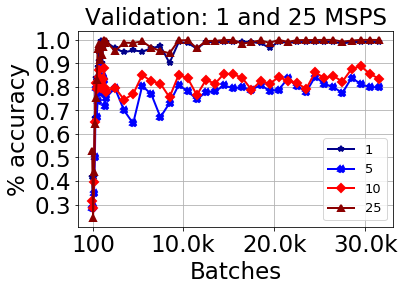

In [13]:
formatter = FuncFormatter(kilo_samples)
lim1 = 1500
a = np.arange(0,lim1,100) # Start at index position 1
lim2 = 300000
b = np.arange(1500,lim2,1000) # Start at index position 1
x = np.concatenate((a, b), axis=0)
a = 0
num = 46
# x = np.arange(0,num,1) # Start at index position 1
plt.rcParams.update({'font.size': 23})
# plt.figure(figsize=(9, 6))

# fig2 = plt.figure()

fig2, ax = plt.subplots()
ax.xaxis.set_major_formatter(formatter)



# ax = plt.subplot(111)
# Shrink current axis by 20%
# box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

plt.plot(x[a:num],resnet50_plot_1msps[a:num], '-*', c='darkblue',markersize=6, linewidth=2,markerfacecolor='darkblue',markeredgecolor='darkblue',markeredgewidth=2, label='1')
plt.plot(x[a:num],resnet50_plot_5msps[a:num], '-X', c='blue', markersize=6, linewidth=2,markerfacecolor='blue',markeredgecolor='blue',markeredgewidth=2, label='5')
plt.plot(x[a:num],resnet50_plot_10msps[a:num], '-D', c='red', markersize=6, linewidth=2,markerfacecolor='red',markeredgecolor='red',markeredgewidth=2, label='10')
plt.plot(x[a:num],resnet50_plot_25msps[a:num], '-^', c='darkred', markersize=6, linewidth=2,markerfacecolor='darkred',markeredgecolor='darkred',markeredgewidth=2, label='25')
plt.legend(loc='lower right', fontsize=13)
# Put a legend to the right of the current axis
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Validation: 1 and 25 MSPS', fontsize=23)
plt.xlabel('Batches')
plt.ylabel('% accuracy')
plt.grid()
# plt.minorticks_on()
# plt.yticks(np.arange(.5,1, .1))
# plt.yticks([.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0])
plt.yticks([.3, .4, .5, .6, .7, .8, .9, 1.0])
# plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 10])
plt.xticks([100, 10000,20000, 30000])
# plt.tight_layout()
axes=plt.gca()
# ax.set_aspect('equal')
# axes.set_aspect(10)
plt.subplots_adjust(left=0.17)
plt.subplots_adjust(bottom=0.20)
# fig2.set_size_inches(8.27, 11.69)
fig2.set_size_inches(6.0, 4.0)
fig2.savefig('resnet50_1class_20220210_mix_msps.pdf', format="pdf")

#### original plot used in paper

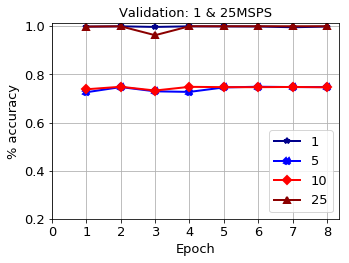

In [96]:
# num = len(resnet50_4D) # reduced rank by 1 for matrix math to work out
num = 9
x = np.arange(0,num,1) # Start at index position 1
plt.rcParams.update({'font.size': 13})
# plt.figure(figsize=(9, 6))

fig2 = plt.figure()
# ax = plt.subplot(111)
# Shrink current axis by 20%
# box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

plt.plot(x[1:num],resnet50_plot_1msps[1:num], '-*', c='darkblue',markersize=6, linewidth=2,markerfacecolor='darkblue',markeredgecolor='darkblue',markeredgewidth=2, label='1')
plt.plot(x[1:num],resnet50_plot_5msps[1:num], '-X', c='blue', markersize=6, linewidth=2,markerfacecolor='blue',markeredgecolor='blue',markeredgewidth=2, label='5')
plt.plot(x[1:num],resnet50_plot_10msps[1:num], '-D', c='red', markersize=6, linewidth=2,markerfacecolor='red',markeredgecolor='red',markeredgewidth=2, label='10')
plt.plot(x[1:num],resnet50_plot_25msps[1:num], '-^', c='darkred', markersize=6, linewidth=2,markerfacecolor='darkred',markeredgecolor='darkred',markeredgewidth=2, label='25')
plt.legend(loc='lower right', fontsize=13)
# Put a legend to the right of the current axis
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Validation: 1 & 25MSPS', fontsize=13)
plt.xlabel('Epoch')
plt.ylabel('% accuracy')
plt.grid()
# plt.minorticks_on()
# plt.yticks(np.arange(.5,1, .1))
plt.yticks([.2, .4, .6, .8, 1.0])
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
# plt.tight_layout()
axes=plt.gca()
axes.set_aspect(7)
plt.subplots_adjust(left=0.15)
plt.subplots_adjust(bottom=0.20)
fig2.set_size_inches(6.0, 4.0)
fig2.savefig('resnet50_mix_1class_20220125_old.pdf', format="pdf")
# plt.show()

#### Training 2 classes per patch

In [61]:
batches = 64
classes = 2
batches = batches*classes

In [62]:
criterion = nn.BCEWithLogitsLoss()
lr= 1e-4 # .0004
optimizer = optim.Adam(model.parameters(), lr=lr)
model.train()

ResNet(
  (encoder): ResNetEncoder(
    (gate): Sequential(
      (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (blocks): ModuleList(
      (0): ResNetLayer(
        (blocks): Sequential(
          (0): ResNetBottleNeckBlock(
            (blocks): Sequential(
              (0): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1): ReLU()
              (2): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

#### seperated dataloaders

In [ ]:
# train_dataloader1 = RFDataset(path_1msps, limit=None)
# train_dataloader25 = RFDataset(path_25msps, limit=None)

In [ ]:
# training_data1 = data.DataLoader(train_dataloader1, batch_size=batches, shuffle=True)
# training_data25 = data.DataLoader(train_dataloader25, batch_size=batches, shuffle=True)

#### combined dataloaders (External drive)

In [63]:
train_dataloader = RFDataset(path, limit=None)

/media/david/Extreme Pro/data/combined_data/training_data/
list of patches = 361200


In [64]:
training_data = data.DataLoader(train_dataloader, batch_size=batches, shuffle=True)

In [ ]:
# val_patches = None
# rf_dataset_val = RFDataset(path_validation, limit=val_patches)
# validation_data = data.DataLoader(rf_dataset_val, batch_size=batches, shuffle=True)
# validation_data = [validation_data]

In [65]:
val_patches = None
rf_dataset_val1 = RFDataset(path_val_1msps, limit=val_patches)
rf_dataset_val5 = RFDataset(path_val_5msps, limit=val_patches)
rf_dataset_val10 = RFDataset(path_val_10msps, limit=val_patches)
rf_dataset_val25 = RFDataset(path_val_25msps, limit=val_patches)
validation_data1 = data.DataLoader(rf_dataset_val1, batch_size=batches, shuffle=True)
validation_data1 = [validation_data1]
validation_data5 = data.DataLoader(rf_dataset_val5, batch_size=batches, shuffle=True)
validation_data5 = [validation_data5]
validation_data10 = data.DataLoader(rf_dataset_val10, batch_size=batches, shuffle=True)
validation_data10 = [validation_data10]
validation_data25 = data.DataLoader(rf_dataset_val25, batch_size=batches, shuffle=True)
validation_data25 = [validation_data25]

/home/david/sigMF_ML/RF/RF_class/val_1msps/
list of patches = 24000
/home/david/sigMF_ML/RF/RF_class/val_5msps/
list of patches = 20004
/home/david/sigMF_ML/RF/RF_class/val_10msps/
list of patches = 20004
/home/david/sigMF_ML/RF/RF_class/val_25msps/
list of patches = 24000


In [66]:
total = 20
loss_plot2, total_plot2, plot_1msps2, plot_5msps2, plot_10msps2, plot_25msps2 = train_net_combined_data(total)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

batches =  128
total patch count =  44004
training data length =  2822
iter epoch =  100
iter batch =  100
i_main =  100
batch time =  0.7782637390773743
************************* start *************************
Total 1msps correct = 33.40%
Total 5msps correct = 21.56%
Total 10msps correct = 22.70%


Epoch:   0%|          | 0/20 [05:34<?, ?it/s]

Total 25msps correct = 37.79%
Total % correct 29.47%
test time =  248.07307552499697
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.2690065503 
___________________________________________
iter epoch =  200
iter batch =  100
i_main =  200
batch time =  0.7711632780265063
************************* start *************************
Total 1msps correct = 58.52%
Total 5msps correct = 36.55%
Total 10msps correct = 38.51%


Epoch:   0%|          | 0/20 [10:06<?, ?it/s]

Total 25msps correct = 56.46%
Total % correct 48.42%
test time =  186.10885923495516
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0879242644 
___________________________________________
iter epoch =  300
iter batch =  100
i_main =  300
batch time =  0.7845956649398431
************************* start *************************
Total 1msps correct = 63.96%
Total 5msps correct = 35.62%
Total 10msps correct = 40.20%


Epoch:   0%|          | 0/20 [14:40<?, ?it/s]

Total 25msps correct = 63.32%
Total % correct 51.95%
test time =  188.3411667039618
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0608583651 
___________________________________________
iter epoch =  400
iter batch =  100
i_main =  400
batch time =  0.7714220539201051
************************* start *************************
Total 1msps correct = 65.33%
Total 5msps correct = 42.32%
Total 10msps correct = 45.24%


Epoch:   0%|          | 0/20 [19:13<?, ?it/s]

Total 25msps correct = 68.96%
Total % correct 56.52%
test time =  185.63107813103124
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0646057650 
___________________________________________
iter epoch =  500
iter batch =  100
i_main =  500
batch time =  0.774080328992568
************************* start *************************
Total 1msps correct = 66.80%
Total 5msps correct = 45.22%
Total 10msps correct = 48.35%


Epoch:   0%|          | 0/20 [23:44<?, ?it/s]

Total 25msps correct = 70.18%
Total % correct 58.62%
test time =  184.72632691904437
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0551487207 
___________________________________________
iter epoch =  600
iter batch =  100
i_main =  600
batch time =  0.7884408229729161
************************* start *************************
Total 1msps correct = 70.48%
Total 5msps correct = 49.08%
Total 10msps correct = 52.20%


Epoch:   0%|          | 0/20 [28:16<?, ?it/s]

Total 25msps correct = 74.04%
Total % correct 62.43%
test time =  184.74623599695042
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0577884763 
___________________________________________
iter epoch =  700
iter batch =  100
i_main =  700
batch time =  0.7974544860189781
************************* start *************************
Total 1msps correct = 71.01%
Total 5msps correct = 50.90%
Total 10msps correct = 53.34%


Epoch:   0%|          | 0/20 [32:47<?, ?it/s]

Total 25msps correct = 74.92%
Total % correct 63.49%
test time =  185.1844618379837
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0659614652 
___________________________________________
iter epoch =  800
iter batch =  100
i_main =  800
batch time =  0.7821351769380271
************************* start *************************
Total 1msps correct = 72.43%
Total 5msps correct = 49.86%
Total 10msps correct = 55.07%


Epoch:   0%|          | 0/20 [37:19<?, ?it/s]

Total 25msps correct = 75.52%
Total % correct 64.20%
test time =  186.04736805602442
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0352838859 
___________________________________________
iter epoch =  900
iter batch =  100
i_main =  900
batch time =  0.7752055389573798
************************* start *************************
Total 1msps correct = 70.09%
Total 5msps correct = 49.16%
Total 10msps correct = 52.44%


Epoch:   0%|          | 0/20 [41:51<?, ?it/s]

Total 25msps correct = 75.76%
Total % correct 62.87%
test time =  186.61887441703584
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0759440586 
___________________________________________
iter epoch =  1000
iter batch =  100
i_main =  1000
batch time =  0.7820476399501786
************************* start *************************
Total 1msps correct = 73.95%
Total 5msps correct = 47.39%
Total 10msps correct = 53.42%


Epoch:   0%|          | 0/20 [46:21<?, ?it/s]

Total 25msps correct = 75.23%
Total % correct 63.60%
test time =  185.44284794200212
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0581516139 
___________________________________________
iter epoch =  1100
iter batch =  100
i_main =  1100
batch time =  0.7749944659881294
************************* start *************************
Total 1msps correct = 74.41%
Total 5msps correct = 49.96%
Total 10msps correct = 55.79%


Epoch:   0%|          | 0/20 [50:54<?, ?it/s]

Total 25msps correct = 73.17%
Total % correct 64.28%
test time =  187.20660764398053
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0665763170 
___________________________________________
iter epoch =  1200
iter batch =  100
i_main =  1200
batch time =  0.773327972041443
************************* start *************************
Total 1msps correct = 76.13%
Total 5msps correct = 51.28%
Total 10msps correct = 57.47%


Epoch:   0%|          | 0/20 [55:26<?, ?it/s]

Total 25msps correct = 79.93%
Total % correct 67.28%
test time =  185.43303307599854
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0544812009 
___________________________________________
iter epoch =  1300
iter batch =  100
i_main =  1300
batch time =  0.7740288160275668
************************* start *************************
Total 1msps correct = 75.38%
Total 5msps correct = 51.79%
Total 10msps correct = 60.31%


Epoch:   0%|          | 0/20 [59:59<?, ?it/s]

Total 25msps correct = 79.12%
Total % correct 67.61%
test time =  185.90926016191952
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0492759161 
___________________________________________
iter epoch =  1400
iter batch =  100
i_main =  1400
batch time =  0.7839374579489231
************************* start *************************
Total 1msps correct = 77.45%
Total 5msps correct = 52.13%
Total 10msps correct = 59.02%


Epoch:   0%|          | 0/20 [1:04:31<?, ?it/s]

Total 25msps correct = 77.73%
Total % correct 67.58%
test time =  185.58909356594086
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0271988623 
___________________________________________
iter epoch =  2000
iter batch =  1000
i_main =  2000
batch time =  0.7769532899837941
************************* start *************************
Total 1msps correct = 79.34%
Total 5msps correct = 51.95%
Total 10msps correct = 60.24%


Epoch:   0%|          | 0/20 [1:16:54<?, ?it/s]

Total 25msps correct = 77.53%
Total % correct 68.28%
test time =  232.6870656880783
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0565201640 
___________________________________________
left over patches =  112


Epoch:   5%|▌         | 1/20 [1:28:34<28:02:58, 5314.63s/it]

iter epoch =  178
iter batch =  1000
i_main =  3000
batch time =  0.7782452749088407
************************* start *************************
Total 1msps correct = 82.09%
Total 5msps correct = 59.07%
Total 10msps correct = 63.41%


Epoch:   5%|▌         | 1/20 [1:35:03<28:02:58, 5314.63s/it]

Total 25msps correct = 82.15%
Total % correct 72.63%
test time =  247.93607581593096
*************************** end ***************************
___________________________________________
Epoch 2 Loss 0.0196886603 
___________________________________________
iter epoch =  1178
iter batch =  1000
i_main =  4000
batch time =  0.8292389960261062
************************* start *************************
Total 1msps correct = 83.39%
Total 5msps correct = 58.00%
Total 10msps correct = 61.27%


Epoch:   5%|▌         | 1/20 [1:53:29<28:02:58, 5314.63s/it]

Total 25msps correct = 87.09%
Total % correct 73.60%
test time =  252.47498892701697
*************************** end ***************************
___________________________________________
Epoch 2 Loss 0.0147889685 
___________________________________________
iter epoch =  2178
iter batch =  1000
i_main =  5000
batch time =  0.8167463060235605
************************* start *************************
Total 1msps correct = 83.91%
Total 5msps correct = 60.27%
Total 10msps correct = 64.80%


Epoch:   5%|▌         | 1/20 [2:11:57<28:02:58, 5314.63s/it]

Total 25msps correct = 89.33%
Total % correct 75.67%
test time =  250.0539779420942
*************************** end ***************************
___________________________________________
Epoch 2 Loss 0.0246600267 
___________________________________________
left over patches =  112


Epoch:  10%|█         | 2/20 [2:21:09<23:20:00, 4666.70s/it]

iter epoch =  356
iter batch =  1000
i_main =  6000
batch time =  0.7784578750142828
************************* start *************************
Total 1msps correct = 85.98%
Total 5msps correct = 64.56%
Total 10msps correct = 68.97%


Epoch:  10%|█         | 2/20 [2:30:01<23:20:00, 4666.70s/it]

Total 25msps correct = 92.03%
Total % correct 78.90%
test time =  249.8935709670186
*************************** end ***************************
___________________________________________
Epoch 3 Loss 0.0393112116 
___________________________________________
iter epoch =  1356
iter batch =  1000
i_main =  7000
batch time =  1.1185195199213922
************************* start *************************
Total 1msps correct = 85.97%
Total 5msps correct = 66.31%
Total 10msps correct = 66.69%


Epoch:  10%|█         | 2/20 [2:48:26<23:20:00, 4666.70s/it]

Total 25msps correct = 88.52%
Total % correct 77.82%
test time =  250.20767527702264
*************************** end ***************************
___________________________________________
Epoch 3 Loss 0.0455173478 
___________________________________________
iter epoch =  2356
iter batch =  1000
i_main =  8000
batch time =  0.7804546619299799
************************* start *************************
Total 1msps correct = 87.62%
Total 5msps correct = 63.28%
Total 10msps correct = 66.90%


Epoch:  10%|█         | 2/20 [3:06:56<23:20:00, 4666.70s/it]

Total 25msps correct = 92.05%
Total % correct 78.58%
test time =  252.15411955001764
*************************** end ***************************
___________________________________________
Epoch 3 Loss 0.0375909917 
___________________________________________
left over patches =  112


Epoch:  15%|█▌        | 3/20 [3:13:36<19:53:03, 4210.80s/it]

iter epoch =  534
iter batch =  1000
i_main =  9000
batch time =  0.7851351079298183
************************* start *************************
Total 1msps correct = 89.14%
Total 5msps correct = 64.49%
Total 10msps correct = 70.40%


Epoch:  15%|█▌        | 3/20 [3:25:03<19:53:03, 4210.80s/it]

Total 25msps correct = 93.74%
Total % correct 80.53%
test time =  253.0270506690722
*************************** end ***************************
___________________________________________
Epoch 4 Loss 0.0212949421 
___________________________________________
iter epoch =  1534
iter batch =  1000
i_main =  10000
batch time =  0.777271670056507
************************* start *************************
Total 1msps correct = 89.18%
Total 5msps correct = 67.79%
Total 10msps correct = 69.22%


Epoch:  15%|█▌        | 3/20 [3:43:33<19:53:03, 4210.80s/it]

Total 25msps correct = 92.46%
Total % correct 80.67%
test time =  250.5341652999632
*************************** end ***************************
___________________________________________
Epoch 4 Loss 0.0156001030 
___________________________________________
iter epoch =  2534
iter batch =  1000
i_main =  11000
batch time =  0.7755341730080545
************************* start *************************
Total 1msps correct = 87.32%
Total 5msps correct = 65.46%
Total 10msps correct = 67.23%


Epoch:  15%|█▌        | 3/20 [4:02:00<19:53:03, 4210.80s/it]

Total 25msps correct = 92.34%
Total % correct 79.15%
test time =  250.97860546095762
*************************** end ***************************
___________________________________________
Epoch 4 Loss 0.0025450296 
___________________________________________
left over patches =  112


Epoch:  20%|██        | 4/20 [4:06:05<17:17:54, 3892.16s/it]

iter epoch =  712
iter batch =  1000
i_main =  12000
batch time =  0.7785476989811286
************************* start *************************
Total 1msps correct = 88.78%
Total 5msps correct = 65.95%
Total 10msps correct = 71.49%


Epoch:  20%|██        | 4/20 [4:20:06<17:17:54, 3892.16s/it]

Total 25msps correct = 94.62%
Total % correct 81.25%
test time =  253.6123261169996
*************************** end ***************************
___________________________________________
Epoch 5 Loss 0.0280913915 
___________________________________________
iter epoch =  1712
iter batch =  1000
i_main =  13000
batch time =  0.7797219910426065
************************* start *************************
Total 1msps correct = 88.63%
Total 5msps correct = 67.82%
Total 10msps correct = 72.84%


Epoch:  20%|██        | 4/20 [4:38:38<17:17:54, 3892.16s/it]

Total 25msps correct = 93.17%
Total % correct 81.55%
test time =  251.26148757210467
*************************** end ***************************
___________________________________________
Epoch 5 Loss 0.0360308141 
___________________________________________
iter epoch =  2712
iter batch =  1000
i_main =  14000
batch time =  0.8029050850309432
************************* start *************************
Total 1msps correct = 88.88%
Total 5msps correct = 66.35%
Total 10msps correct = 70.43%


Epoch:  20%|██        | 4/20 [4:57:12<17:17:54, 3892.16s/it]

Total 25msps correct = 92.58%
Total % correct 80.57%
test time =  251.1998757000547
*************************** end ***************************
___________________________________________
Epoch 5 Loss 0.0274755191 
___________________________________________
left over patches =  112


Epoch:  25%|██▌       | 5/20 [4:58:46<15:18:13, 3672.87s/it]

iter epoch =  890
iter batch =  1000
i_main =  15000
batch time =  0.783139755949378
************************* start *************************
Total 1msps correct = 88.81%
Total 5msps correct = 65.50%
Total 10msps correct = 68.80%


Epoch:  25%|██▌       | 5/20 [5:15:29<15:18:13, 3672.87s/it]

Total 25msps correct = 91.56%
Total % correct 79.71%
test time =  251.15215455996804
*************************** end ***************************
___________________________________________
Epoch 6 Loss 0.0109135807 
___________________________________________
iter epoch =  1890
iter batch =  1000
i_main =  16000
batch time =  0.7819697860395536
************************* start *************************
Total 1msps correct = 84.21%
Total 5msps correct = 67.82%
Total 10msps correct = 71.15%


Epoch:  25%|██▌       | 5/20 [5:34:01<15:18:13, 3672.87s/it]

Total 25msps correct = 93.88%
Total % correct 80.15%
test time =  251.47508566000033
*************************** end ***************************
___________________________________________
Epoch 6 Loss 0.0153348297 
___________________________________________
left over patches =  112


Epoch:  30%|███       | 6/20 [5:47:20<13:23:51, 3445.13s/it]

iter epoch =  68
iter batch =  1000
i_main =  17000
batch time =  0.7822970109991729
************************* start *************************
Total 1msps correct = 89.55%
Total 5msps correct = 68.33%
Total 10msps correct = 72.23%


Epoch:  30%|███       | 6/20 [5:52:24<13:23:51, 3445.13s/it]

Total 25msps correct = 93.89%
Total % correct 81.97%
test time =  251.05420745105948
*************************** end ***************************
___________________________________________
Epoch 7 Loss 0.0322815664 
___________________________________________
iter epoch =  1068
iter batch =  1000
i_main =  18000
batch time =  0.7885628560325131
************************* start *************************
Total 1msps correct = 91.66%
Total 5msps correct = 64.76%
Total 10msps correct = 72.51%


Epoch:  30%|███       | 6/20 [6:10:55<13:23:51, 3445.13s/it]

Total 25msps correct = 94.93%
Total % correct 82.08%
test time =  250.8494486398995
*************************** end ***************************
___________________________________________
Epoch 7 Loss 0.0022219962 
___________________________________________
iter epoch =  2068
iter batch =  1000
i_main =  19000
batch time =  0.7911019820021465
************************* start *************************
Total 1msps correct = 86.71%
Total 5msps correct = 65.42%
Total 10msps correct = 71.43%


Epoch:  30%|███       | 6/20 [6:29:25<13:23:51, 3445.13s/it]

Total 25msps correct = 94.66%
Total % correct 80.56%
test time =  251.5838414429454
*************************** end ***************************
___________________________________________
Epoch 7 Loss 0.0255697146 
___________________________________________
left over patches =  112


Epoch:  35%|███▌      | 7/20 [6:40:15<12:08:55, 3364.24s/it]

iter epoch =  246
iter batch =  1000
i_main =  20000
batch time =  0.7792109450092539
************************* start *************************
Total 1msps correct = 90.91%
Total 5msps correct = 62.99%
Total 10msps correct = 68.72%


Epoch:  35%|███▌      | 7/20 [6:47:43<12:08:55, 3364.24s/it]

Total 25msps correct = 94.23%
Total % correct 80.42%
test time =  253.57755640696269
*************************** end ***************************
___________________________________________
Epoch 8 Loss 0.0335389599 
___________________________________________
iter epoch =  1246
iter batch =  1000
i_main =  21000
batch time =  0.7953266389667988
************************* start *************************
Total 1msps correct = 90.77%
Total 5msps correct = 66.98%
Total 10msps correct = 72.59%


Epoch:  35%|███▌      | 7/20 [7:06:18<12:08:55, 3364.24s/it]

Total 25msps correct = 95.12%
Total % correct 82.42%
test time =  252.50770159601234
*************************** end ***************************
___________________________________________
Epoch 8 Loss 0.0124998828 
___________________________________________
iter epoch =  2246
iter batch =  1000
i_main =  22000
batch time =  0.8103462209692225
************************* start *************************
Total 1msps correct = 90.58%
Total 5msps correct = 69.42%
Total 10msps correct = 74.49%


Epoch:  35%|███▌      | 7/20 [7:24:52<12:08:55, 3364.24s/it]

Total 25msps correct = 94.56%
Total % correct 83.19%
test time =  252.15608717594296
*************************** end ***************************
___________________________________________
Epoch 8 Loss 0.0142536340 
___________________________________________
left over patches =  112


Epoch:  40%|████      | 8/20 [7:33:04<11:01:05, 3305.49s/it]

iter epoch =  424
iter batch =  1000
i_main =  23000
batch time =  0.7948923599906266
************************* start *************************
Total 1msps correct = 91.78%
Total 5msps correct = 70.69%
Total 10msps correct = 75.23%


Epoch:  40%|████      | 8/20 [7:42:55<11:01:05, 3305.49s/it]

Total 25msps correct = 95.33%
Total % correct 84.19%
test time =  252.20130395202432
*************************** end ***************************
___________________________________________
Epoch 9 Loss 0.0211612247 
___________________________________________
iter epoch =  1424
iter batch =  1000
i_main =  24000
batch time =  0.783796020084992
************************* start *************************
Total 1msps correct = 91.31%
Total 5msps correct = 60.00%
Total 10msps correct = 69.09%


Epoch:  40%|████      | 8/20 [8:01:37<11:01:05, 3305.49s/it]

Total 25msps correct = 94.64%
Total % correct 80.05%
test time =  259.2608061359497
*************************** end ***************************
___________________________________________
Epoch 9 Loss 0.0021773633 
___________________________________________
iter epoch =  2424
iter batch =  1000
i_main =  25000
batch time =  0.7801755239488557
************************* start *************************
Total 1msps correct = 91.27%
Total 5msps correct = 65.81%
Total 10msps correct = 72.73%


Epoch:  40%|████      | 8/20 [8:20:13<11:01:05, 3305.49s/it]

Total 25msps correct = 95.06%
Total % correct 82.30%
test time =  252.46367432596162
*************************** end ***************************
___________________________________________
Epoch 9 Loss 0.0110123260 
___________________________________________
left over patches =  112


Epoch:  45%|████▌     | 9/20 [8:25:54<9:58:35, 3265.03s/it] 

iter epoch =  602
iter batch =  1000
i_main =  26000
batch time =  0.7866242069285363
************************* start *************************
Total 1msps correct = 91.04%
Total 5msps correct = 65.07%
Total 10msps correct = 69.91%


Epoch:  45%|████▌     | 9/20 [8:38:24<9:58:35, 3265.03s/it]

Total 25msps correct = 95.03%
Total % correct 81.42%
test time =  252.78332879499067
*************************** end ***************************
___________________________________________
Epoch 10 Loss 0.0102308802 
___________________________________________
iter epoch =  1602
iter batch =  1000
i_main =  27000
batch time =  0.7796806099358946
************************* start *************************
Total 1msps correct = 90.49%
Total 5msps correct = 57.86%
Total 10msps correct = 69.63%


Epoch:  45%|████▌     | 9/20 [8:56:53<9:58:35, 3265.03s/it]

Total 25msps correct = 95.17%
Total % correct 79.61%
test time =  251.77258285798598
*************************** end ***************************
___________________________________________
Epoch 10 Loss 0.0179797634 
___________________________________________
iter epoch =  2602
iter batch =  1000
i_main =  28000
batch time =  0.8098578999051824
************************* start *************************
Total 1msps correct = 91.80%
Total 5msps correct = 69.75%
Total 10msps correct = 72.57%


Epoch:  45%|████▌     | 9/20 [9:15:30<9:58:35, 3265.03s/it]

Total 25msps correct = 95.53%
Total % correct 83.43%
test time =  254.62633597000968
*************************** end ***************************
___________________________________________
Epoch 10 Loss 0.0044113868 
___________________________________________
left over patches =  112


Epoch:  50%|█████     | 10/20 [9:18:37<8:59:04, 3234.42s/it]

iter epoch =  780
iter batch =  1000
i_main =  29000
batch time =  0.7847218359820545
************************* start *************************
Total 1msps correct = 91.07%
Total 5msps correct = 66.48%
Total 10msps correct = 70.38%


Epoch:  50%|█████     | 10/20 [9:33:50<8:59:04, 3234.42s/it]

Total 25msps correct = 95.09%
Total % correct 81.87%
test time =  252.3646453769179
*************************** end ***************************
___________________________________________
Epoch 11 Loss 0.0152104925 
___________________________________________
iter epoch =  1780
iter batch =  1000
i_main =  30000
batch time =  0.8465173860313371
************************* start *************************
Total 1msps correct = 91.17%
Total 5msps correct = 68.60%
Total 10msps correct = 73.64%


Epoch:  50%|█████     | 10/20 [9:52:26<8:59:04, 3234.42s/it]

Total 25msps correct = 95.82%
Total % correct 83.32%
test time =  253.83645127690397
*************************** end ***************************
___________________________________________
Epoch 11 Loss 0.0298933387 
___________________________________________
iter epoch =  2780
iter batch =  1000
i_main =  31000
batch time =  0.7878515280317515
************************* start *************************
Total 1msps correct = 90.79%
Total 5msps correct = 70.86%
Total 10msps correct = 75.90%


Epoch:  50%|█████     | 10/20 [10:11:06<8:59:04, 3234.42s/it]

Total 25msps correct = 96.01%
Total % correct 84.30%
test time =  255.12770287704188
*************************** end ***************************
___________________________________________
Epoch 11 Loss 0.0184091404 
___________________________________________
left over patches =  112


Epoch:  55%|█████▌    | 11/20 [10:11:41<8:02:53, 3219.26s/it]

iter epoch =  958
iter batch =  1000
i_main =  32000
batch time =  0.7938262070529163
************************* start *************************
Total 1msps correct = 91.75%
Total 5msps correct = 71.29%
Total 10msps correct = 77.04%


Epoch:  55%|█████▌    | 11/20 [10:29:39<8:02:53, 3219.26s/it]

Total 25msps correct = 95.93%
Total % correct 84.90%
test time =  254.3856248400407
*************************** end ***************************
___________________________________________
Epoch 12 Loss 0.0029043201 
___________________________________________
iter epoch =  1958
iter batch =  1000
i_main =  33000
batch time =  0.8001269770320505
************************* start *************************
Total 1msps correct = 92.01%
Total 5msps correct = 65.98%
Total 10msps correct = 73.11%


Epoch:  55%|█████▌    | 11/20 [10:48:14<8:02:53, 3219.26s/it]

Total 25msps correct = 96.28%
Total % correct 82.96%
test time =  253.1742886629654
*************************** end ***************************
___________________________________________
Epoch 12 Loss 0.0106988344 
___________________________________________
left over patches =  112


Epoch:  60%|██████    | 12/20 [11:00:39<6:57:58, 3134.83s/it]

iter epoch =  136
iter batch =  1000
i_main =  34000
batch time =  0.7901420600246638
************************* start *************************
Total 1msps correct = 92.07%
Total 5msps correct = 68.98%
Total 10msps correct = 74.66%


Epoch:  60%|██████    | 12/20 [11:06:37<6:57:58, 3134.83s/it]

Total 25msps correct = 96.39%
Total % correct 84.04%
test time =  252.45541127002798
*************************** end ***************************
___________________________________________
Epoch 13 Loss 0.0206504315 
___________________________________________
iter epoch =  1136
iter batch =  1000
i_main =  35000
batch time =  0.7901685900287703
************************* start *************************
Total 1msps correct = 91.96%
Total 5msps correct = 73.47%
Total 10msps correct = 77.27%


Epoch:  60%|██████    | 12/20 [11:25:12<6:57:58, 3134.83s/it]

Total 25msps correct = 96.01%
Total % correct 85.52%
test time =  253.31957933795638
*************************** end ***************************
___________________________________________
Epoch 13 Loss 0.0175819006 
___________________________________________
iter epoch =  2136
iter batch =  1000
i_main =  36000
batch time =  0.8122210230212659
************************* start *************************
Total 1msps correct = 91.83%
Total 5msps correct = 67.68%
Total 10msps correct = 75.00%


Epoch:  60%|██████    | 12/20 [11:43:49<6:57:58, 3134.83s/it]

Total 25msps correct = 95.68%
Total % correct 83.57%
test time =  253.702250373899
*************************** end ***************************
___________________________________________
Epoch 13 Loss 0.0162997097 
___________________________________________
left over patches =  112


Epoch:  65%|██████▌   | 13/20 [11:53:38<6:07:16, 3148.04s/it]

iter epoch =  314
iter batch =  1000
i_main =  37000
batch time =  0.7844163640402257
************************* start *************************
Total 1msps correct = 92.03%
Total 5msps correct = 66.15%
Total 10msps correct = 75.01%


Epoch:  65%|██████▌   | 13/20 [12:02:00<6:07:16, 3148.04s/it]

Total 25msps correct = 96.08%
Total % correct 83.39%
test time =  254.45602325291838
*************************** end ***************************
___________________________________________
Epoch 14 Loss 0.0062344186 
___________________________________________
iter epoch =  1314
iter batch =  1000
i_main =  38000
batch time =  0.7827753380406648
************************* start *************************
Total 1msps correct = 92.71%
Total 5msps correct = 66.42%
Total 10msps correct = 74.16%


Epoch:  65%|██████▌   | 13/20 [12:20:34<6:07:16, 3148.04s/it]

Total 25msps correct = 95.85%
Total % correct 83.37%
test time =  253.11179031000938
*************************** end ***************************
___________________________________________
Epoch 14 Loss 0.0071195811 
___________________________________________
iter epoch =  2314
iter batch =  1000
i_main =  39000
batch time =  0.7920355059904978
************************* start *************************
Total 1msps correct = 91.97%
Total 5msps correct = 74.44%
Total 10msps correct = 77.35%


Epoch:  65%|██████▌   | 13/20 [12:39:10<6:07:16, 3148.04s/it]

Total 25msps correct = 96.71%
Total % correct 85.96%
test time =  253.1432581259869
*************************** end ***************************
___________________________________________
Epoch 14 Loss 0.0033349057 
___________________________________________
left over patches =  112


Epoch:  70%|███████   | 14/20 [12:46:27<5:15:26, 3154.40s/it]

iter epoch =  492
iter batch =  1000
i_main =  40000
batch time =  0.7903585419990122
************************* start *************************
Total 1msps correct = 92.53%
Total 5msps correct = 73.57%
Total 10msps correct = 77.31%


Epoch:  70%|███████   | 14/20 [12:57:16<5:15:26, 3154.40s/it]

Total 25msps correct = 96.75%
Total % correct 85.91%
test time =  253.32924010709394
*************************** end ***************************
___________________________________________
Epoch 15 Loss 0.0264165755 
___________________________________________
iter epoch =  1492
iter batch =  1000
i_main =  41000
batch time =  0.7790824749972671
************************* start *************************
Total 1msps correct = 91.83%
Total 5msps correct = 70.82%
Total 10msps correct = 76.11%


Epoch:  70%|███████   | 14/20 [13:15:53<5:15:26, 3154.40s/it]

Total 25msps correct = 96.10%
Total % correct 84.64%
test time =  252.86818320304155
*************************** end ***************************
___________________________________________
Epoch 15 Loss 0.0232328549 
___________________________________________
iter epoch =  2492
iter batch =  1000
i_main =  42000
batch time =  0.7816875058924779
************************* start *************************
Total 1msps correct = 93.54%
Total 5msps correct = 71.50%
Total 10msps correct = 77.99%


Epoch:  70%|███████   | 14/20 [13:34:27<5:15:26, 3154.40s/it]

Total 25msps correct = 96.65%
Total % correct 85.84%
test time =  254.36680133000482
*************************** end ***************************
___________________________________________
Epoch 15 Loss 0.0113156457 
___________________________________________
left over patches =  112


Epoch:  75%|███████▌  | 15/20 [13:39:11<4:23:07, 3157.40s/it]

iter epoch =  670
iter batch =  1000
i_main =  43000
batch time =  0.7922560849692672
************************* start *************************
Total 1msps correct = 90.28%
Total 5msps correct = 66.96%
Total 10msps correct = 74.44%


Epoch:  75%|███████▌  | 15/20 [13:52:43<4:23:07, 3157.40s/it]

Total 25msps correct = 96.66%
Total % correct 83.12%
test time =  254.3981888430426
*************************** end ***************************
___________________________________________
Epoch 16 Loss 0.0098592211 
___________________________________________
iter epoch =  1670
iter batch =  1000
i_main =  44000
batch time =  0.8364607250550762
************************* start *************************
Total 1msps correct = 93.23%
Total 5msps correct = 65.44%
Total 10msps correct = 72.53%


Epoch:  75%|███████▌  | 15/20 [14:11:17<4:23:07, 3157.40s/it]

Total 25msps correct = 95.59%
Total % correct 82.85%
test time =  254.67502298403997
*************************** end ***************************
___________________________________________
Epoch 16 Loss 0.0073136194 
___________________________________________
iter epoch =  2670
iter batch =  1000
i_main =  45000
batch time =  0.7889696640195325
************************* start *************************
Total 1msps correct = 93.68%
Total 5msps correct = 66.23%
Total 10msps correct = 74.28%


Epoch:  75%|███████▌  | 15/20 [14:29:55<4:23:07, 3157.40s/it]

Total 25msps correct = 96.67%
Total % correct 83.84%
test time =  254.231817677035
*************************** end ***************************
___________________________________________
Epoch 16 Loss 0.0161696877 
___________________________________________
left over patches =  112


Epoch:  80%|████████  | 16/20 [14:32:05<3:30:49, 3162.42s/it]

iter epoch =  848
iter batch =  1000
i_main =  46000
batch time =  0.785273693036288
************************* start *************************
Total 1msps correct = 93.60%
Total 5msps correct = 68.74%
Total 10msps correct = 76.49%


Epoch:  80%|████████  | 16/20 [14:48:15<3:30:49, 3162.42s/it]

Total 25msps correct = 96.20%
Total % correct 84.77%
test time =  253.14385796908755
*************************** end ***************************
___________________________________________
Epoch 17 Loss 0.0043389923 
___________________________________________
iter epoch =  1848
iter batch =  1000
i_main =  47000
batch time =  0.8266408920753747
************************* start *************************
Total 1msps correct = 93.30%
Total 5msps correct = 67.26%
Total 10msps correct = 72.84%


Epoch:  80%|████████  | 16/20 [15:06:55<3:30:49, 3162.42s/it]

Total 25msps correct = 96.66%
Total % correct 83.64%
test time =  256.26383266504854
*************************** end ***************************
___________________________________________
Epoch 17 Loss 0.0082867052 
___________________________________________
left over patches =  112


Epoch:  85%|████████▌ | 17/20 [15:20:47<2:34:30, 3090.14s/it]

iter epoch =  26
iter batch =  1000
i_main =  48000
batch time =  0.7874459259910509
************************* start *************************
Total 1msps correct = 93.23%
Total 5msps correct = 68.52%
Total 10msps correct = 76.46%


Epoch:  85%|████████▌ | 17/20 [15:25:21<2:34:30, 3090.14s/it]

Total 25msps correct = 96.77%
Total % correct 84.77%
test time =  253.29831993300468
*************************** end ***************************
___________________________________________
Epoch 18 Loss 0.0023747766 
___________________________________________
iter epoch =  1026
iter batch =  1000
i_main =  49000
batch time =  0.785812504007481
************************* start *************************
Total 1msps correct = 94.02%
Total 5msps correct = 59.77%
Total 10msps correct = 71.23%


Epoch:  85%|████████▌ | 17/20 [15:43:53<2:34:30, 3090.14s/it]

Total 25msps correct = 97.28%
Total % correct 81.94%
test time =  253.5447893589735
*************************** end ***************************
___________________________________________
Epoch 18 Loss 0.0015432168 
___________________________________________
iter epoch =  2026
iter batch =  1000
i_main =  50000
batch time =  0.7870453130453825
************************* start *************************
Total 1msps correct = 94.07%
Total 5msps correct = 70.40%
Total 10msps correct = 76.05%


Epoch:  85%|████████▌ | 17/20 [16:02:27<2:34:30, 3090.14s/it]

Total 25msps correct = 95.18%
Total % correct 84.90%
test time =  253.61347488197498
*************************** end ***************************
___________________________________________
Epoch 18 Loss 0.0076576858 
___________________________________________
left over patches =  112


Epoch:  90%|█████████ | 18/20 [16:13:53<1:43:57, 3118.98s/it]

iter epoch =  204
iter batch =  1000
i_main =  51000
batch time =  0.7935374580556527
************************* start *************************
Total 1msps correct = 93.66%
Total 5msps correct = 69.22%
Total 10msps correct = 75.91%


Epoch:  90%|█████████ | 18/20 [16:20:49<1:43:57, 3118.98s/it]

Total 25msps correct = 96.58%
Total % correct 84.87%
test time =  255.73798029101454
*************************** end ***************************
___________________________________________
Epoch 19 Loss 0.0028443169 
___________________________________________
iter epoch =  1204
iter batch =  1000
i_main =  52000
batch time =  0.816651175962761
************************* start *************************
Total 1msps correct = 93.65%
Total 5msps correct = 66.40%
Total 10msps correct = 73.55%


Epoch:  90%|█████████ | 18/20 [16:39:31<1:43:57, 3118.98s/it]

Total 25msps correct = 96.81%
Total % correct 83.75%
test time =  258.5066538240062
*************************** end ***************************
___________________________________________
Epoch 19 Loss 0.0021664100 
___________________________________________
iter epoch =  2204
iter batch =  1000
i_main =  53000
batch time =  0.7857555740047246
************************* start *************************
Total 1msps correct = 93.84%
Total 5msps correct = 65.72%
Total 10msps correct = 74.14%


Epoch:  90%|█████████ | 18/20 [16:58:09<1:43:57, 3118.98s/it]

Total 25msps correct = 96.34%
Total % correct 83.65%
test time =  252.9322902840795
*************************** end ***************************
___________________________________________
Epoch 19 Loss 0.0058217901 
___________________________________________
left over patches =  112


Epoch:  95%|█████████▌| 19/20 [17:07:02<52:19, 3139.92s/it]  

iter epoch =  382
iter batch =  1000
i_main =  54000
batch time =  0.8490219289669767
************************* start *************************
Total 1msps correct = 93.57%
Total 5msps correct = 66.67%
Total 10msps correct = 77.02%


Epoch:  95%|█████████▌| 19/20 [17:16:21<52:19, 3139.92s/it]

Total 25msps correct = 97.61%
Total % correct 84.79%
test time =  254.1105891750194
*************************** end ***************************
___________________________________________
Epoch 20 Loss 0.0033063726 
___________________________________________
iter epoch =  1382
iter batch =  1000
i_main =  55000
batch time =  0.7867630750406533
************************* start *************************
Total 1msps correct = 93.29%
Total 5msps correct = 64.71%
Total 10msps correct = 70.90%


Epoch:  95%|█████████▌| 19/20 [17:34:59<52:19, 3139.92s/it]

Total 25msps correct = 97.07%
Total % correct 82.73%
test time =  257.16036238498054
*************************** end ***************************
___________________________________________
Epoch 20 Loss 0.0111635728 
___________________________________________
iter epoch =  2382
iter batch =  1000
i_main =  56000
batch time =  0.7806770760798827
************************* start *************************
Total 1msps correct = 93.80%
Total 5msps correct = 70.33%
Total 10msps correct = 76.96%


Epoch:  95%|█████████▌| 19/20 [17:53:38<52:19, 3139.92s/it]

Total 25msps correct = 97.46%
Total % correct 85.64%
test time =  253.66556115995627
*************************** end ***************************
___________________________________________
Epoch 20 Loss 0.0171918646 
___________________________________________
left over patches =  112


Epoch: 100%|██████████| 20/20 [17:59:57<00:00, 3239.87s/it]


In [114]:
resnet50_plot_1msps2

array([0.0295    , 0.11883333, 0.16708333, 0.26708333, 0.32091667,
       0.46583333, 0.41758333, 0.56866667, 0.63933333, 0.64291667,
       0.65241667, 0.688     , 0.62691667, 0.71133333, 0.80775   ,
       0.85816667, 0.87383333, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

### PLOTTING 2 classes/patch

In [69]:
path_plot_fig = "/home/david/sigMF_ML/RF/RF_class/plot_data/" # ACE
os.chdir(path_plot_fig)
# np.save('resnet50_4ch_total_plot2_20220211', np.asarray(total_plot2))
np.save('resnet50_4ch_plot_1msps2_20220211', np.asarray(plot_1msps2))
np.save('resnet50_4ch_plot_5msps2_20220211', np.asarray(plot_5msps2))
np.save('resnet50_4ch_plot_10msps2_20220211', np.asarray(plot_10msps2))
np.save('resnet50_4ch_plot_25msps2_20220211', np.asarray(plot_25msps2))

In [70]:
path_plot_fig = "/home/david/sigMF_ML/RF/RF_class/plot_data/" # ACE
os.chdir(path_plot_fig)
# resnet50_total_plot2 = np.load('resnet50_4ch_total_plot2_20220211.npy')
resnet50_plot_1msps2 = np.load('resnet50_4ch_plot_1msps2_20220211.npy')
resnet50_plot_5msps2 = np.load('resnet50_4ch_plot_5msps2_20220211.npy')
resnet50_plot_10msps2 = np.load('resnet50_4ch_plot_10msps2_20220211.npy')
resnet50_plot_25msps2 = np.load('resnet50_4ch_plot_25msps2_20220211.npy')

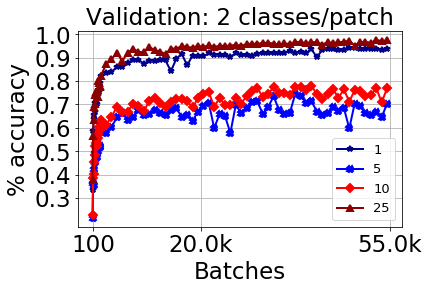

In [84]:
formatter = FuncFormatter(kilo_samples)
lim1 = 1500
a = np.arange(0,lim1,100) # Start at index position 1
lim2 = 100000
b = np.arange(1500,lim2,1000) # Start at index position 1
x = np.concatenate((a, b), axis=0)
a = 0
num = 69
# x = np.arange(0,num,1) # Start at index position 1
plt.rcParams.update({'font.size': 23})
fig2, ax = plt.subplots()
ax.xaxis.set_major_formatter(formatter)

plt.plot(x[a:num],resnet50_plot_1msps2[a:num], '-*', c='darkblue',markersize=6, linewidth=2,markerfacecolor='darkblue',markeredgecolor='darkblue',markeredgewidth=2, label='1')
plt.plot(x[a:num],resnet50_plot_5msps2[a:num], '-X', c='blue', markersize=6, linewidth=2,markerfacecolor='blue',markeredgecolor='blue',markeredgewidth=2, label='5')
plt.plot(x[a:num],resnet50_plot_10msps2[a:num], '-D', c='red', markersize=6, linewidth=2,markerfacecolor='red',markeredgecolor='red',markeredgewidth=2, label='10')
plt.plot(x[a:num],resnet50_plot_25msps2[a:num], '-^', c='darkred', markersize=6, linewidth=2,markerfacecolor='darkred',markeredgecolor='darkred',markeredgewidth=2, label='25')
plt.legend(loc='lower right', fontsize=13)
# Put a legend to the right of the current axis
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Validation: 2 classes/patch', fontsize=23)
plt.xlabel('Batches')
plt.ylabel('% accuracy')
plt.grid()
# plt.minorticks_on()
# plt.yticks(np.arange(.5,1, .1))
# plt.yticks([.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0])
plt.yticks([.3, .4, .5, .6, .7, .8, .9, 1.0])
# plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 10])
plt.xticks([100, 20000, 55000])
# plt.tight_layout()
axes=plt.gca()
# ax.set_aspect('equal')
# axes.set_aspect(10)
plt.subplots_adjust(left=0.17)
plt.subplots_adjust(bottom=0.20)
# fig2.set_size_inches(8.27, 11.69)
fig2.set_size_inches(6.0, 4.0)
fig2.savefig('resnet50_2classes_20220210.pdf', format="pdf")

#### original 2 class/patch plot

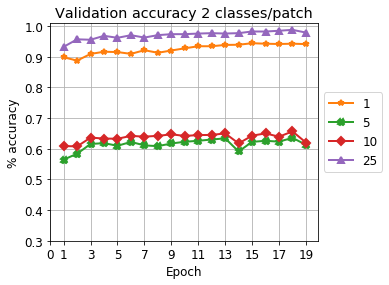

In [81]:
# num = len(resnet50_4D) # reduced rank by 1 for matrix math to work out
num = 20
plt.rcParams.update({'font.size': 12})
x = np.arange(0,num,1) # Start at index position 1
# plt.figure(figsize=(9, 6))

fig2 = plt.figure()
ax = plt.subplot(111)
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# plt.plot(x[0:num],resnet50_total_plot2[:num], '-o', c='#1f77b4',markersize=6, linewidth=2,markerfacecolor='#1f77b4',markeredgecolor='#1f77b4',markeredgewidth=2,label='total')
plt.plot(x[1:num],resnet50_plot_1msps2[1:num], '-*', c='#ff7f0e',markersize=6, linewidth=2,markerfacecolor='#ff7f0e',markeredgecolor='#ff7f0e',markeredgewidth=2, label='1')
plt.plot(x[1:num],resnet50_plot_5msps2[1:num], '-X', c='#2ca02c', markersize=6, linewidth=2,markerfacecolor='#2ca02c',markeredgecolor='#2ca02c',markeredgewidth=2, label='5')
plt.plot(x[1:num],resnet50_plot_10msps2[1:num], '-D', c='#d62728', markersize=6, linewidth=2,markerfacecolor='#d62728',markeredgecolor='#d62728',markeredgewidth=2, label='10')
plt.plot(x[1:num],resnet50_plot_25msps2[1:num], '-^', c='#9467bd', markersize=6, linewidth=2,markerfacecolor='#9467bd',markeredgecolor='#9467bd',markeredgewidth=2, label='25')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.legend(loc='center right')
plt.title('Validation accuracy 2 classes/patch')
plt.xlabel('Epoch')
plt.ylabel('% accuracy')
plt.grid()
# plt.minorticks_on()
# plt.yticks(np.arange(.1,1, .1))
plt.yticks([.3, .4,.5, .6, .7, .8, .9, 1.0])
plt.xticks([0, 1, 3, 5, 7, 9, 11,13,15,17,19])
fig2.savefig('resnet50_4ch_20211223_2classes.pdf', format="pdf")
plt.show()

#### Training for 3 classes per patch

In [59]:
batches = 64
classes = 3
batches = batches*classes

In [60]:
criterion = nn.BCEWithLogitsLoss()
lr= 1e-4 # .0004
optimizer = optim.Adam(model.parameters(), lr=lr)
model.train()

ResNet(
  (encoder): ResNetEncoder(
    (gate): Sequential(
      (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (blocks): ModuleList(
      (0): ResNetLayer(
        (blocks): Sequential(
          (0): ResNetBottleNeckBlock(
            (blocks): Sequential(
              (0): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1): ReLU()
              (2): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

#### seperated dataloaders

In [ ]:
# train_dataloader1 = RFDataset(path_1msps, limit=None)
# train_dataloader25 = RFDataset(path_25msps, limit=None)

In [ ]:
# training_data1 = data.DataLoader(train_dataloader1, batch_size=batches, shuffle=True)
# training_data25 = data.DataLoader(train_dataloader25, batch_size=batches, shuffle=True)

#### combined dataloaders (External drive)

In [61]:
train_dataloader = RFDataset(path, limit=None)

/media/david/Extreme Pro/data/combined_data/training_data/
list of patches = 361200


In [62]:
training_data = data.DataLoader(train_dataloader, batch_size=batches, shuffle=True)

In [63]:
# val_patches = None
# rf_dataset_val = RFDataset(path_validation, limit=val_patches)
# validation_data = data.DataLoader(rf_dataset_val, batch_size=batches, shuffle=True)
# validation_data = [validation_data]

In [64]:
val_patches = None
rf_dataset_val1 = RFDataset(path_val_1msps, limit=val_patches)
rf_dataset_val5 = RFDataset(path_val_5msps, limit=val_patches)
rf_dataset_val10 = RFDataset(path_val_10msps, limit=val_patches)
rf_dataset_val25 = RFDataset(path_val_25msps, limit=val_patches)
validation_data1 = data.DataLoader(rf_dataset_val1, batch_size=batches, shuffle=True)
validation_data1 = [validation_data1]
validation_data5 = data.DataLoader(rf_dataset_val5, batch_size=batches, shuffle=True)
validation_data5 = [validation_data5]
validation_data10 = data.DataLoader(rf_dataset_val10, batch_size=batches, shuffle=True)
validation_data10 = [validation_data10]
validation_data25 = data.DataLoader(rf_dataset_val25, batch_size=batches, shuffle=True)
validation_data25 = [validation_data25]

/home/david/sigMF_ML/RF/RF_class/val_1msps/
list of patches = 24000
/home/david/sigMF_ML/RF/RF_class/val_5msps/
list of patches = 20004
/home/david/sigMF_ML/RF/RF_class/val_10msps/
list of patches = 20004
/home/david/sigMF_ML/RF/RF_class/val_25msps/
list of patches = 24000


In [72]:
total = 40
loss_plot3, total_plot3, plot_1msps3, plot_5msps3, plot_10msps3, plot_25msps3 = train_net_combined_data(total)

Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

batches =  192
total patch count =  29336
training data length =  1882
iter epoch =  100
iter batch =  100
i_main =  100
batch time =  3.101883197999996
************************* start *************************
Total 1msps correct = 56.04%
Total 5msps correct = 33.61%
Total 10msps correct = 36.32%


Epoch:   0%|          | 0/40 [04:49<?, ?it/s]

Total 25msps correct = 58.89%
Total % correct 47.24%
test time =  196.54553523100003
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.1710683703 
___________________________________________
iter epoch =  200
iter batch =  100
i_main =  200
batch time =  3.3126164029999927
************************* start *************************
Total 1msps correct = 65.35%
Total 5msps correct = 41.41%
Total 10msps correct = 46.34%


Epoch:   0%|          | 0/40 [09:03<?, ?it/s]

Total 25msps correct = 76.49%
Total % correct 58.62%
test time =  146.7656304609991
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0622317903 
___________________________________________
iter epoch =  300
iter batch =  100
i_main =  300
batch time =  3.2093825330011896
************************* start *************************
Total 1msps correct = 67.51%
Total 5msps correct = 47.17%
Total 10msps correct = 52.97%


Epoch:   0%|          | 0/40 [13:11<?, ?it/s]

Total 25msps correct = 77.44%
Total % correct 62.29%
test time =  140.11371654100003
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0717465430 
___________________________________________
iter epoch =  400
iter batch =  100
i_main =  400
batch time =  3.610909298000479
************************* start *************************
Total 1msps correct = 71.92%
Total 5msps correct = 50.22%
Total 10msps correct = 55.05%


Epoch:   0%|          | 0/40 [17:21<?, ?it/s]

Total 25msps correct = 81.94%
Total % correct 65.89%
test time =  139.329991478
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0557214431 
___________________________________________
iter epoch =  500
iter batch =  100
i_main =  500
batch time =  3.545265446000485
************************* start *************************
Total 1msps correct = 72.64%
Total 5msps correct = 54.09%
Total 10msps correct = 58.13%


Epoch:   0%|          | 0/40 [21:32<?, ?it/s]

Total 25msps correct = 83.60%
Total % correct 68.11%
test time =  140.32549961299992
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0677402765 
___________________________________________
iter epoch =  600
iter batch =  100
i_main =  600
batch time =  3.369050936000349
************************* start *************************
Total 1msps correct = 74.11%
Total 5msps correct = 51.47%
Total 10msps correct = 56.18%


Epoch:   0%|          | 0/40 [25:42<?, ?it/s]

Total 25msps correct = 81.59%
Total % correct 66.93%
test time =  139.31606928399924
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0240982361 
___________________________________________
iter epoch =  700
iter batch =  100
i_main =  700
batch time =  3.5289310250009294
************************* start *************************
Total 1msps correct = 72.31%
Total 5msps correct = 49.00%
Total 10msps correct = 55.07%


Epoch:   0%|          | 0/40 [29:52<?, ?it/s]

Total 25msps correct = 81.62%
Total % correct 65.63%
test time =  138.96498368799985
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0250583142 
___________________________________________
iter epoch =  800
iter batch =  100
i_main =  800
batch time =  3.3252232230006484
************************* start *************************
Total 1msps correct = 75.72%
Total 5msps correct = 53.70%
Total 10msps correct = 57.77%


Epoch:   0%|          | 0/40 [34:04<?, ?it/s]

Total 25msps correct = 84.38%
Total % correct 69.00%
test time =  140.68878436699924
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0622507259 
___________________________________________
iter epoch =  900
iter batch =  100
i_main =  900
batch time =  3.5893766669996694
************************* start *************************
Total 1msps correct = 76.70%
Total 5msps correct = 54.66%
Total 10msps correct = 58.71%


Epoch:   0%|          | 0/40 [38:15<?, ?it/s]

Total 25msps correct = 84.91%
Total % correct 69.84%
test time =  140.4078221029995
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0399492867 
___________________________________________
iter epoch =  1000
iter batch =  100
i_main =  1000
batch time =  3.436653837999984
************************* start *************************
Total 1msps correct = 76.31%
Total 5msps correct = 53.24%
Total 10msps correct = 56.51%


Epoch:   0%|          | 0/40 [42:26<?, ?it/s]

Total 25msps correct = 85.15%
Total % correct 68.98%
test time =  140.19945662399914
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0252057128 
___________________________________________
iter epoch =  1100
iter batch =  100
i_main =  1100
batch time =  3.5007094200009305
************************* start *************************
Total 1msps correct = 77.83%
Total 5msps correct = 55.91%
Total 10msps correct = 61.62%


Epoch:   0%|          | 0/40 [46:36<?, ?it/s]

Total 25msps correct = 85.55%
Total % correct 71.27%
test time =  139.51354518300104
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0655606985 
___________________________________________
iter epoch =  1200
iter batch =  100
i_main =  1200
batch time =  3.2835316630007583
************************* start *************************
Total 1msps correct = 76.38%
Total 5msps correct = 53.85%
Total 10msps correct = 57.71%


Epoch:   0%|          | 0/40 [50:45<?, ?it/s]

Total 25msps correct = 85.05%
Total % correct 69.38%
test time =  138.68033282999932
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0525296405 
___________________________________________
iter epoch =  1300
iter batch =  100
i_main =  1300
batch time =  3.5576794820008217
************************* start *************************
Total 1msps correct = 76.45%
Total 5msps correct = 55.68%
Total 10msps correct = 59.34%


Epoch:   0%|          | 0/40 [54:55<?, ?it/s]

Total 25msps correct = 83.06%
Total % correct 69.64%
test time =  138.70599972199852
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0307878777 
___________________________________________
iter epoch =  1400
iter batch =  100
i_main =  1400
batch time =  3.483847698000318
************************* start *************************
Total 1msps correct = 77.18%
Total 5msps correct = 56.28%
Total 10msps correct = 62.03%


Epoch:   0%|          | 0/40 [59:06<?, ?it/s]

Total 25msps correct = 85.35%
Total % correct 71.21%
test time =  140.3475798949985
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0467014238 
___________________________________________
left over patches =  48


Epoch:   2%|▎         | 1/40 [1:07:44<44:02:07, 4064.80s/it]

iter epoch =  118
iter batch =  1000
i_main =  2000
batch time =  3.436990298998353
************************* start *************************
Total 1msps correct = 79.45%
Total 5msps correct = 53.27%
Total 10msps correct = 59.16%


Epoch:   2%|▎         | 1/40 [1:12:28<44:02:07, 4064.80s/it]

Total 25msps correct = 87.15%
Total % correct 70.99%
test time =  164.59946418400068
*************************** end ***************************
___________________________________________
Epoch 2 Loss 0.0491983891 
___________________________________________
iter epoch =  1118
iter batch =  1000
i_main =  3000
batch time =  3.443245651000325
************************* start *************************
Total 1msps correct = 80.50%
Total 5msps correct = 55.31%
Total 10msps correct = 60.74%


Epoch:   2%|▎         | 1/40 [1:33:44<44:02:07, 4064.80s/it]

Total 25msps correct = 86.94%
Total % correct 72.04%
test time =  198.1237741720015
*************************** end ***************************
___________________________________________
Epoch 2 Loss 0.0291080959 
___________________________________________
left over patches =  48


Epoch:   5%|▌         | 2/40 [1:47:28<37:34:58, 3560.48s/it]

iter epoch =  236
iter batch =  1000
i_main =  4000
batch time =  3.5230158929989557
************************* start *************************
Total 1msps correct = 80.64%
Total 5msps correct = 53.39%
Total 10msps correct = 59.78%


Epoch:   5%|▌         | 2/40 [1:54:24<37:34:58, 3560.48s/it]

Total 25msps correct = 89.12%
Total % correct 72.02%
test time =  197.59576040899992
*************************** end ***************************
___________________________________________
Epoch 3 Loss 0.0095342491 
___________________________________________
iter epoch =  1236
iter batch =  1000
i_main =  5000
batch time =  3.267771274000552
************************* start *************************
Total 1msps correct = 81.81%
Total 5msps correct = 58.23%
Total 10msps correct = 63.98%


Epoch:   5%|▌         | 2/40 [2:15:45<37:34:58, 3560.48s/it]

Total 25msps correct = 89.59%
Total % correct 74.52%
test time =  198.1079281070015
*************************** end ***************************
___________________________________________
Epoch 3 Loss 0.0261422228 
___________________________________________
left over patches =  48


Epoch:   8%|▊         | 3/40 [2:27:23<32:59:58, 3210.77s/it]

iter epoch =  354
iter batch =  1000
i_main =  6000
batch time =  3.4992687560006743
************************* start *************************
Total 1msps correct = 81.53%
Total 5msps correct = 60.99%
Total 10msps correct = 65.12%


Epoch:   8%|▊         | 3/40 [2:36:15<32:59:58, 3210.77s/it]

Total 25msps correct = 87.39%
Total % correct 74.73%
test time =  198.2554399849978
*************************** end ***************************
___________________________________________
Epoch 4 Loss 0.0504862629 
___________________________________________
iter epoch =  1354
iter batch =  1000
i_main =  7000
batch time =  3.2647504699998535
************************* start *************************
Total 1msps correct = 84.16%
Total 5msps correct = 60.77%
Total 10msps correct = 63.18%


Epoch:   8%|▊         | 3/40 [2:57:39<32:59:58, 3210.77s/it]

Total 25msps correct = 90.22%
Total % correct 75.73%
test time =  198.22951445500075
*************************** end ***************************
___________________________________________
Epoch 4 Loss 0.0332861096 
___________________________________________
left over patches =  48


Epoch:  10%|█         | 4/40 [3:07:09<29:38:00, 2963.34s/it]

iter epoch =  472
iter batch =  1000
i_main =  8000
batch time =  3.4626352209998004
************************* start *************************
Total 1msps correct = 82.96%
Total 5msps correct = 56.93%
Total 10msps correct = 61.94%


Epoch:  10%|█         | 4/40 [3:18:06<29:38:00, 2963.34s/it]

Total 25msps correct = 89.76%
Total % correct 74.12%
test time =  197.82904813399728
*************************** end ***************************
___________________________________________
Epoch 5 Loss 0.0164408945 
___________________________________________
iter epoch =  1472
iter batch =  1000
i_main =  9000
batch time =  3.5078330069991353
************************* start *************************
Total 1msps correct = 83.76%
Total 5msps correct = 58.50%
Total 10msps correct = 64.31%


Epoch:  10%|█         | 4/40 [3:39:31<29:38:00, 2963.34s/it]

Total 25msps correct = 91.41%
Total % correct 75.69%
test time =  199.21223335800096
*************************** end ***************************
___________________________________________
Epoch 5 Loss 0.0209610220 
___________________________________________
left over patches =  48


Epoch:  12%|█▎        | 5/40 [3:46:54<27:07:21, 2789.76s/it]

iter epoch =  590
iter batch =  1000
i_main =  10000
batch time =  3.4938575420019333
************************* start *************************
Total 1msps correct = 83.40%
Total 5msps correct = 60.26%
Total 10msps correct = 63.57%


Epoch:  12%|█▎        | 5/40 [4:00:02<27:07:21, 2789.76s/it]

Total 25msps correct = 89.15%
Total % correct 75.20%
test time =  197.999528979999
*************************** end ***************************
___________________________________________
Epoch 6 Loss 0.0156068355 
___________________________________________
iter epoch =  1590
iter batch =  1000
i_main =  11000
batch time =  3.4063230129977455
************************* start *************************
Total 1msps correct = 83.08%
Total 5msps correct = 50.84%
Total 10msps correct = 54.45%


Epoch:  12%|█▎        | 5/40 [4:21:30<27:07:21, 2789.76s/it]

Total 25msps correct = 91.39%
Total % correct 71.51%
test time =  199.6567482740029
*************************** end ***************************
___________________________________________
Epoch 6 Loss 0.0268983096 
___________________________________________
left over patches =  48


Epoch:  15%|█▌        | 6/40 [4:26:44<25:12:58, 2669.95s/it]

iter epoch =  708
iter batch =  1000
i_main =  12000
batch time =  3.5066249150004296
************************* start *************************
Total 1msps correct = 85.28%
Total 5msps correct = 56.45%
Total 10msps correct = 58.64%


Epoch:  15%|█▌        | 6/40 [4:42:09<25:12:58, 2669.95s/it]

Total 25msps correct = 91.26%
Total % correct 74.30%
test time =  199.0422950960019
*************************** end ***************************
___________________________________________
Epoch 7 Loss 0.0130454414 
___________________________________________
iter epoch =  1708
iter batch =  1000
i_main =  13000
batch time =  3.4448999029991683
************************* start *************************
Total 1msps correct = 85.62%
Total 5msps correct = 60.71%
Total 10msps correct = 60.83%


Epoch:  15%|█▌        | 6/40 [5:03:35<25:12:58, 2669.95s/it]

Total 25msps correct = 91.56%
Total % correct 75.94%
test time =  198.97684967000168
*************************** end ***************************
___________________________________________
Epoch 7 Loss 0.0168491900 
___________________________________________
left over patches =  48


Epoch:  18%|█▊        | 7/40 [5:06:42<23:43:39, 2588.48s/it]

iter epoch =  826
iter batch =  1000
i_main =  14000
batch time =  3.4729685279999103
************************* start *************************
Total 1msps correct = 84.90%
Total 5msps correct = 57.72%
Total 10msps correct = 59.90%


Epoch:  18%|█▊        | 7/40 [5:24:25<23:43:39, 2588.48s/it]

Total 25msps correct = 92.12%
Total % correct 75.01%
test time =  199.70219957799782
*************************** end ***************************
___________________________________________
Epoch 8 Loss 0.0301830824 
___________________________________________
iter epoch =  1826
iter batch =  1000
i_main =  15000
batch time =  3.5249980810003763
************************* start *************************
Total 1msps correct = 85.71%
Total 5msps correct = 50.84%
Total 10msps correct = 53.75%


Epoch:  18%|█▊        | 7/40 [5:45:52<23:43:39, 2588.48s/it]

Total 25msps correct = 92.21%
Total % correct 72.29%
test time =  199.25828874999934
*************************** end ***************************
___________________________________________
Epoch 8 Loss 0.0026514693 
___________________________________________
left over patches =  48


Epoch:  20%|██        | 8/40 [5:46:51<22:31:40, 2534.39s/it]

iter epoch =  944
iter batch =  1000
i_main =  16000
batch time =  3.472925113997917
************************* start *************************
Total 1msps correct = 84.79%
Total 5msps correct = 51.68%
Total 10msps correct = 55.88%


Epoch:  20%|██        | 8/40 [6:06:59<22:31:40, 2534.39s/it]

Total 25msps correct = 91.86%
Total % correct 72.62%
test time =  200.07173841300028
*************************** end ***************************
___________________________________________
Epoch 9 Loss 0.0128088575 
___________________________________________
left over patches =  48


Epoch:  22%|██▎       | 9/40 [6:23:54<21:01:18, 2441.25s/it]

iter epoch =  62
iter batch =  1000
i_main =  17000
batch time =  3.431389928002318
************************* start *************************
Total 1msps correct = 86.95%
Total 5msps correct = 51.23%
Total 10msps correct = 55.22%


Epoch:  22%|██▎       | 9/40 [6:28:14<21:01:18, 2441.25s/it]

Total 25msps correct = 93.36%
Total % correct 73.37%
test time =  199.47253797600206
*************************** end ***************************
___________________________________________
Epoch 10 Loss 0.0280120596 
___________________________________________
iter epoch =  1062
iter batch =  1000
i_main =  18000
batch time =  3.360766527999658
************************* start *************************
Total 1msps correct = 86.14%
Total 5msps correct = 48.31%
Total 10msps correct = 50.40%


Epoch:  22%|██▎       | 9/40 [6:49:32<21:01:18, 2441.25s/it]

Total 25msps correct = 92.10%
Total % correct 71.04%
test time =  199.85163059300248
*************************** end ***************************
___________________________________________
Epoch 10 Loss 0.0074567772 
___________________________________________
left over patches =  48


Epoch:  25%|██▌       | 10/40 [7:04:18<20:18:01, 2436.04s/it]

iter epoch =  180
iter batch =  1000
i_main =  19000
batch time =  3.5574092589959037
************************* start *************************
Total 1msps correct = 87.39%
Total 5msps correct = 51.68%
Total 10msps correct = 55.37%


Epoch:  25%|██▌       | 10/40 [7:10:25<20:18:01, 2436.04s/it]

Total 25msps correct = 93.15%
Total % correct 73.56%
test time =  199.13042345500435
*************************** end ***************************
___________________________________________
Epoch 11 Loss 0.0265411548 
___________________________________________
iter epoch =  1180
iter batch =  1000
i_main =  20000
batch time =  3.430199940004968
************************* start *************************
Total 1msps correct = 86.56%
Total 5msps correct = 50.73%
Total 10msps correct = 54.65%


Epoch:  25%|██▌       | 10/40 [7:31:50<20:18:01, 2436.04s/it]

Total 25msps correct = 92.99%
Total % correct 72.92%
test time =  200.01335861600091
*************************** end ***************************
___________________________________________
Epoch 11 Loss 0.0043212520 
___________________________________________
left over patches =  48


Epoch:  28%|██▊       | 11/40 [7:44:30<19:33:56, 2428.85s/it]

iter epoch =  298
iter batch =  1000
i_main =  21000
batch time =  3.5579379759947187
************************* start *************************
Total 1msps correct = 87.38%
Total 5msps correct = 53.28%
Total 10msps correct = 58.05%


Epoch:  28%|██▊       | 11/40 [7:52:29<19:33:56, 2428.85s/it]

Total 25msps correct = 91.91%
Total % correct 74.20%
test time =  198.92985705500178
*************************** end ***************************
___________________________________________
Epoch 12 Loss 0.0278441515 
___________________________________________
iter epoch =  1298
iter batch =  1000
i_main =  22000
batch time =  3.5606414489957388
************************* start *************************
Total 1msps correct = 86.99%
Total 5msps correct = 54.29%
Total 10msps correct = 53.57%


Epoch:  28%|██▊       | 11/40 [8:14:00<19:33:56, 2428.85s/it]

Total 25msps correct = 92.90%
Total % correct 73.57%
test time =  200.08798922500137
*************************** end ***************************
___________________________________________
Epoch 12 Loss 0.0170109365 
___________________________________________
left over patches =  48


Epoch:  30%|███       | 12/40 [8:24:31<18:49:32, 2420.44s/it]

iter epoch =  416
iter batch =  1000
i_main =  23000
batch time =  3.6695134089968633
************************* start *************************
Total 1msps correct = 86.88%
Total 5msps correct = 55.62%
Total 10msps correct = 58.37%


Epoch:  30%|███       | 12/40 [8:34:32<18:49:32, 2420.44s/it]

Total 25msps correct = 93.62%
Total % correct 75.13%
test time =  199.29267992600217
*************************** end ***************************
___________________________________________
Epoch 13 Loss 0.0182252638 
___________________________________________
iter epoch =  1416
iter batch =  1000
i_main =  24000
batch time =  3.744873011004529
************************* start *************************
Total 1msps correct = 88.54%
Total 5msps correct = 52.59%
Total 10msps correct = 54.12%


Epoch:  30%|███       | 12/40 [8:56:01<18:49:32, 2420.44s/it]

Total 25msps correct = 93.26%
Total % correct 73.83%
test time =  199.58524389899685
*************************** end ***************************
___________________________________________
Epoch 13 Loss 0.0089291688 
___________________________________________
left over patches =  48


Epoch:  32%|███▎      | 13/40 [9:04:25<18:05:34, 2412.39s/it]

iter epoch =  534
iter batch =  1000
i_main =  25000
batch time =  3.612854282997432
************************* start *************************
Total 1msps correct = 87.95%
Total 5msps correct = 52.94%
Total 10msps correct = 55.64%


Epoch:  32%|███▎      | 13/40 [9:16:38<18:05:34, 2412.39s/it]

Total 25msps correct = 93.06%
Total % correct 74.04%
test time =  200.48592205000023
*************************** end ***************************
___________________________________________
Epoch 14 Loss 0.0299574547 
___________________________________________
iter epoch =  1534
iter batch =  1000
i_main =  26000
batch time =  3.66644176900445
************************* start *************************
Total 1msps correct = 81.01%
Total 5msps correct = 63.06%
Total 10msps correct = 68.18%


Epoch:  32%|███▎      | 13/40 [9:38:07<18:05:34, 2412.39s/it]

Total 25msps correct = 91.90%
Total % correct 76.98%
test time =  200.46718954899552
*************************** end ***************************
___________________________________________
Epoch 14 Loss 0.0113888253 
___________________________________________
left over patches =  48


Epoch:  35%|███▌      | 14/40 [9:44:22<17:23:22, 2407.79s/it]

iter epoch =  652
iter batch =  1000
i_main =  27000
batch time =  3.4224449210014427
************************* start *************************
Total 1msps correct = 87.99%
Total 5msps correct = 58.53%
Total 10msps correct = 56.36%


Epoch:  35%|███▌      | 14/40 [9:58:42<17:23:22, 2407.79s/it]

Total 25msps correct = 93.64%
Total % correct 75.64%
test time =  200.64960679600335
*************************** end ***************************
___________________________________________
Epoch 15 Loss 0.0193549488 
___________________________________________
iter epoch =  1652
iter batch =  1000
i_main =  28000
batch time =  3.427175643002556
************************* start *************************
Total 1msps correct = 88.62%
Total 5msps correct = 51.11%
Total 10msps correct = 51.80%


Epoch:  35%|███▌      | 14/40 [10:20:10<17:23:22, 2407.79s/it]

Total 25msps correct = 93.31%
Total % correct 73.01%
test time =  200.12426163100463
*************************** end ***************************
___________________________________________
Epoch 15 Loss 0.0046703257 
___________________________________________
left over patches =  48


Epoch:  38%|███▊      | 15/40 [10:24:17<16:41:42, 2404.11s/it]

iter epoch =  770
iter batch =  1000
i_main =  29000
batch time =  3.467287295999995
************************* start *************************
Total 1msps correct = 88.84%
Total 5msps correct = 53.61%
Total 10msps correct = 52.35%


Epoch:  38%|███▊      | 15/40 [10:40:58<16:41:42, 2404.11s/it]

Total 25msps correct = 94.92%
Total % correct 74.20%
test time =  199.8454452779988
*************************** end ***************************
___________________________________________
Epoch 16 Loss 0.0264356565 
___________________________________________
iter epoch =  1770
iter batch =  1000
i_main =  30000
batch time =  3.6652238559981924
************************* start *************************
Total 1msps correct = 88.05%
Total 5msps correct = 49.54%
Total 10msps correct = 52.29%


Epoch:  38%|███▊      | 15/40 [11:02:29<16:41:42, 2404.11s/it]

Total 25msps correct = 94.42%
Total % correct 72.91%
test time =  200.25478791599744
*************************** end ***************************
___________________________________________
Epoch 16 Loss 0.0102290176 
___________________________________________
left over patches =  48


Epoch:  40%|████      | 16/40 [11:04:29<16:02:31, 2406.31s/it]

iter epoch =  888
iter batch =  1000
i_main =  31000
batch time =  3.3797724270043545
************************* start *************************
Total 1msps correct = 88.24%
Total 5msps correct = 48.16%
Total 10msps correct = 51.33%


Epoch:  40%|████      | 16/40 [11:23:30<16:02:31, 2406.31s/it]

Total 25msps correct = 94.23%
Total % correct 72.37%
test time =  200.60554292100278
*************************** end ***************************
___________________________________________
Epoch 17 Loss 0.0015629156 
___________________________________________
left over patches =  48


Epoch:  42%|████▎     | 17/40 [11:41:29<15:00:57, 2350.32s/it]

iter epoch =  6
iter batch =  1000
i_main =  32000
batch time =  3.6862579389999155
************************* start *************************
Total 1msps correct = 87.36%
Total 5msps correct = 54.06%
Total 10msps correct = 55.56%


Epoch:  42%|████▎     | 17/40 [11:44:59<15:00:57, 2350.32s/it]

Total 25msps correct = 95.17%
Total % correct 74.70%
test time =  200.8782788219978
*************************** end ***************************
___________________________________________
Epoch 18 Loss 0.0267550349 
___________________________________________
iter epoch =  1006
iter batch =  1000
i_main =  33000
batch time =  3.4600217870029155
************************* start *************************
Total 1msps correct = 89.38%
Total 5msps correct = 63.54%
Total 10msps correct = 66.12%


Epoch:  42%|████▎     | 17/40 [12:06:13<15:00:57, 2350.32s/it]

Total 25msps correct = 94.05%
Total % correct 79.49%
test time =  200.54318025999964
*************************** end ***************************
___________________________________________
Epoch 18 Loss 0.0176927298 
___________________________________________
left over patches =  48


Epoch:  45%|████▌     | 18/40 [12:22:03<14:31:00, 2375.48s/it]

iter epoch =  124
iter batch =  1000
i_main =  34000
batch time =  3.3374275530004525
************************* start *************************
Total 1msps correct = 89.80%
Total 5msps correct = 53.78%
Total 10msps correct = 55.65%


Epoch:  45%|████▌     | 18/40 [12:27:19<14:31:00, 2375.48s/it]

Total 25msps correct = 94.74%
Total % correct 75.20%
test time =  199.84366726100416
*************************** end ***************************
___________________________________________
Epoch 19 Loss 0.0189001672 
___________________________________________
iter epoch =  1124
iter batch =  1000
i_main =  35000
batch time =  3.4457777420029743
************************* start *************************
Total 1msps correct = 89.05%
Total 5msps correct = 53.58%
Total 10msps correct = 55.35%


Epoch:  45%|████▌     | 18/40 [12:48:43<14:31:00, 2375.48s/it]

Total 25msps correct = 95.56%
Total % correct 75.11%
test time =  200.49003465999704
*************************** end ***************************
___________________________________________
Epoch 19 Loss 0.0032210317 
___________________________________________
left over patches =  48


Epoch:  48%|████▊     | 19/40 [13:02:24<13:56:16, 2389.34s/it]

iter epoch =  242
iter batch =  1000
i_main =  36000
batch time =  3.4635910429933574
************************* start *************************
Total 1msps correct = 88.34%
Total 5msps correct = 48.46%
Total 10msps correct = 51.48%


Epoch:  48%|████▊     | 19/40 [13:09:31<13:56:16, 2389.34s/it]

Total 25msps correct = 94.40%
Total % correct 72.55%
test time =  200.0462842659981
*************************** end ***************************
___________________________________________
Epoch 20 Loss 0.0111066429 
___________________________________________
iter epoch =  1242
iter batch =  1000
i_main =  37000
batch time =  3.6946604030017625
************************* start *************************
Total 1msps correct = 89.68%
Total 5msps correct = 52.22%
Total 10msps correct = 52.10%


Epoch:  48%|████▊     | 19/40 [13:31:02<13:56:16, 2389.34s/it]

Total 25msps correct = 95.09%
Total % correct 74.10%
test time =  200.39836654999817
*************************** end ***************************
___________________________________________
Epoch 20 Loss 0.0340096951 
___________________________________________
left over patches =  48


Epoch:  50%|█████     | 20/40 [13:42:35<13:18:33, 2395.69s/it]

iter epoch =  360
iter batch =  1000
i_main =  38000
batch time =  3.454351713997312
************************* start *************************
Total 1msps correct = 89.51%
Total 5msps correct = 51.05%
Total 10msps correct = 50.28%


Epoch:  50%|█████     | 20/40 [13:51:39<13:18:33, 2395.69s/it]

Total 25msps correct = 95.30%
Total % correct 73.43%
test time =  200.74064468299912
*************************** end ***************************
___________________________________________
Epoch 21 Loss 0.0141753573 
___________________________________________
iter epoch =  1360
iter batch =  1000
i_main =  39000
batch time =  3.56304850000015
************************* start *************************
Total 1msps correct = 89.55%
Total 5msps correct = 54.62%
Total 10msps correct = 55.74%


Epoch:  50%|█████     | 20/40 [14:13:10<13:18:33, 2395.69s/it]

Total 25msps correct = 95.47%
Total % correct 75.54%
test time =  200.73767559899716
*************************** end ***************************
___________________________________________
Epoch 21 Loss 0.0074498532 
___________________________________________
left over patches =  48


Epoch:  52%|█████▎    | 21/40 [14:22:35<12:39:05, 2397.13s/it]

iter epoch =  478
iter batch =  1000
i_main =  40000
batch time =  3.510522085001867
************************* start *************************
Total 1msps correct = 89.44%
Total 5msps correct = 50.97%
Total 10msps correct = 51.66%


Epoch:  52%|█████▎    | 21/40 [14:33:40<12:39:05, 2397.13s/it]

Total 25msps correct = 94.29%
Total % correct 73.43%
test time =  200.486640117997
*************************** end ***************************
___________________________________________
Epoch 22 Loss 0.0047800289 
___________________________________________
iter epoch =  1478
iter batch =  1000
i_main =  41000
batch time =  3.5756309390053502
************************* start *************************
Total 1msps correct = 89.14%
Total 5msps correct = 52.25%
Total 10msps correct = 52.19%


Epoch:  52%|█████▎    | 21/40 [14:55:12<12:39:05, 2397.13s/it]

Total 25msps correct = 95.40%
Total % correct 74.06%
test time =  201.1659685170016
*************************** end ***************************
___________________________________________
Epoch 22 Loss 0.0189286768 
___________________________________________
left over patches =  48


Epoch:  55%|█████▌    | 22/40 [15:02:29<11:58:50, 2396.12s/it]

iter epoch =  596
iter batch =  1000
i_main =  42000
batch time =  3.66728182600491
************************* start *************************
Total 1msps correct = 90.20%
Total 5msps correct = 48.91%
Total 10msps correct = 50.10%


Epoch:  55%|█████▌    | 22/40 [15:15:51<11:58:50, 2396.12s/it]

Total 25msps correct = 95.64%
Total % correct 73.18%
test time =  201.06437868600187
*************************** end ***************************
___________________________________________
Epoch 23 Loss 0.0169449598 
___________________________________________
iter epoch =  1596
iter batch =  1000
i_main =  43000
batch time =  3.7028289930021856
************************* start *************************
Total 1msps correct = 89.38%
Total 5msps correct = 55.29%
Total 10msps correct = 53.82%


Epoch:  55%|█████▌    | 22/40 [15:37:24<11:58:50, 2396.12s/it]

Total 25msps correct = 95.62%
Total % correct 75.25%
test time =  200.46237785699486
*************************** end ***************************
___________________________________________
Epoch 23 Loss 0.0039635878 
___________________________________________
left over patches =  48


Epoch:  57%|█████▊    | 23/40 [15:42:32<11:19:29, 2398.22s/it]

iter epoch =  714
iter batch =  1000
i_main =  44000
batch time =  3.6444408249953995
************************* start *************************
Total 1msps correct = 89.22%
Total 5msps correct = 55.82%
Total 10msps correct = 54.27%


Epoch:  57%|█████▊    | 23/40 [15:58:10<11:19:29, 2398.22s/it]

Total 25msps correct = 95.88%
Total % correct 75.50%
test time =  201.12765583499277
*************************** end ***************************
___________________________________________
Epoch 24 Loss 0.0094083771 
___________________________________________
iter epoch =  1714
iter batch =  1000
i_main =  45000
batch time =  3.4956957120011793
************************* start *************************
Total 1msps correct = 89.53%
Total 5msps correct = 56.42%
Total 10msps correct = 52.80%


Epoch:  57%|█████▊    | 23/40 [16:19:42<11:19:29, 2398.22s/it]

Total 25msps correct = 95.26%
Total % correct 75.22%
test time =  200.4611355960078
*************************** end ***************************
___________________________________________
Epoch 24 Loss 0.0248985924 
___________________________________________
left over patches =  48


Epoch:  60%|██████    | 24/40 [16:22:42<10:40:26, 2401.66s/it]

iter epoch =  832
iter batch =  1000
i_main =  46000
batch time =  3.589007465998293
************************* start *************************
Total 1msps correct = 88.84%
Total 5msps correct = 53.06%
Total 10msps correct = 54.36%


Epoch:  60%|██████    | 24/40 [16:40:39<10:40:26, 2401.66s/it]

Total 25msps correct = 95.62%
Total % correct 74.72%
test time =  201.34026205699774
*************************** end ***************************
___________________________________________
Epoch 25 Loss 0.0145748407 
___________________________________________
iter epoch =  1832
iter batch =  1000
i_main =  47000
batch time =  3.5937477970001055
************************* start *************************
Total 1msps correct = 90.72%
Total 5msps correct = 58.53%
Total 10msps correct = 56.12%


Epoch:  60%|██████    | 24/40 [17:02:11<10:40:26, 2401.66s/it]

Total 25msps correct = 95.55%
Total % correct 76.86%
test time =  200.38806764899346
*************************** end ***************************
___________________________________________
Epoch 25 Loss 0.0122496886 
___________________________________________
left over patches =  48


Epoch:  62%|██████▎   | 25/40 [17:03:04<10:01:54, 2407.65s/it]

iter epoch =  950
iter batch =  1000
i_main =  48000
batch time =  3.4555382739927154
************************* start *************************
Total 1msps correct = 89.42%
Total 5msps correct = 55.68%
Total 10msps correct = 54.54%


Epoch:  62%|██████▎   | 25/40 [17:23:21<10:01:54, 2407.65s/it]

Total 25msps correct = 95.56%
Total % correct 75.50%
test time =  202.08019720599987
*************************** end ***************************
___________________________________________
Epoch 26 Loss 0.0092079556 
___________________________________________
left over patches =  48


Epoch:  65%|██████▌   | 26/40 [17:40:12<9:09:14, 2353.86s/it] 

iter epoch =  68
iter batch =  1000
i_main =  49000
batch time =  3.4190331060090102
************************* start *************************
Total 1msps correct = 90.09%
Total 5msps correct = 52.01%
Total 10msps correct = 51.51%


Epoch:  65%|██████▌   | 26/40 [17:44:39<9:09:14, 2353.86s/it]

Total 25msps correct = 95.66%
Total % correct 74.19%
test time =  201.6437384949968
*************************** end ***************************
___________________________________________
Epoch 27 Loss 0.0028740386 
___________________________________________
iter epoch =  1068
iter batch =  1000
i_main =  50000
batch time =  3.680026273999829
************************* start *************************
Total 1msps correct = 90.86%
Total 5msps correct = 58.77%
Total 10msps correct = 56.04%


Epoch:  65%|██████▌   | 26/40 [18:06:04<9:09:14, 2353.86s/it]

Total 25msps correct = 96.10%
Total % correct 77.08%
test time =  201.41639429800853
*************************** end ***************************
___________________________________________
Epoch 27 Loss 0.0172726996 
___________________________________________
left over patches =  48


Epoch:  68%|██████▊   | 27/40 [18:20:46<8:35:14, 2378.02s/it]

iter epoch =  186
iter batch =  1000
i_main =  51000
batch time =  3.652406836001319
************************* start *************************
Total 1msps correct = 91.56%
Total 5msps correct = 49.46%
Total 10msps correct = 50.55%


Epoch:  68%|██████▊   | 27/40 [18:27:03<8:35:14, 2378.02s/it]

Total 25msps correct = 96.14%
Total % correct 73.92%
test time =  202.20681372600666
*************************** end ***************************
___________________________________________
Epoch 28 Loss 0.0055949409 
___________________________________________
iter epoch =  1186
iter batch =  1000
i_main =  52000
batch time =  3.5728096489910968
************************* start *************************
Total 1msps correct = 90.31%
Total 5msps correct = 50.96%
Total 10msps correct = 50.15%


Epoch:  68%|██████▊   | 27/40 [18:48:33<8:35:14, 2378.02s/it]

Total 25msps correct = 96.64%
Total % correct 73.96%
test time =  202.0392310640018
*************************** end ***************************
___________________________________________
Epoch 28 Loss 0.0033519045 
___________________________________________
left over patches =  48


Epoch:  70%|███████   | 28/40 [19:01:06<7:58:07, 2390.65s/it]

iter epoch =  304
iter batch =  1000
i_main =  53000
batch time =  3.65953952500422
************************* start *************************
Total 1msps correct = 90.96%
Total 5msps correct = 51.36%
Total 10msps correct = 51.89%


Epoch:  70%|███████   | 28/40 [19:09:13<7:58:07, 2390.65s/it]

Total 25msps correct = 95.70%
Total % correct 74.37%
test time =  200.6763076759962
*************************** end ***************************
___________________________________________
Epoch 29 Loss 0.0159566160 
___________________________________________
iter epoch =  1304
iter batch =  1000
i_main =  54000
batch time =  3.5745778439886635
************************* start *************************
Total 1msps correct = 90.51%
Total 5msps correct = 52.14%
Total 10msps correct = 51.60%


Epoch:  70%|███████   | 28/40 [19:30:45<7:58:07, 2390.65s/it]

Total 25msps correct = 96.10%
Total % correct 74.47%
test time =  201.76195250799356
*************************** end ***************************
___________________________________________
Epoch 29 Loss 0.0270418208 
___________________________________________
left over patches =  48


Epoch:  72%|███████▎  | 29/40 [19:41:11<7:19:01, 2394.73s/it]

iter epoch =  422
iter batch =  1000
i_main =  55000
batch time =  3.5233461019961396
************************* start *************************
Total 1msps correct = 90.30%
Total 5msps correct = 56.10%
Total 10msps correct = 55.31%


Epoch:  72%|███████▎  | 29/40 [19:51:20<7:19:01, 2394.73s/it]

Total 25msps correct = 95.55%
Total % correct 76.01%
test time =  201.85627043699787
*************************** end ***************************
___________________________________________
Epoch 30 Loss 0.0045144018 
___________________________________________
iter epoch =  1422
iter batch =  1000
i_main =  56000
batch time =  3.693985101999715
************************* start *************************
Total 1msps correct = 91.04%
Total 5msps correct = 56.73%
Total 10msps correct = 52.44%


Epoch:  72%|███████▎  | 29/40 [20:12:52<7:19:01, 2394.73s/it]

Total 25msps correct = 97.02%
Total % correct 76.10%
test time =  202.32451115599542
*************************** end ***************************
___________________________________________
Epoch 30 Loss 0.0050936737 
___________________________________________
left over patches =  48


Epoch:  75%|███████▌  | 30/40 [20:21:10<6:39:21, 2396.14s/it]

iter epoch =  540
iter batch =  1000
i_main =  57000
batch time =  3.4539896079950267
************************* start *************************
Total 1msps correct = 90.97%
Total 5msps correct = 54.20%
Total 10msps correct = 55.32%


Epoch:  75%|███████▌  | 30/40 [20:33:30<6:39:21, 2396.14s/it]

Total 25msps correct = 96.08%
Total % correct 75.90%
test time =  200.8853933700011
*************************** end ***************************
___________________________________________
Epoch 31 Loss 0.0216191150 
___________________________________________
iter epoch =  1540
iter batch =  1000
i_main =  58000
batch time =  3.779451162001351
************************* start *************************
Total 1msps correct = 90.74%
Total 5msps correct = 52.70%
Total 10msps correct = 51.18%


Epoch:  75%|███████▌  | 30/40 [20:55:03<6:39:21, 2396.14s/it]

Total 25msps correct = 93.70%
Total % correct 73.91%
test time =  201.11853689300187
*************************** end ***************************
___________________________________________
Epoch 31 Loss 0.0241529346 
___________________________________________
left over patches =  48


Epoch:  78%|███████▊  | 31/40 [21:01:11<5:59:39, 2397.68s/it]

iter epoch =  658
iter batch =  1000
i_main =  59000
batch time =  3.55187645200931
************************* start *************************
Total 1msps correct = 91.38%
Total 5msps correct = 49.79%
Total 10msps correct = 49.21%


Epoch:  78%|███████▊  | 31/40 [21:15:44<5:59:39, 2397.68s/it]

Total 25msps correct = 96.53%
Total % correct 73.74%
test time =  202.5309937359998
*************************** end ***************************
___________________________________________
Epoch 32 Loss 0.0226723030 
___________________________________________
iter epoch =  1658
iter batch =  1000
i_main =  60000
batch time =  3.708702711999649
************************* start *************************
Total 1msps correct = 90.95%
Total 5msps correct = 48.79%
Total 10msps correct = 49.60%


Epoch:  78%|███████▊  | 31/40 [21:37:14<5:59:39, 2397.68s/it]

Total 25msps correct = 96.70%
Total % correct 73.53%
test time =  202.7608221739938
*************************** end ***************************
___________________________________________
Epoch 32 Loss 0.0089374287 
___________________________________________
left over patches =  48


Epoch:  80%|████████  | 32/40 [21:41:15<5:19:56, 2399.56s/it]

iter epoch =  776
iter batch =  1000
i_main =  61000
batch time =  3.407786790994578
************************* start *************************
Total 1msps correct = 91.19%
Total 5msps correct = 56.96%
Total 10msps correct = 56.90%


Epoch:  80%|████████  | 32/40 [21:58:08<5:19:56, 2399.56s/it]

Total 25msps correct = 96.62%
Total % correct 77.10%
test time =  201.77717165500508
*************************** end ***************************
___________________________________________
Epoch 33 Loss 0.0204204582 
___________________________________________
iter epoch =  1776
iter batch =  1000
i_main =  62000
batch time =  3.5689561469916953
************************* start *************************
Total 1msps correct = 90.79%
Total 5msps correct = 46.72%
Total 10msps correct = 48.82%


Epoch:  80%|████████  | 32/40 [22:19:41<5:19:56, 2399.56s/it]

Total 25msps correct = 96.60%
Total % correct 72.81%
test time =  201.67043962300522
*************************** end ***************************
___________________________________________
Epoch 33 Loss 0.0165341515 
___________________________________________
left over patches =  48


Epoch:  82%|████████▎ | 33/40 [22:21:34<4:40:37, 2405.37s/it]

iter epoch =  894
iter batch =  1000
i_main =  63000
batch time =  3.646330884002964
************************* start *************************
Total 1msps correct = 91.69%
Total 5msps correct = 56.19%
Total 10msps correct = 52.46%


Epoch:  82%|████████▎ | 33/40 [22:40:48<4:40:37, 2405.37s/it]

Total 25msps correct = 96.45%
Total % correct 76.00%
test time =  201.9817058500048
*************************** end ***************************
___________________________________________
Epoch 34 Loss 0.0079161581 
___________________________________________
left over patches =  48


Epoch:  85%|████████▌ | 34/40 [22:58:41<3:55:11, 2351.88s/it]

iter epoch =  12
iter batch =  1000
i_main =  64000
batch time =  3.422469467011979
************************* start *************************
Total 1msps correct = 91.46%
Total 5msps correct = 52.89%
Total 10msps correct = 50.85%


Epoch:  85%|████████▌ | 34/40 [23:02:18<3:55:11, 2351.88s/it]

Total 25msps correct = 96.54%
Total % correct 74.85%
test time =  201.7225235220103
*************************** end ***************************
___________________________________________
Epoch 35 Loss 0.0084382547 
___________________________________________
iter epoch =  1012
iter batch =  1000
i_main =  65000
batch time =  3.6341730099957203
************************* start *************************
Total 1msps correct = 92.61%
Total 5msps correct = 56.46%
Total 10msps correct = 55.20%


Epoch:  85%|████████▌ | 34/40 [23:23:36<3:55:11, 2351.88s/it]

Total 25msps correct = 96.79%
Total % correct 77.03%
test time =  201.92373725399375
*************************** end ***************************
___________________________________________
Epoch 35 Loss 0.0199805144 
___________________________________________
left over patches =  48


Epoch:  88%|████████▊ | 35/40 [23:39:21<3:18:10, 2378.18s/it]

iter epoch =  130
iter batch =  1000
i_main =  66000
batch time =  3.689497999002924
************************* start *************************
Total 1msps correct = 91.59%
Total 5msps correct = 50.16%
Total 10msps correct = 49.40%


Epoch:  88%|████████▊ | 35/40 [23:44:44<3:18:10, 2378.18s/it]

Total 25msps correct = 95.25%
Total % correct 73.58%
test time =  201.68384456400236
*************************** end ***************************
___________________________________________
Epoch 36 Loss 0.0124448715 
___________________________________________
iter epoch =  1130
iter batch =  1000
i_main =  67000
batch time =  3.5104098159936257
************************* start *************************
Total 1msps correct = 90.36%
Total 5msps correct = 53.19%
Total 10msps correct = 52.80%


Epoch:  88%|████████▊ | 35/40 [24:06:14<3:18:10, 2378.18s/it]

Total 25msps correct = 95.25%
Total % correct 74.71%
test time =  202.20886710799823
*************************** end ***************************
___________________________________________
Epoch 36 Loss 0.0336297229 
___________________________________________
left over patches =  48


Epoch:  90%|█████████ | 36/40 [24:19:51<2:39:34, 2393.66s/it]

iter epoch =  248
iter batch =  1000
i_main =  68000
batch time =  3.7067418759979773
************************* start *************************
Total 1msps correct = 91.84%
Total 5msps correct = 49.42%
Total 10msps correct = 50.04%


Epoch:  90%|█████████ | 36/40 [24:27:05<2:39:34, 2393.66s/it]

Total 25msps correct = 96.43%
Total % correct 73.95%
test time =  201.21063705699635
*************************** end ***************************
___________________________________________
Epoch 37 Loss 0.0303924363 
___________________________________________
iter epoch =  1248
iter batch =  1000
i_main =  69000
batch time =  3.4803391309978906
************************* start *************************
Total 1msps correct = 91.88%
Total 5msps correct = 54.27%
Total 10msps correct = 51.89%


Epoch:  90%|█████████ | 36/40 [24:48:39<2:39:34, 2393.66s/it]

Total 25msps correct = 97.14%
Total % correct 75.67%
test time =  202.6140383710008
*************************** end ***************************
___________________________________________
Epoch 37 Loss 0.0101462100 
___________________________________________
left over patches =  48


Epoch:  92%|█████████▎| 37/40 [25:00:07<2:00:01, 2400.36s/it]

iter epoch =  366
iter batch =  1000
i_main =  70000
batch time =  3.5238648819940863
************************* start *************************
Total 1msps correct = 90.60%
Total 5msps correct = 58.77%
Total 10msps correct = 56.10%


Epoch:  92%|█████████▎| 37/40 [25:09:19<2:00:01, 2400.36s/it]

Total 25msps correct = 96.84%
Total % correct 77.23%
test time =  201.39325103499868
*************************** end ***************************
___________________________________________
Epoch 38 Loss 0.0403333418 
___________________________________________
iter epoch =  1366
iter batch =  1000
i_main =  71000
batch time =  3.523045149006066
************************* start *************************
Total 1msps correct = 92.59%
Total 5msps correct = 54.38%
Total 10msps correct = 55.74%


Epoch:  92%|█████████▎| 37/40 [25:30:54<2:00:01, 2400.36s/it]

Total 25msps correct = 96.60%
Total % correct 76.62%
test time =  201.5065731289942
*************************** end ***************************
___________________________________________
Epoch 38 Loss 0.0071727736 
___________________________________________
left over patches =  48


Epoch:  95%|█████████▌| 38/40 [25:40:12<1:20:03, 2401.78s/it]

iter epoch =  484
iter batch =  1000
i_main =  72000
batch time =  3.6699407460109796
************************* start *************************
Total 1msps correct = 92.33%
Total 5msps correct = 51.77%
Total 10msps correct = 50.67%


Epoch:  95%|█████████▌| 38/40 [25:51:29<1:20:03, 2401.78s/it]

Total 25msps correct = 95.99%
Total % correct 74.64%
test time =  202.12653792199853
*************************** end ***************************
___________________________________________
Epoch 39 Loss 0.0086860051 
___________________________________________
iter epoch =  1484
iter batch =  1000
i_main =  73000
batch time =  3.7428060170059325
************************* start *************************
Total 1msps correct = 92.36%
Total 5msps correct = 52.47%
Total 10msps correct = 50.66%


Epoch:  95%|█████████▌| 38/40 [26:13:04<1:20:03, 2401.78s/it]

Total 25msps correct = 96.53%
Total % correct 74.95%
test time =  202.11369111199747
*************************** end ***************************
___________________________________________
Epoch 39 Loss 0.0176063478 
___________________________________________
left over patches =  48


Epoch:  98%|█████████▊| 39/40 [26:20:14<40:02, 2402.00s/it]  

iter epoch =  602
iter batch =  1000
i_main =  74000
batch time =  3.542643540989957
************************* start *************************
Total 1msps correct = 91.92%
Total 5msps correct = 48.89%
Total 10msps correct = 51.06%


Epoch:  98%|█████████▊| 39/40 [26:33:42<40:02, 2402.00s/it]

Total 25msps correct = 95.97%
Total % correct 73.96%
test time =  201.67473785100447
*************************** end ***************************
___________________________________________
Epoch 40 Loss 0.0240571033 
___________________________________________
iter epoch =  1602
iter batch =  1000
i_main =  75000
batch time =  3.343618664992391
************************* start *************************
Total 1msps correct = 92.00%
Total 5msps correct = 56.76%
Total 10msps correct = 53.91%


Epoch:  98%|█████████▊| 39/40 [26:55:16<40:02, 2402.00s/it]

Total 25msps correct = 95.47%
Total % correct 76.28%
test time =  201.1633076799917
*************************** end ***************************
___________________________________________
Epoch 40 Loss 0.0167299416 
___________________________________________
left over patches =  48


Epoch: 100%|██████████| 40/40 [27:00:19<00:00, 2430.48s/it]


### PLOTTING 3 classes/patch

In [73]:
path_plot_fig = "/home/david/sigMF_ML/RF/RF_class/plot_data/" # ACE
os.chdir(path_plot_fig)
np.save('resnet50_sub_epoch_total_plot3_2022211', np.asarray(total_plot3))
np.save('resnet50_sub_epoch_plot_1msps3_2022211', np.asarray(plot_1msps3))
np.save('resnet50_sub_epoch_plot_5msps3_2022211', np.asarray(plot_5msps3))
np.save('resnet50_sub_epoch_plot_10msps3_2022211', np.asarray(plot_10msps3))
np.save('resnet50_sub_epoch_plot_25msps3_2022211', np.asarray(plot_25msps3))

In [74]:
os.chdir(path_plot_fig)
resnet50_total_plot3 = np.load('resnet50_sub_epoch_total_plot3_2022211.npy')
resnet50_plot_1msps3 = np.load('resnet50_sub_epoch_plot_1msps3_2022211.npy')
resnet50_plot_5msps3 = np.load('resnet50_sub_epoch_plot_5msps3_2022211.npy')
resnet50_plot_10msps3 = np.load('resnet50_sub_epoch_plot_10msps3_2022211.npy')
resnet50_plot_25msps3 = np.load('resnet50_sub_epoch_plot_25msps3_2022211.npy')

In [90]:
88-36

52

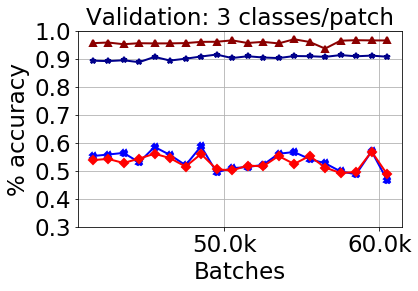

In [95]:
formatter = FuncFormatter(kilo_samples)
lim1 = 1500
a = np.arange(0,lim1,100) # Start at index position 1
lim2 = 100000
b = np.arange(1500,lim2,1000) # Start at index position 1
x = np.concatenate((a, b), axis=0)
a = 55
num = 75 #88
# x = np.arange(0,num,1) # Start at index position 1
plt.rcParams.update({'font.size': 23})
fig2, ax = plt.subplots()
ax.xaxis.set_major_formatter(formatter)

plt.plot(x[a:num],resnet50_plot_1msps3[a:num], '-*', c='darkblue',markersize=6, linewidth=2,markerfacecolor='darkblue',markeredgecolor='darkblue',markeredgewidth=2, label='1')
plt.plot(x[a:num],resnet50_plot_5msps3[a:num], '-X', c='blue', markersize=6, linewidth=2,markerfacecolor='blue',markeredgecolor='blue',markeredgewidth=2, label='5')
plt.plot(x[a:num],resnet50_plot_10msps3[a:num], '-D', c='red', markersize=6, linewidth=2,markerfacecolor='red',markeredgecolor='red',markeredgewidth=2, label='10')
plt.plot(x[a:num],resnet50_plot_25msps3[a:num], '-^', c='darkred', markersize=6, linewidth=2,markerfacecolor='darkred',markeredgecolor='darkred',markeredgewidth=2, label='25')
# plt.legend(loc='lower right', fontsize=13)
# Put a legend to the right of the current axis
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Validation: 3 classes/patch', fontsize=23)
plt.xlabel('Batches')
plt.ylabel('% accuracy')
plt.grid()
# plt.minorticks_on()
# plt.yticks(np.arange(.5,1, .1))
# plt.yticks([.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0])
plt.yticks([.3, .4, .5, .6, .7, .8, .9, 1.0])
# plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 10])
# plt.xticks([100, 2000,4000, 8500])
# plt.tight_layout()
axes=plt.gca()
# ax.set_aspect('equal')
# axes.set_aspect(10)
plt.subplots_adjust(left=0.15)
plt.subplots_adjust(bottom=0.20)
# fig2.set_size_inches(8.27, 11.69)
fig2.set_size_inches(6.0, 4.0)
fig2.savefig('resnet50_3classes_20220211.pdf', format="pdf")

#### original 3 classes / patch

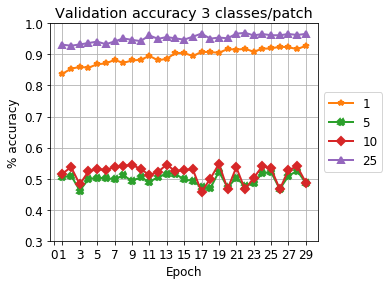

In [58]:
# num = len(resnet50_4D) # reduced rank by 1 for matrix math to work out
num = 30
plt.rcParams.update({'font.size': 12})
x = np.arange(0,num,1) # Start at index position 1
# plt.figure(figsize=(9, 6))

fig2 = plt.figure()
ax = plt.subplot(111)
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# plt.plot(x[0:num],resnet50_total_plot3[:num], '-o', c='#1f77b4',markersize=6, linewidth=2,markerfacecolor='#1f77b4',markeredgecolor='#1f77b4',markeredgewidth=2,label='total')
plt.plot(x[1:num],resnet50_plot_1msps3[1:num], '-*', c='#ff7f0e',markersize=6, linewidth=2,markerfacecolor='#ff7f0e',markeredgecolor='#ff7f0e',markeredgewidth=2, label='1')
plt.plot(x[1:num],resnet50_plot_5msps3[1:num], '-X', c='#2ca02c', markersize=6, linewidth=2,markerfacecolor='#2ca02c',markeredgecolor='#2ca02c',markeredgewidth=2, label='5')
plt.plot(x[1:num],resnet50_plot_10msps3[1:num], '-D', c='#d62728', markersize=6, linewidth=2,markerfacecolor='#d62728',markeredgecolor='#d62728',markeredgewidth=2, label='10')
plt.plot(x[1:num],resnet50_plot_25msps3[1:num], '-^', c='#9467bd', markersize=6, linewidth=2,markerfacecolor='#9467bd',markeredgecolor='#9467bd',markeredgewidth=2, label='25')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.legend(loc='center right')
plt.title('Validation accuracy 3 classes/patch')
plt.xlabel('Epoch')
plt.ylabel('% accuracy')
plt.grid()
# plt.minorticks_on()
# plt.yticks(np.arange(.1,1, .1))
plt.yticks([.3, .4, .5, .6, .7, .8, .9, 1.0])
plt.xticks([0, 1, 3, 5, 7, 9, 11,13,15,17,19,21,23,25,27,29])
fig2.savefig('resnet50_4ch_20211224_3classes.pdf', format="pdf")
plt.show()

## Testing test file combinations

In [97]:
# path_test_10msps = "/media/david/Elements/sigMF_ML/RF/10msps_sample_test/" # multiclass testing

In [98]:
# path_test_1msps = "/media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps/"

#### 2 classes file used for scoring

In [55]:
load_net = 'ResNet50_multiclass_20220210_mix_autosave_GPU1_2class_inference-epoch-19-batch-56000.pt'

In [56]:
path_test_1msps_compact = "/media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/"
path_test_5msps_compact = "/media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/"
path_test_10msps_compact = "/media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/"
path_test_25msps_compact = "/media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/"

## Combination testing script 20211108

In [57]:
def multiclass_test(folder_meta):
    one_hot_label = np.zeros([12]).astype(int) # creating one hot vector
    i = 0
    for label_list in folder_meta:
        for label_path in label_list:
            with open(str(label_path)) as meta_data:
                metadata = json.load(meta_data)
                label = int(metadata["global"]["core:class"])
#                 print('label = ', label)
            one_hot_label[label] = 1
#     print(one_hot_label)
    return one_hot_label

### Choose 3

In [58]:
# N = 10
# k = 3
# scipy.special.comb(N, k).astype(int)

120

In [74]:
msps = 1
N_choose_K = 3
data_IQ_folder_list_test = sorted(pathlib.Path(path_test_1msps_compact).glob('*/'))
folder_combo = it.combinations(data_IQ_folder_list_test, N_choose_K) # combinations of all folders
combo_tot = scipy.special.comb(10, N_choose_K).astype(int)
i = 0
j= 0
folder_iq = [[],[],[]]
folder_meta = [[],[],[]]
total_ground_truth_count = 0
for x in folder_combo: # start of 1 combination of folders
    print('***************************** Start of combined file test *************************************')
#     print('folders = ', x)
    i = 0
    for y in x: # Cycle through all combinations of data files per particular folder combination
        print('individual folder = ', y)
        folder_iq[i] = sorted(pathlib.Path(y).rglob('*.sigmf-data'))
#         folder_meta[i] = sorted(pathlib.Path(y).rglob('*.sigmf-meta'))
        folder_meta[i] = list(pathlib.Path(y).rglob('*.sigmf-meta'))
        i = i+1
    labels = multiclass_test(folder_meta)
    combo = [y for y in it.product(*folder_iq)]
#     print('combo length = ', len(combo))
    for trial in combo:
        print('Test iteration = ', j)
        j = j+1
        center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
#         data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps)
        results_count = testing_live(center_freq_file, trial, labels, load_net)
        total_ground_truth_count = total_ground_truth_count+results_count
        # testing_file(msps)
        torch.cuda.empty_cache() 
print('*************************************************************************')
print('Total test set percent count = {:.2f}%'.format((total_ground_truth_count/combo_tot)*100))
print('*************************************************************************')      

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/click
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/gd55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/light
Test iteration =  0
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/click
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/gd55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/lora125
Test iteration =  1
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/click
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/lora250
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/nfm
Test iteration =  21
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/click
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/lora250
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/sado
Test iteration =  22
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_comp

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/gd55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/light
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/ysf
Test iteration =  42
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/gd55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/lora125
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/lora250
Test iteration =  43
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compa

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/gd55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/vod
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/ysf
Test iteration =  63
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/light
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/lora125
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/lora250
Test iteration =  64
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compac

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/light
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/vod
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/ysf
Test iteration =  84
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/lora125
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/lora250
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/nfm
Test iteration =  85
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/lora250
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/sado
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/vod
Test iteration =  105
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/lora250
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/sado
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/ysf
Test iteration =  106
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compa

In [75]:
msps = 5
N_choose_K = 3
data_IQ_folder_list_test = sorted(pathlib.Path(path_test_5msps_compact).glob('*/'))
folder_combo = it.combinations(data_IQ_folder_list_test, N_choose_K) # combinations of all folders
combo_tot = scipy.special.comb(10, N_choose_K).astype(int)
i = 0
j= 0
folder_iq = [[],[],[]]
folder_meta = [[],[],[]]
total_ground_truth_count = 0
for x in folder_combo: # start of 1 combination of folders
    print('***************************** Start of combined file test *************************************')
#     print('folders = ', x)
    i = 0
    for y in x: # Cycle through all combinations of data files per particular folder combination
        print('individual folder = ', y)
        folder_iq[i] = sorted(pathlib.Path(y).rglob('*.sigmf-data'))
#         folder_meta[i] = sorted(pathlib.Path(y).rglob('*.sigmf-meta'))
        folder_meta[i] = list(pathlib.Path(y).rglob('*.sigmf-meta'))
        i = i+1
    labels = multiclass_test(folder_meta)
    combo = [y for y in it.product(*folder_iq)]
#     print('combo length = ', len(combo))
    for trial in combo:
        print('Test iteration = ', j)
        j = j+1
        center_freq_file = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
#         data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps)
        results_count = testing_live(center_freq_file, trial, labels, load_net)
        total_ground_truth_count = total_ground_truth_count+results_count
        # testing_file(msps)
        torch.cuda.empty_cache() 
print('*************************************************************************')
print('Total test set percent count = {:.2f}%'.format((total_ground_truth_count/combo_tot)*100))
print('*************************************************************************')   

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/GD55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/TYT
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/UV5R
Test iteration =  0
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/GD55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/TYT
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/YSF
Test iteration =  1
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/GD55
ind

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/GD55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/click
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/light
Test iteration =  21
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/GD55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/click
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/lora125
Test iteration =  22
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compa

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/TYT
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/UV5R
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/vod
Test iteration =  42
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/TYT
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/YSF
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/click
Test iteration =  43
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/TYT
in

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/TYT
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/sado
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/vod
Test iteration =  63
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/UV5R
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/YSF
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/click
Test iteration =  64
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/UV5R


***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/UV5R
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/sado
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/vod
Test iteration =  84
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/YSF
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/click
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/light
Test iteration =  85
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/YSF

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/click
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/lora125
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/sado
Test iteration =  105
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/click
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/lora125
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/vod
Test iteration =  106
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_co

In [76]:
msps = 10
N_choose_K = 3
data_IQ_folder_list_test = sorted(pathlib.Path(path_test_10msps_compact).glob('*/'))
folder_combo = it.combinations(data_IQ_folder_list_test, N_choose_K) # combinations of all folders
combo_tot = scipy.special.comb(10, N_choose_K).astype(int)
i = 0
j= 0
folder_iq = [[],[],[]]
folder_meta = [[],[],[]]
total_ground_truth_count = 0
for x in folder_combo: # start of 1 combination of folders
    print('***************************** Start of combined file test *************************************')
#     print('folders = ', x)
    i = 0
    for y in x: # Cycle through all combinations of data files per particular folder combination
        print('individual folder = ', y)
        folder_iq[i] = sorted(pathlib.Path(y).rglob('*.sigmf-data'))
#         folder_meta[i] = sorted(pathlib.Path(y).rglob('*.sigmf-meta'))
        folder_meta[i] = list(pathlib.Path(y).rglob('*.sigmf-meta'))
        i = i+1
    labels = multiclass_test(folder_meta)
    combo = [y for y in it.product(*folder_iq)]
#     print('combo length = ', len(combo))
    for trial in combo:
        print('Test iteration = ', j)
        j = j+1
        center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
#         data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps)
        results_count = testing_live(center_freq_file, trial, labels, load_net)
        total_ground_truth_count = total_ground_truth_count+results_count
        # testing_file(msps)
        torch.cuda.empty_cache() 
print('*************************************************************************')
print('Total test set percent count = {:.2f}%'.format((total_ground_truth_count/combo_tot)*100))
print('*************************************************************************')   

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/GD55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/TYT
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/UV5R
Test iteration =  0
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/GD55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/TYT
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/YSF
Test iteration =  1
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/G

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/GD55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/click
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/light
Test iteration =  21
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/GD55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/click
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/lora125
Test iteration =  22
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msp

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/TYT
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/UV5R
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/sado
Test iteration =  41
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/TYT
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/UV5R
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/vod
Test iteration =  42
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/TYT
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/lora250
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/vod
Test iteration =  62
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/TYT
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/sado
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/vod
Test iteration =  63
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compa

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/UV5R
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/lora250
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/vod
Test iteration =  83
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/UV5R
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/sado
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/vod
Test iteration =  84
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_com

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/click
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/light
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/vod
Test iteration =  103
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/click
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/lora125
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/lora250
Test iteration =  104
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1

In [77]:
msps = 25
N_choose_K = 3
data_IQ_folder_list_test = sorted(pathlib.Path(path_test_25msps_compact).glob('*/'))
combo_tot = scipy.special.comb(10, N_choose_K).astype(int)
folder_combo = it.combinations(data_IQ_folder_list_test, N_choose_K) # combinations of all folders
i = 0
j= 0
folder_iq = [[],[],[]]
folder_meta = [[],[],[]]
total_ground_truth_count = 0
for x in folder_combo: # start of 1 combination of folders
    print('***************************** Start of combined file test *************************************')
#     print('folders = ', x)
    i = 0
    for y in x: # Cycle through all combinations of data files per particular folder combination
        print('individual folder = ', y)
        folder_iq[i] = sorted(pathlib.Path(y).rglob('*.sigmf-data'))
#         folder_meta[i] = sorted(pathlib.Path(y).rglob('*.sigmf-meta'))
        folder_meta[i] = list(pathlib.Path(y).rglob('*.sigmf-meta'))
        i = i+1
    labels = multiclass_test(folder_meta)
    combo = [y for y in it.product(*folder_iq)]
#     print('combo length = ', len(combo))
    for trial in combo:
        print('Test iteration = ', j)
        j = j+1
        center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
#         data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps)
        results_count = testing_live(center_freq_file, trial, labels, load_net)
        total_ground_truth_count = total_ground_truth_count+results_count
        # testing_file(msps)
        torch.cuda.empty_cache() 
print('*************************************************************************')
print('Total test set percent count = {:.2f}%'.format((total_ground_truth_count/combo_tot)*100))
print('*************************************************************************')   

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/GD55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/TYT
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/UV5R
Test iteration =  0
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/GD55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/TYT
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/YSF
Test iteration =  1
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/G

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/GD55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/click
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/light
Test iteration =  21
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/GD55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/click
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/lora125
Test iteration =  22
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msp

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/TYT
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/UV5R
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/sado
Test iteration =  41
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/TYT
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/UV5R
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/vod
Test iteration =  42
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/TYT
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/lora250
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/vod
Test iteration =  62
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/TYT
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/sado
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/vod
Test iteration =  63
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compa

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/UV5R
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/lora250
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/vod
Test iteration =  83
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/UV5R
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/sado
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/vod
Test iteration =  84
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_com

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/click
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/light
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/vod
Test iteration =  103
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/click
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/lora125
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/lora250
Test iteration =  104
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_2

### Choose 2

In [68]:
msps = 1
N_choose_K = 2
data_IQ_folder_list_test = sorted(pathlib.Path(path_test_1msps_compact).glob('*/'))
folder_combo = it.combinations(data_IQ_folder_list_test, N_choose_K) # combinations of all folders
combo_tot = scipy.special.comb(10, N_choose_K).astype(int)
i = 0
j= 0
if (N_choose_K==3):
    folder_iq = [[],[],[]]
    folder_meta = [[],[],[]]
if (N_choose_K==2):
    folder_iq = [[],[]]
    folder_meta = [[],[]]    
total_ground_truth_count = 0
for x in folder_combo: # start of 1 combination of folders
    print('***************************** Start of combined file test *************************************')
#     print('folders = ', x)
    i = 0
    for y in x: # Cycle through all combinations of data files per particular folder combination
        print('individual folder = ', y)
        folder_iq[i] = sorted(pathlib.Path(y).rglob('*.sigmf-data'))
#         print('iq = ', folder_iq[i])
#         folder_meta[i] = sorted(pathlib.Path(y).rglob('*.sigmf-meta'))
        folder_meta[i] = list(pathlib.Path(y).rglob('*.sigmf-meta'))
#         print('meta = ', folder_meta[i])
        i = i+1
    labels = multiclass_test(folder_meta)
    combo = [y for y in it.product(*folder_iq)]
    for trial in combo:
        print('Test iteration = ', j)
        j = j+1
        center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
#         data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps)
        results_count = testing_live(center_freq_file, trial, labels, load_net)
        total_ground_truth_count = total_ground_truth_count+results_count
        # testing_file(msps)
        torch.cuda.empty_cache() 
print('*************************************************************************')
print('Total test set percent count = {:.2f}%'.format((total_ground_truth_count/combo_tot)*100))
print('*************************************************************************')      

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/click
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/gd55
Test iteration =  0
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/click
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/light
Test iteration =  1
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/click
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/lora125
Test iteration =  2
***************************** Start of combined file test ***********

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/lora125
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/tyt
Test iteration =  27
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/lora125
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/vod
Test iteration =  28
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/lora125
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/ysf
Test iteration =  29
***************************** Start of combined file test *********

In [69]:
msps = 5
N_choose_K = 2
data_IQ_folder_list_test = sorted(pathlib.Path(path_test_5msps_compact).glob('*/'))
folder_combo = it.combinations(data_IQ_folder_list_test, N_choose_K) # combinations of all folders
combo_tot = scipy.special.comb(10, N_choose_K).astype(int)
i = 0
j= 0
if (N_choose_K==3):
    folder_iq = [[],[],[]]
    folder_meta = [[],[],[]]
if (N_choose_K==2):
    folder_iq = [[],[]]
    folder_meta = [[],[]]  
total_ground_truth_count = 0
for x in folder_combo: # start of 1 combination of folders
    print('***************************** Start of combined file test *************************************')
#     print('folders = ', x)
    i = 0
    for y in x: # Cycle through all combinations of data files per particular folder combination
        print('individual folder = ', y)
        folder_iq[i] = sorted(pathlib.Path(y).rglob('*.sigmf-data'))
#         folder_meta[i] = sorted(pathlib.Path(y).rglob('*.sigmf-meta'))
        folder_meta[i] = list(pathlib.Path(y).rglob('*.sigmf-meta'))
        i = i+1
    labels = multiclass_test(folder_meta)
    combo = [y for y in it.product(*folder_iq)]
#     print('combo length = ', len(combo))
    for trial in combo:
        print('Test iteration = ', j)
        j = j+1
        center_freq_file = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
#         data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps)
        results_count = testing_live(center_freq_file, trial, labels, load_net)
        total_ground_truth_count = total_ground_truth_count+results_count
        # testing_file(msps)
        torch.cuda.empty_cache() 
print('*************************************************************************')
print('Total test set percent count = {:.2f}%'.format((total_ground_truth_count/combo_tot)*100))
print('*************************************************************************')   

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/GD55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/TYT
Test iteration =  0
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/GD55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/UV5R
Test iteration =  1
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/GD55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/YSF
Test iteration =  2
***************************** Start of combined file test ********************

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/YSF
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/lora250
Test iteration =  27
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/YSF
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/sado
Test iteration =  28
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/YSF
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/vod
Test iteration =  29
***************************** Start of combined file test ****************

In [70]:
msps = 10
N_choose_K = 2
data_IQ_folder_list_test = sorted(pathlib.Path(path_test_10msps_compact).glob('*/'))
folder_combo = it.combinations(data_IQ_folder_list_test, N_choose_K) # combinations of all folders
combo_tot = scipy.special.comb(10, N_choose_K).astype(int)
i = 0
j= 0
if (N_choose_K==3):
    folder_iq = [[],[],[]]
    folder_meta = [[],[],[]]
if (N_choose_K==2):
    folder_iq = [[],[]]
    folder_meta = [[],[]]  
total_ground_truth_count = 0
for x in folder_combo: # start of 1 combination of folders
    print('***************************** Start of combined file test *************************************')
#     print('folders = ', x)
    i = 0
    for y in x: # Cycle through all combinations of data files per particular folder combination
        print('individual folder = ', y)
        folder_iq[i] = sorted(pathlib.Path(y).rglob('*.sigmf-data'))
#         folder_meta[i] = sorted(pathlib.Path(y).rglob('*.sigmf-meta'))
        folder_meta[i] = list(pathlib.Path(y).rglob('*.sigmf-meta'))
        i = i+1
    labels = multiclass_test(folder_meta)
    combo = [y for y in it.product(*folder_iq)]
#     print('combo length = ', len(combo))
    for trial in combo:
        print('Test iteration = ', j)
        j = j+1
        center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
#         data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps)
        results_count = testing_live(center_freq_file, trial, labels, load_net)
        total_ground_truth_count = total_ground_truth_count+results_count
        # testing_file(msps)
        torch.cuda.empty_cache() 
print('*************************************************************************')
print('Total test set percent count = {:.2f}%'.format((total_ground_truth_count/combo_tot)*100))
print('*************************************************************************')   

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/GD55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/TYT
Test iteration =  0
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/GD55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/UV5R
Test iteration =  1
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/GD55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/YSF
Test iteration =  2
***************************** Start of combined file test **************

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/YSF
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/lora250
Test iteration =  27
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/YSF
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/sado
Test iteration =  28
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/YSF
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/vod
Test iteration =  29
***************************** Start of combined file test **********

In [71]:
msps = 25
N_choose_K = 2
data_IQ_folder_list_test = sorted(pathlib.Path(path_test_25msps_compact).glob('*/'))
folder_combo = it.combinations(data_IQ_folder_list_test, N_choose_K) # combinations of all folders
combo_tot = scipy.special.comb(10, N_choose_K).astype(int)
i = 0
j= 0
if (N_choose_K==3):
    folder_iq = [[],[],[]]
    folder_meta = [[],[],[]]
if (N_choose_K==2):
    folder_iq = [[],[]]
    folder_meta = [[],[]]  
total_ground_truth_count = 0
for x in folder_combo: # start of 1 combination of folders
    print('***************************** Start of combined file test *************************************')
#     print('folders = ', x)
    i = 0
    for y in x: # Cycle through all combinations of data files per particular folder combination
        print('individual folder = ', y)
        folder_iq[i] = sorted(pathlib.Path(y).rglob('*.sigmf-data'))
#         folder_meta[i] = sorted(pathlib.Path(y).rglob('*.sigmf-meta'))
        folder_meta[i] = list(pathlib.Path(y).rglob('*.sigmf-meta'))
        i = i+1
    labels = multiclass_test(folder_meta)
    combo = [y for y in it.product(*folder_iq)]
#     print('combo length = ', len(combo))
    for trial in combo:
        print('Test iteration = ', j)
        j = j+1
        center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
#         data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps)
        results_count = testing_live(center_freq_file, trial, labels, load_net)
        total_ground_truth_count = total_ground_truth_count+results_count
        # testing_file(msps)
        torch.cuda.empty_cache() 
print('*************************************************************************')
print('Total test set percent count = {:.2f}%'.format((total_ground_truth_count/combo_tot)*100))
print('*************************************************************************')   

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/GD55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/TYT
Test iteration =  0
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/GD55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/UV5R
Test iteration =  1
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/GD55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/YSF
Test iteration =  2
***************************** Start of combined file test **************

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/YSF
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/lora250
Test iteration =  27
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/YSF
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/sado
Test iteration =  28
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/YSF
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/vod
Test iteration =  29
***************************** Start of combined file test **********

In [57]:
# data = iq_read_test_live_combine(combo_list_10msps,msps) # 20211025
# print('iq data shape = ', data.shape) 

In [ ]:
# os.chdir(path_plot_fig)
# temp = np.load('resnet50_acc_plot2.npy')

In [ ]:
# ymin = 70
# ymax = 100
# axes = plt.gca()
# # axes.set_xlim([xmin,xmax])
# axes.set_ylim([ymin,ymax])


In [ ]:
# os.chdir(path_fig)
# plt.figure(figsize=(9, 6))
# fig = plt.figure()
# plt.plot(total_plot[:20],c='r', label='Total patches correct')
# plt.legend(loc='lower right')
# plt.title('Total % correct vs batches')
# plt.xlabel('Batch number')
# plt.ylabel('% correct')
# plt.grid()
# fig.savefig('RF_class_resnet50_4D.pdf', format="pdf")
# plt.show()

In [ ]:
# os.chdir(path_fig)
# plt.figure(figsize=(9, 6))
# fig = plt.figure()
# plt.plot(loss_plot,c='r', label='Loss curve')
# plt.legend(loc='upper right')
# plt.title('Loss vs Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.grid()
# fig.savefig('RF_class_v56_loss_4D.pdf', format="pdf")
# plt.show()

## Transform saved data

In [68]:
rf_model = 'ResNet50_multiclass_20220210_mix_autosave_GPU1_2class_train-epoch-19-batch-56000.pt'
PATH = path_save+rf_model
criterion = nn.BCEWithLogitsLoss()
lr= 1e-4
model = resnet50(4,12)
optimizer = optim.Adam(model.parameters(), lr=lr)
device = torch.device(cuda)
model.to(device)

ResNet(
  (encoder): ResNetEncoder(
    (gate): Sequential(
      (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (blocks): ModuleList(
      (0): ResNetLayer(
        (blocks): Sequential(
          (0): ResNetBottleNeckBlock(
            (blocks): Sequential(
              (0): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1): ReLU()
              (2): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [69]:
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

#### Save for scoring

In [67]:
rf_model = 'ResNet50_multiclass_20220201_mix_autosave_GPU1_1class_train-epoch-3-batch-17000_score'
PATH = path_save+rf_model
torch.save(model.state_dict(), PATH)

In [102]:
load_net = 'ResNet50_multiclass_20220211_mix_autosave_GPU1_3class_inference-epoch-27-batch-52000.pt'

#### 2 classes file used for scoring

In [59]:
load_net = 'ResNet50_multiclass_20220210_mix_autosave_GPU1_2class_inference-epoch-19-batch-56000.pt'

#### 3 classes file used for scoring

In [73]:
load_net = 'ResNet50_multiclass_20220211_mix_autosave_GPU1_3class_inference-epoch-39-batch-75000.pt'

#### Testing from saved recording data

### LIVE inferencing

In [ ]:
# !python3 /home/david/sigMF_ML/gnuradio/record_live.py

In [ ]:
# load_net = 'ResNet50_multiclass_20210914_score'

###  TESTING

In [ ]:
# msps = 10
# center_freq_live = 433.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
# !python3 /home/david/sigMF_ML/gnuradio/record_live_25to10.py
# # !python3 /home/david/sigMF_ML/gnuradio/record_live1msps.py
# # usrp_data_collect_1MSPS()
# data_IQ_list_val, meta_list_val = inference_read(msps)
# testing_live(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
# # testing_live(msps, load_net)
# torch.cuda.empty_cache()

#### 1msps

In [ ]:
# updating 20210611 memory saving, STFT stays on GPU
msps = 1
center_freq_live = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
# !python3 /home/david/sigMF_ML/gnuradio/record_live_25to1.py # decimated sampler
!python3 /home/david/sigMF_ML/gnuradio/record_live_1msps.py #**********************************************
# !python3 /home/david/sigMF_ML/gnuradio/record_live1msps.py
# usrp_data_collect_1MSPS()
data_IQ_list_val, meta_list_val = inference_read(msps)
testing_live2(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
# testing_live(msps, load_net)
torch.cuda.empty_cache()

In [ ]:
# # old call
# msps = 1
# center_freq_live = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
# !python3 /home/david/sigMF_ML/gnuradio/record_live_1msps.py
# # !python3 /home/david/sigMF_ML/gnuradio/record_live1msps.py
# # usrp_data_collect_1MSPS()
# data_IQ_list_val, meta_list_val = inference_read_old(msps)
# testing_live_original(msps, load_net)
# torch.cuda.empty_cache()

#### 5 msps rate

In [ ]:
msps = 5
center_freq_live = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
!python3 /home/david/sigMF_ML/gnuradio/record_live_5msps.py
# !python3 /home/david/sigMF_ML/gnuradio/record_live1msps.py
# usrp_data_collect_1MSPS()
data_IQ_list_val, meta_list_val = inference_read(msps)
testing_live2(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()

In [ ]:
# msps = 5
# center_freq_live = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
# !python3 /home/david/sigMF_ML/gnuradio/record_live_25to5.py
# # !python3 /home/david/sigMF_ML/gnuradio/record_live1msps.py
# # usrp_data_collect_1MSPS()
# data_IQ_list_val, meta_list_val = inference_read(msps)
# testing_live(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
# torch.cuda.empty_cache()

#### 10 msps rate

In [ ]:
msps = 10
center_freq_live = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
!python3 /home/david/sigMF_ML/gnuradio/record_live_10msps.py
# !python3 /home/david/sigMF_ML/gnuradio/record_live1msps.py
# usrp_data_collect_1MSPS()
data_IQ_list_val, meta_list_val = inference_read(msps)
testing_live2(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()

In [ ]:
# msps = 10
# center_freq_live = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
# !python3 /home/david/sigMF_ML/gnuradio/record_live_25to10.py
# # !python3 /home/david/sigMF_ML/gnuradio/record_live1msps.py
# # usrp_data_collect_1MSPS()
# data_IQ_list_val, meta_list_val = inference_read(msps)
# testing_live(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
# torch.cuda.empty_cache()

##### 25msps

In [ ]:
msps = 25
center_freq_live = 428.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
!python3 /home/david/sigMF_ML/gnuradio/record_live_25msps.py #***********************************************
# !python3 /home/david/sigMF_ML/gnuradio/record_live1msps.py
# usrp_data_collect_1MSPS()
data_IQ_list_val, meta_list_val = inference_read(msps)
testing_live2(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()

#### TESTING Live sample rate differences.

In [ ]:
# load_net = 'ResNet50_20210415_scoring'

In [ ]:
msps = 1
center_freq_live = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
# try 25msps decimation to 1msps
!python3 /home/david/sigMF_ML/gnuradio/record_live_25to1.py
# !python3 /home/david/sigMF_ML/gnuradio/record_live_1msps.py
# usrp_data_collect_1MSPS()
data_IQ_list_val, meta_list_val = inference_read(msps)
testing_live(msps, load_net)
torch.cuda.empty_cache()

In [ ]:
# msps = 1
# center_freq_live = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
# # !python3 /home/david/sigMF_ML/gnuradio/record_live_25to1.py
# !python3 /home/david/sigMF_ML/gnuradio/record_live_1msps.py
# # usrp_data_collect_1MSPS()
# data_IQ_list_val, meta_list_val = inference_read(msps)
# testing_live(msps,load_net)
# torch.cuda.empty_cache()

In [ ]:
torch.cuda.empty_cache()

## testing pre-recorded files in /home/david/sigMF_ML/RF/RF_class/testing_data

In [ ]:
# msps = 5
# center_freq_file = 433.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
# data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_5msps)
# testing_file(msps)
# torch.cuda.empty_cache()

In [ ]:
# msps = 25
# center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
# data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_25msps)
# testing_live(msps,load_net)
# torch.cuda.empty_cache()

### 1MSPS combined files

In [ ]:
msps = 1
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps)
testing_live(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
# testing_file(msps)
torch.cuda.empty_cache()

### 5MSPS combined files

In [ ]:
msps = 5
center_freq_file = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_5msps)
testing_live(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
# testing_file(msps)
torch.cuda.empty_cache()

### 10MSPS combined files

In [ ]:
msps = 10
center_freq_file = 433.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_10msps)
testing_live(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
# testing_file(msps)
torch.cuda.empty_cache()

### 25MSPS combined files

In [ ]:
msps = 25
center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_25msps)
testing_live(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
# testing_file(msps)
torch.cuda.empty_cache()

In [ ]:
msps = 25
center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_25msps)
testing_live(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
# testing_file(msps)
torch.cuda.empty_cache()

In [ ]:
torch.cuda.empty_cache()

#### Save and Load model data

In [ ]:
# rf_model = 'ResNet50_v56_20210208_4D_20dB_autosave'

In [ ]:
# PATH = path_save+rf_model

In [ ]:
load_model()

#### save

In [ ]:
# torch.save(model.state_dict(), PATH)

#### load

In [ ]:
# device = torch.device("cuda:0")
# model = resnet50(4, 12)
# model.load_state_dict(torch.load(PATH))
# model.to(device)
# model.eval()

In [ ]:
# # Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())

In [ ]:
# # Print optimizer's state_dict
# print("Optimizer's state_dict:")
# for var_name in optimizer.state_dict():
#     print(var_name, "\t", optimizer.state_dict()[var_name])

In [ ]:
# # SAVE MODEL
# os.chdir(path_save)
# torch.save({
#            'epoch': epoch,
#            'model_state_dict': model.state_dict(),
#            'optimizer_state_dict': optimizer.state_dict(),
#            'loss': loss,
#            }, path_save+rf_model)

In [ ]:
# # LOAD MODEL
# checkpoint = torch.load(path_save+rf_model, map_location=device)


# # STATUS
# checkpoint.keys()

# epoch = checkpoint['epoch']
# model_state_dict = checkpoint['model_state_dict']
# optimizer_state_dict = checkpoint['optimizer_state_dict']
# loss = checkpoint['loss']

# optimizer_state_dict.keys()

# optimizer_state_dict['param_groups']

# loss

# model.load_state_dict(model_state_dict)   

In [ ]:
# loss

In [ ]:
# optimizer_state_dict.keys()